In [5]:
import __init__
import vsrl_utils as vu
import numpy as np
import copy

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [6]:
def draw_bbox(plt, ax, rois, fill=False, linewidth=2, edgecolor=[1.0, 0.0, 0.0], **kwargs):
    for i in range(rois.shape[0]):
        roi = rois[i,:].astype(np.int)
        ax.add_patch(plt.Rectangle((roi[0], roi[1]),
            roi[2] - roi[0], roi[3] - roi[1],
            fill=False, linewidth=linewidth, edgecolor=edgecolor, **kwargs))

def subplot(plt, (Y, X), (sz_y, sz_x) = (10, 10)):
    plt.rcParams['figure.figsize'] = (X*sz_x, Y*sz_y)
    fig, axes = plt.subplots(Y, X)
    return fig, axes

In [7]:
class_dict = {}
ignore_list = [12, 26, 29, 30, 45, 66, 68 ,69, 71, 83]
j = -1
for i in range(91):
    if i in ignore_list:
        continue
    j += 1
    class_dict[i] = j 
print class_dict

multiobj_dict = {}
multiobj_dict[-7] = 27
multiobj_dict[-8] = 28
multiobj_dict[-15] = 29

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 16, 18: 17, 19: 18, 20: 19, 21: 20, 22: 21, 23: 22, 24: 23, 25: 24, 27: 25, 28: 26, 31: 27, 32: 28, 33: 29, 34: 30, 35: 31, 36: 32, 37: 33, 38: 34, 39: 35, 40: 36, 41: 37, 42: 38, 43: 39, 44: 40, 46: 41, 47: 42, 48: 43, 49: 44, 50: 45, 51: 46, 52: 47, 53: 48, 54: 49, 55: 50, 56: 51, 57: 52, 58: 53, 59: 54, 60: 55, 61: 56, 62: 57, 63: 58, 64: 59, 65: 60, 67: 61, 70: 62, 72: 63, 73: 64, 74: 65, 75: 66, 76: 67, 77: 68, 78: 69, 79: 70, 80: 71, 81: 72, 82: 73, 84: 74, 85: 75, 86: 76, 87: 77, 88: 78, 89: 79, 90: 80}


In [80]:
# Load COCO annotations for V-COCO images
coco = vu.load_coco()

# Load the VCOCO annotations for vcoco_train image set
vcoco_all = vu.load_vcoco('vcoco_val')
for x in vcoco_all:
    x = vu.attach_gt_boxes(x, coco)

In [9]:
# Action classes and roles in V-COCO
classes = [x['action_name'] for x in vcoco_all]
aid_dict = {}
for i, x in enumerate(vcoco_all):
    #print '{:>20s}'.format(x['action_name']), x['role_name']
    aid_dict[i+1] = [x['action_name']]
    if len(x['role_name']) > 1:
        aid_dict[i+1].append(x['role_name'][1])
aid_dict[27] = ['hit', 'obj']
aid_dict[28] = ['eat', 'instr']
aid_dict[29] = ['cut', 'obj']
print aid_dict

{1: ['hold', 'obj'], 2: ['stand'], 3: ['sit', 'instr'], 4: ['ride', 'instr'], 5: ['walk'], 6: ['look', 'obj'], 7: ['hit', 'instr'], 8: ['eat', 'obj'], 9: ['jump', 'instr'], 10: ['lay', 'instr'], 11: ['talk_on_phone', 'instr'], 12: ['carry', 'obj'], 13: ['throw', 'obj'], 14: ['catch', 'obj'], 15: ['cut', 'instr'], 16: ['run'], 17: ['work_on_computer', 'instr'], 18: ['ski', 'instr'], 19: ['surf', 'instr'], 20: ['skateboard', 'instr'], 21: ['smile'], 22: ['drink', 'instr'], 23: ['kick', 'obj'], 24: ['point', 'instr'], 25: ['read', 'obj'], 26: ['snowboard', 'instr'], 27: ['hit', 'obj'], 28: ['eat', 'instr'], 29: ['cut', 'obj']}


In [8]:
import pickle
pickle_out = open("aid_dict.pkl","wb")
pickle.dump(aid_dict, pickle_out)
pickle_out.close()

In [9]:
x = vcoco_all[0]
for key in x:
    print key, type(x[key])

role_object_id <type 'numpy.ndarray'>
ann_id <type 'numpy.ndarray'>
action_name <type 'str'>
image_id <type 'numpy.ndarray'>
role_name <type 'list'>
label <type 'numpy.ndarray'>
role_bbox <type 'numpy.ndarray'>
include <type 'list'>
bbox <type 'numpy.ndarray'>


In [81]:
dict_imgid = {}
for x in vcoco_all:
    anno_n = 0
    cls_id = classes.index(x['action_name'])+1
    rn = x['role_bbox'][0].size/4
    #print x['role_bbox'][0].size
    print x['action_name']
    for index in range(x['ann_id'].size):
        imgid = x['image_id'][index][0]
        if imgid not in dict_imgid:
            dict_imgid[imgid] = [[], []]
        if x['label'][index] != 1:
            continue
        anno_n += 1
        annsh = x['role_object_id'][index].ravel().tolist()
        anns_cls = []
        for index2 in annsh:
            if index2 > 0:
                anns_cls.append(coco.loadAnns(index2)[0]['category_id'])
            else:
                anns_cls.append(0)
        assert anns_cls[0] == 1
        while (len(anns_cls) < 3):
            anns_cls.append(0)
        bboxh = list(x['role_bbox'][index])
        fillbox = bboxh[:4]
        if rn > 1:
            fillbox = [-1, -1, 0, 0]
        while (len(bboxh) < 12):
            bboxh.extend(fillbox)
        for pos, i in enumerate(anns_cls):
            if i==0:
                bboxh[pos*4: pos*4+4] = fillbox
        res1 = [cls_id, class_dict[anns_cls[0]]]
        res1.extend(bboxh[:4])
        res1.append(class_dict[anns_cls[1]])
        res1.extend(bboxh[4:8])
        #print res1
        dict_imgid[imgid][1].append(res1)
        if rn > 2 :
            res2 = [multiobj_dict[-cls_id], class_dict[anns_cls[0]]]
            res2.extend(bboxh[:4])
            res2.append(class_dict[anns_cls[2]])
            res2.extend(bboxh[8:12])
            dict_imgid[imgid][1].append(res2)
            #print res2
    print anno_n
    anno_n = 0
print(len(dict_imgid))

hold
2163
stand
2448
sit
1054
ride
236
walk
356
look
2055
hit
203
eat
376
jump
381
lay
228
talk_on_phone
187
carry
262
throw
141
catch
161
cut
173
run
317
work_on_computer
248
ski
310
surf
259
skateboard
269
smile
867
drink
70
kick
77
point
23
read
65
snowboard
212
2867


In [19]:
def xyhw_to_xyxy(bbox):
  out = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]
  return out

In [82]:
imgid_list = list(dict_imgid.keys())
anns = coco.getAnnIds(imgIds=dict_imgid.keys())
for index in anns:
    x = coco.loadAnns(index)[0]
    imgid = x['image_id']
    bbox = x['bbox']
    bbox = xyhw_to_xyxy(bbox)
    res = [class_dict[x['category_id']]]
    res.extend(bbox)
    dict_imgid[imgid][0].append(res)

In [83]:
img_list = coco.loadImgs(imgid_list)
print len(img_list)
print img_list[0]['file_name']

2867
000000319492.jpg


In [84]:
for index, imgid in enumerate(imgid_list):
    print '#', index
    img = img_list[index]
    print img['file_name']
    print img['width'], img['height']
    print len(dict_imgid[imgid][0])
    for x in dict_imgid[imgid][0]:
        for num in x:
            if type(num) == int:
                print(num),
            else:
                print("{0:.2f}".format(num)),
        print ' '
    action_list = [i for i in dict_imgid[imgid][1]]
    print len(action_list)
    for x in action_list:
        for num in x:
            if type(num) == int:
                print(num),
            else:
                print("{0:.2f}".format(num)),
        print ' '
    print ' '

# 0
000000319492.jpg
640 427
23
3 14.97 185.08 38.06 201.65  
10 15.01 157.01 18.57 164.39  
1 387.53 190.25 460.27 293.31  
1 330.83 202.92 391.42 297.17  
1 378.06 150.77 427.16 248.97  
1 340.25 211.18 572.58 426.71  
1 517.90 189.68 556.95 226.13  
1 79.54 210.70 88.31 228.33  
14 398.21 194.79 640.00 427.00  
74 408.73 312.56 483.74 358.72  
27 352.98 228.22 393.70 296.50  
3 20.76 288.99 37.52 332.01  
3 0.13 166.15 19.20 182.77  
3 0.06 161.66 6.71 169.57  
8 151.05 177.55 163.45 202.63  
10 2.11 147.03 7.71 156.39  
1 89.02 197.23 94.80 215.88  
1 118.61 189.60 122.42 199.03  
3 11.57 182.79 27.72 193.39  
3 6.67 174.18 23.82 188.43  
10 68.83 179.05 77.09 183.85  
10 128.72 216.86 135.22 223.10  
59 557.66 201.84 601.96 261.93  
4
1 1 340.25 211.18 572.58 426.71 74 408.73 312.56 483.74 358.72  
3 1 340.25 211.18 572.58 426.71 14 398.21 194.79 640.00 427.00  
6 1 340.25 211.18 572.58 426.71 74 408.73 312.56 483.74 358.72  
25 1 340.25 211.18 572.58 426.71 74 408.73 312.56 483.7

8 1 152.09 106.79 321.44 480.00 0 -1 -1 0 0  
28 1 152.09 106.79 321.44 480.00 43 216.89 201.91 274.04 251.40  
8 1 322.52 102.47 467.06 474.61 0 -1 -1 0 0  
28 1 322.52 102.47 467.06 474.61 0 -1 -1 0 0  
21 1 152.09 106.79 321.44 480.00 0 152.09 106.79 321.44 480.00  
 
# 19
000000237632.jpg
640 383
11
57 525.12 27.53 597.34 120.47  
57 112.19 20.25 177.29 95.87  
64 74.02 14.49 537.06 363.92  
65 511.37 114.96 557.72 135.87  
74 0.43 57.66 93.61 118.14  
57 577.27 50.62 616.02 117.41  
59 589.56 1.72 636.04 101.77  
1 150.26 0.00 216.73 94.53  
1 114.77 20.60 175.14 95.28  
1 0.00 0.00 118.03 83.02  
1 525.26 2.69 577.98 79.29  
1
3 1 0.00 0.00 118.03 83.02 0 -1 -1 0 0  
 
# 20
000000221252.jpg
640 530
3
1 303.03 161.75 539.84 384.80  
1 55.73 219.57 456.49 366.60  
31 379.93 3.65 571.69 432.42  
4
10 1 55.73 219.57 456.49 366.60 0 -1 -1 0 0  
18 1 303.03 161.75 539.84 384.80 31 379.93 3.65 571.69 432.42  
18 1 55.73 219.57 456.49 366.60 31 379.93 3.65 571.69 432.42  
21 1 55.73 219.

11 1 0.00 92.04 424.00 640.00 68 113.77 270.83 140.20 324.22  
21 1 0.00 92.04 424.00 640.00 0 0.00 92.04 424.00 640.00  
 
# 36
000000413716.jpg
640 425
17
1 243.92 127.56 325.40 265.88  
1 311.02 144.12 389.58 267.25  
1 193.42 168.08 228.45 239.78  
1 393.55 162.93 414.61 218.19  
1 2.87 157.82 85.00 261.92  
1 582.31 169.94 608.82 240.64  
1 615.80 170.98 638.06 206.45  
1 90.11 174.03 104.28 223.73  
1 142.53 155.82 172.33 209.26  
43 475.85 375.48 504.80 397.74  
1 24.30 176.79 46.52 209.23  
1 122.14 185.35 173.90 252.18  
43 504.33 369.22 537.58 400.96  
43 486.47 371.00 522.10 398.76  
43 305.72 375.61 320.51 397.35  
56 36.40 170.64 620.48 328.41  
1 125.99 233.79 155.32 252.45  
11
1 1 243.92 127.56 325.40 265.88 0 -1 -1 0 0  
1 1 311.02 144.12 389.58 267.25 0 -1 -1 0 0  
2 1 243.92 127.56 325.40 265.88 0 243.92 127.56 325.40 265.88  
2 1 311.02 144.12 389.58 267.25 0 311.02 144.12 389.58 267.25  
6 1 243.92 127.56 325.40 265.88 56 36.40 170.64 620.48 328.41  
6 1 311.02 144

2 1 144.63 47.37 324.40 343.57 0 144.63 47.37 324.40 343.57  
6 1 144.63 47.37 324.40 343.57 33 275.54 265.35 292.04 281.18  
6 1 2.70 150.74 231.91 374.56 33 275.54 265.35 292.04 281.18  
7 1 144.63 47.37 324.40 343.57 0 -1 -1 0 0  
27 1 144.63 47.37 324.40 343.57 0 -1 -1 0 0  
 
# 50
000000136664.jpg
479 640
4
18 1.44 379.45 450.16 629.69  
18 2.75 473.27 96.14 543.31  
68 234.99 148.86 280.73 217.89  
1 71.48 73.14 402.29 630.03  
4
1 1 71.48 73.14 402.29 630.03 68 234.99 148.86 280.73 217.89  
3 1 71.48 73.14 402.29 630.03 18 1.44 379.45 450.16 629.69  
4 1 71.48 73.14 402.29 630.03 18 1.44 379.45 450.16 629.69  
11 1 71.48 73.14 402.29 630.03 68 234.99 148.86 280.73 217.89  
 
# 51
000000073889.jpg
640 427
9
1 54.69 3.54 246.60 344.19  
1 182.31 100.75 485.53 362.71  
1 0.00 40.80 51.94 161.03  
3 67.41 62.09 136.02 91.64  
3 219.96 61.88 279.80 87.24  
3 41.33 74.50 63.47 89.07  
36 29.65 105.73 42.20 120.53  
36 207.19 126.86 236.86 160.03  
36 365.55 282.65 393.92 300.60  
2
6 

12 1 178.33 176.38 239.05 347.31 38 134.83 227.60 346.25 305.26  
12 1 76.05 184.52 153.35 360.31 38 36.33 221.88 105.81 358.51  
 
# 68
000000532689.jpg
640 427
4
1 224.53 106.51 332.96 346.40  
1 544.84 137.29 573.30 187.33  
31 529.25 179.57 579.49 187.94  
32 174.06 322.60 390.55 349.85  
3
2 1 224.53 106.51 332.96 346.40 0 224.53 106.51 332.96 346.40  
6 1 224.53 106.51 332.96 346.40 32 174.06 322.60 390.55 349.85  
26 1 224.53 106.51 332.96 346.40 32 174.06 322.60 390.55 349.85  
 
# 69
000000147674.jpg
640 427
26
26 217.33 303.26 314.27 349.10  
26 119.89 307.63 229.41 374.10  
26 282.55 304.09 343.27 322.27  
26 373.48 311.77 394.51 329.46  
1 197.67 325.29 243.73 421.24  
1 422.62 315.74 482.74 427.00  
1 85.21 319.62 150.08 417.41  
1 154.89 335.68 213.74 427.00  
1 309.04 321.90 338.33 427.00  
1 517.91 327.67 569.88 427.00  
1 487.34 325.86 528.53 426.94  
27 93.90 356.85 129.28 402.95  
27 255.96 394.39 281.92 427.00  
27 480.24 376.53 494.57 415.94  
27 338.60 344.74 360.

1 1 361.57 30.36 482.79 307.73 39 347.20 41.52 425.48 88.49  
1 1 47.46 30.20 167.55 300.58 39 29.62 41.69 108.44 89.46  
2 1 361.57 30.36 482.79 307.73 0 361.57 30.36 482.79 307.73  
2 1 47.46 30.20 167.55 300.58 0 47.46 30.20 167.55 300.58  
6 1 361.57 30.36 482.79 307.73 33 606.28 16.47 622.06 32.25  
6 1 47.46 30.20 167.55 300.58 33 287.47 16.40 304.28 33.30  
7 1 361.57 30.36 482.79 307.73 39 347.20 41.52 425.48 88.49  
27 1 361.57 30.36 482.79 307.73 33 606.28 16.47 622.06 32.25  
7 1 47.46 30.20 167.55 300.58 39 29.62 41.69 108.44 89.46  
27 1 47.46 30.20 167.55 300.58 33 287.47 16.40 304.28 33.30  
9 1 361.57 30.36 482.79 307.73 0 -1 -1 0 0  
9 1 47.46 30.20 167.55 300.58 0 -1 -1 0 0  
16 1 361.57 30.36 482.79 307.73 0 361.57 30.36 482.79 307.73  
16 1 47.46 30.20 167.55 300.58 0 47.46 30.20 167.55 300.58  
 
# 81
000000549114.jpg
640 477
9
3 360.29 107.39 390.25 130.25  
3 54.94 142.83 75.63 159.39  
1 81.63 86.05 167.01 365.06  
1 434.48 48.48 523.47 381.63  
37 71.03 342.31 

24 1 63.14 249.11 424.75 630.82 1 61.57 61.70 247.70 542.78  
24 1 61.57 61.70 247.70 542.78 0 -1 -1 0 0  
 
# 92
000000082191.jpg
640 396
18
68 270.80 309.55 297.81 332.81  
10 580.89 177.30 596.99 207.97  
1 335.76 211.52 425.99 395.85  
1 436.04 227.81 531.26 368.41  
1 202.91 281.71 330.65 396.00  
1 168.57 273.62 207.42 396.00  
1 183.95 302.55 236.96 395.60  
1 142.65 312.41 186.03 396.00  
1 105.10 293.17 148.03 396.00  
1 542.54 311.28 608.39 392.24  
1 309.07 308.92 333.87 367.89  
10 146.15 250.53 155.14 275.94  
33 369.66 136.50 425.86 194.03  
1 4.45 287.43 116.58 391.55  
1 203.47 299.37 219.53 308.63  
1 572.91 313.71 639.77 394.97  
1 0.18 299.25 36.19 390.24  
1 295 278 549 395  
8
1 1 202.91 281.71 330.65 396.00 68 270.80 309.55 297.81 332.81  
2 1 335.76 211.52 425.99 395.85 0 335.76 211.52 425.99 395.85  
2 1 202.91 281.71 330.65 396.00 0 202.91 281.71 330.65 396.00  
2 1 4.45 287.43 116.58 391.55 0 4.45 287.43 116.58 391.55  
6 1 335.76 211.52 425.99 395.85 33 369.6

10 121.34 89.63 125.98 108.03  
25 315.30 266.10 355.62 299.72  
37 499.22 286.25 558.69 334.63  
37 149.81 268.49 183.24 283.71  
1 488.72 142.22 551.09 324.21  
3 245.87 147.23 303.79 171.57  
3 123.54 149.91 154.72 167.04  
8 14.69 139.61 39.03 156.49  
10 96.92 83.69 104.77 103.71  
10 0.00 79.54 11.09 105.15  
3 188.41 145.54 210.60 167.25  
10 215.25 6.02 239.26 46.30  
10 575.03 60.99 584.64 77.31  
10 478.73 0.00 489.28 29.25  
3 4 136 350 164  
11
1 1 539.93 125.30 598.68 333.72 0 -1 -1 0 0  
2 1 431.30 134.12 487.84 320.55 0 431.30 134.12 487.84 320.55  
2 1 539.93 125.30 598.68 333.72 0 539.93 125.30 598.68 333.72  
2 1 91.37 114.27 166.19 348.70 0 91.37 114.27 166.19 348.70  
2 1 360.97 138.73 430.75 304.91 0 360.97 138.73 430.75 304.91  
2 1 488.72 142.22 551.09 324.21 0 488.72 142.22 551.09 324.21  
6 1 539.93 125.30 598.68 333.72 1 91.37 114.27 166.19 348.70  
6 1 91.37 114.27 166.19 348.70 0 -1 -1 0 0  
6 1 360.97 138.73 430.75 304.91 0 -1 -1 0 0  
6 1 488.72 142.22 551

38 220.23 173.59 367.48 249.60  
38 142.00 195.08 187.25 236.95  
38 461.80 184.05 532.81 233.76  
38 166.69 180.80 237.95 231.18  
38 428.05 197.33 445.75 234.45  
38 332.36 164.14 368.35 212.77  
1 231.70 208.35 264.73 284.72  
1 247.18 154.45 260.67 172.22  
1 316.36 245.45 332.44 287.61  
12
1 1 286.33 143.57 352.80 300.09 38 220.23 173.59 367.48 249.60  
1 1 427.96 147.73 487.31 295.32 38 461.80 184.05 532.81 233.76  
1 1 478.82 139.93 538.31 291.54 38 461.80 184.05 532.81 233.76  
2 1 286.33 143.57 352.80 300.09 0 286.33 143.57 352.80 300.09  
2 1 427.96 147.73 487.31 295.32 0 427.96 147.73 487.31 295.32  
2 1 478.82 139.93 538.31 291.54 0 478.82 139.93 538.31 291.54  
5 1 286.33 143.57 352.80 300.09 0 286.33 143.57 352.80 300.09  
5 1 427.96 147.73 487.31 295.32 0 427.96 147.73 487.31 295.32  
5 1 478.82 139.93 538.31 291.54 0 478.82 139.93 538.31 291.54  
12 1 286.33 143.57 352.80 300.09 38 220.23 173.59 367.48 249.60  
12 1 427.96 147.73 487.31 295.32 38 428.05 197.33 445.75 2

65 546.98 373.25 626.52 397.93  
65 303.67 362.88 365.32 386.59  
3
3 1 57.17 131.60 190.92 297.71 57 0.00 246.62 58.69 320.96  
6 1 57.17 131.60 190.92 297.71 64 133.75 208.18 317.12 318.20  
17 1 57.17 131.60 190.92 297.71 64 133.75 208.18 317.12 318.20  
 
# 133
000000573795.jpg
640 536
16
32 25.98 470.16 399.05 496.07  
1 111.51 136.38 123.69 150.45  
31 439.54 258.88 543.12 271.56  
31 59.57 230.72 97.22 235.14  
1 57.87 139.98 97.83 235.42  
1 103.82 53.12 293.35 497.37  
1 557.04 133.77 607.64 234.42  
1 78.72 123.44 103.52 192.64  
1 332.28 89.63 390.22 303.89  
1 435.19 127.28 534.01 267.52  
1 418.52 139.52 447.02 197.29  
1 101.69 155.37 118.64 181.70  
32 415.62 299.05 536.69 307.23  
32 471.88 227.19 494.46 232.62  
1 281.32 94.08 341.03 308.89  
32 59.97 232.14 98.86 234.12  
2
2 1 103.82 53.12 293.35 497.37 0 103.82 53.12 293.35 497.37  
26 1 103.82 53.12 293.35 497.37 32 25.98 470.16 399.05 496.07  
 
# 134
000000221540.jpg
640 480
17
64 88.07 65.75 204.40 194.84  
1 96

3 1 129.56 226.90 242.75 391.58 0 -1 -1 0 0  
18 1 2.45 161.79 78.05 369.79 31 40.81 364.05 68.36 395.68  
18 1 70.45 153.69 137.84 361.96 31 67.75 341.93 102.65 378.39  
18 1 535.27 176.78 633.30 384.81 31 566.98 365.61 611.03 390.26  
18 1 478.25 170.01 541.67 373.23 31 477.23 353.38 569.15 392.46  
21 1 129.56 226.90 242.75 391.58 0 129.56 226.90 242.75 391.58  
21 1 2.45 161.79 78.05 369.79 0 2.45 161.79 78.05 369.79  
21 1 70.45 153.69 137.84 361.96 0 70.45 153.69 137.84 361.96  
21 1 245.10 171.72 305.44 352.75 0 245.10 171.72 305.44 352.75  
21 1 535.27 176.78 633.30 384.81 0 535.27 176.78 633.30 384.81  
21 1 350.96 167.32 423.39 362.18 0 350.96 167.32 423.39 362.18  
21 1 478.25 170.01 541.67 373.23 0 478.25 170.01 541.67 373.23  
21 1 415.89 253.34 492.11 397.95 0 415.89 253.34 492.11 397.95  
 
# 148
000000467332.jpg
427 640
3
58 2.75 2.75 427.00 640.00  
1 40.27 21.67 384.00 622.84  
78 40.27 173.59 171.15 327.48  
2
1 1 40.27 21.67 384.00 622.84 78 40.27 173.59 171.15 327.

67 306.00 373.43 353.68 397.63  
3
6 1 76.93 232.69 357.56 396.30 64 307.96 320.26 411.00 395.58  
10 1 76.93 232.69 357.56 396.30 60 1.08 269.48 519.91 472.27  
17 1 76.93 232.69 357.56 396.30 64 307.96 320.26 411.00 395.58  
 
# 164
000000057782.jpg
612 612
10
59 71.69 111.47 170.80 263.59  
40 466.60 529.14 513.06 612.00  
40 516.83 482.90 567.97 577.79  
57 231.64 73.70 281.65 189.52  
57 547.51 327.72 610.68 447.48  
61 0.00 397.98 612.00 612.00  
1 120.75 2.74 581.81 500.85  
43 332.25 448.64 411.04 553.90  
44 272.95 439.32 340.91 567.88  
54 188.41 407.17 435.96 603.84  
7
1 1 120.75 2.74 581.81 500.85 43 332.25 448.64 411.04 553.90  
3 1 120.75 2.74 581.81 500.85 0 -1 -1 0 0  
8 1 120.75 2.74 581.81 500.85 54 188.41 407.17 435.96 603.84  
28 1 120.75 2.74 581.81 500.85 43 332.25 448.64 411.04 553.90  
15 1 120.75 2.74 581.81 500.85 44 272.95 439.32 340.91 567.88  
29 1 120.75 2.74 581.81 500.85 54 188.41 407.17 435.96 603.84  
21 1 120.75 2.74 581.81 500.85 0 120.75 2.74 581.8

21 1 31.15 151.46 126.75 427.51 0 31.15 151.46 126.75 427.51  
21 1 446.54 162.65 528.47 413.69 0 446.54 162.65 528.47 413.69  
21 1 498.72 151.41 599.83 431.37 0 498.72 151.41 599.83 431.37  
21 1 103.92 122.87 192.36 419.51 0 103.92 122.87 192.36 419.51  
 
# 176
000000009836.jpg
429 640
12
37 95.81 162.27 145.76 242.10  
1 113.61 112.56 348.34 309.97  
1 98.87 471.69 130.30 559.88  
1 284.97 530.99 325.31 606.36  
1 316.35 532.32 347.96 602.95  
1 339.86 528.99 366.99 609.28  
2 347.46 497.78 409.14 546.92  
15 231.23 555.99 260.31 588.63  
1 54.88 513.88 90.47 586.48  
1 363.25 540.84 395.17 605.32  
1 405.42 526.14 428.58 589.90  
14 278.66 547.79 339.73 598.49  
4
1 1 113.61 112.56 348.34 309.97 37 95.81 162.27 145.76 242.10  
6 1 113.61 112.56 348.34 309.97 37 95.81 162.27 145.76 242.10  
9 1 113.61 112.56 348.34 309.97 37 95.81 162.27 145.76 242.10  
20 1 113.61 112.56 348.34 309.97 37 95.81 162.27 145.76 242.10  
 
# 177
000000393699.jpg
640 504
2
32 122.31 382.50 452.42 429.6

6 1 297.31 23.78 423.09 232.46 32 267.90 153.27 428.96 278.43  
9 1 297.31 23.78 423.09 232.46 32 267.90 153.27 428.96 278.43  
26 1 297.31 23.78 423.09 232.46 32 267.90 153.27 428.96 278.43  
 
# 195
000000514821.jpg
335 500
4
68 198.95 178.96 220.74 208.70  
1 142.70 21.35 334.83 493.26  
1 17.73 171.56 53.74 294.41  
1 140.18 178.03 152.44 237.29  
3
1 1 142.70 21.35 334.83 493.26 68 198.95 178.96 220.74 208.70  
2 1 142.70 21.35 334.83 493.26 0 142.70 21.35 334.83 493.26  
11 1 142.70 21.35 334.83 493.26 68 198.95 178.96 220.74 208.70  
 
# 196
000000262688.jpg
640 480
11
1 176.75 140.44 244.31 286.82  
1 286.93 157.00 336.23 281.90  
1 328.68 88.65 336.77 114.00  
31 280.86 272.71 361.35 286.62  
1 343.73 86.60 351.11 114.19  
8 227.75 72.19 257.55 100.36  
1 329.40 164.19 397.05 310.58  
1 441.31 86.14 455.13 114.79  
1 309.07 87.86 317.99 114.70  
31 288.46 291.08 416.08 309.37  
31 194.80 274.46 242.04 289.81  
9
1 1 176.75 140.44 244.31 286.82 0 -1 -1 0 0  
1 1 286.93 157.00 3

57 481.65 21.13 526.56 60.18  
57 520.82 24.33 566.64 63.24  
57 436.74 0.73 477.28 24.28  
1 195.55 31.24 269.84 132.03  
1 463.46 201.51 546.94 346.40  
1 49.48 0.36 86.85 13.46  
1 0.00 0.00 14.83 8.53  
57 477.69 0.09 521.83 29.11  
57 148 0 639 53  
11
1 1 247.16 1.44 332.75 168.78 0 -1 -1 0 0  
1 1 157.93 165.73 304.16 343.16 35 164.08 224.53 198.63 280.19  
2 1 247.16 1.44 332.75 168.78 0 247.16 1.44 332.75 168.78  
2 1 157.93 165.73 304.16 343.16 0 157.93 165.73 304.16 343.16  
3 1 333.89 232.06 478.56 352.46 0 -1 -1 0 0  
6 1 333.89 232.06 478.56 352.46 33 143.20 217.35 156.60 231.12  
6 1 247.16 1.44 332.75 168.78 33 143.20 217.35 156.60 231.12  
6 1 157.93 165.73 304.16 343.16 33 143.20 217.35 156.60 231.12  
6 1 463.46 201.51 546.94 346.40 1 157.93 165.73 304.16 343.16  
7 1 157.93 165.73 304.16 343.16 35 164.08 224.53 198.63 280.19  
27 1 157.93 165.73 304.16 343.16 33 143.20 217.35 156.60 231.12  
 
# 211
000000475731.jpg
640 480
5
1 258.03 118.58 367.32 432.49  
39 263.6

43 264.52 345.04 379.76 361.79  
44 252.27 343.62 356.29 385.80  
50 524.57 321.35 555.98 357.62  
68 315.57 290.86 367.55 310.45  
57 63.26 367.09 94.73 468.68  
43 313.23 326.16 383.11 354.45  
5
1 1 35.37 1.63 391.00 460.98 44 290.61 341.96 375.75 404.27  
2 1 35.37 1.63 391.00 460.98 0 35.37 1.63 391.00 460.98  
6 1 35.37 1.63 391.00 460.98 54 302.91 355.55 532.78 475.85  
15 1 35.37 1.63 391.00 460.98 44 290.61 341.96 375.75 404.27  
29 1 35.37 1.63 391.00 460.98 54 302.91 355.55 532.78 475.85  
 
# 226
000000549506.jpg
640 427
3
1 365.37 149.04 584.42 396.81  
30 390.13 266.62 427.88 279.30  
1 201.63 363.10 229.40 389.02  
4
1 1 365.37 149.04 584.42 396.81 30 390.13 266.62 427.88 279.30  
2 1 365.37 149.04 584.42 396.81 0 365.37 149.04 584.42 396.81  
14 1 365.37 149.04 584.42 396.81 30 390.13 266.62 427.88 279.30  
16 1 365.37 149.04 584.42 396.81 0 365.37 149.04 584.42 396.81  
 
# 227
000000148101.jpg
640 480
8
40 255.43 150.45 296.92 252.80  
61 70.19 200.38 519.62 430.19  


2 1 459.25 140.25 497.68 337.82 0 459.25 140.25 497.68 337.82  
2 1 525.98 138.19 582.49 336.35 0 525.98 138.19 582.49 336.35  
2 1 82.65 107.28 154.41 297.89 0 82.65 107.28 154.41 297.89  
2 1 413.00 170.37 475.51 335.82 0 413.00 170.37 475.51 335.82  
2 1 487.92 134.30 544.59 335.31 0 487.92 134.30 544.59 335.31  
18 1 548.01 178.83 608.00 368.33 31 566.46 344.46 593.12 363.87  
18 1 151.46 125.28 208.77 318.69 31 134.07 297.01 218.49 348.43  
18 1 235.05 119.98 281.44 318.47 31 241.18 310.09 289.82 338.47  
18 1 261.83 153.48 332.14 324.59 31 284.05 320.77 319.15 343.29  
18 1 332.66 139.57 386.96 324.23 31 348.81 324.88 409.53 349.72  
18 1 459.25 140.25 497.68 337.82 31 459.88 335.35 478.77 348.88  
18 1 525.98 138.19 582.49 336.35 31 536.53 346.91 567.16 359.07  
18 1 82.65 107.28 154.41 297.89 31 103.76 288.01 151.02 317.22  
18 1 413.00 170.37 475.51 335.82 31 431.75 334.77 467.72 351.95  
18 1 487.92 134.30 544.59 335.31 31 474.16 334.40 505.66 352.76  
21 1 548.01 178.83 608.

6 1 174.89 116.54 350.90 338.51 64 255.06 188.76 493.26 340.45  
6 1 23.65 96.28 222.97 500.00 64 255.06 188.76 493.26 340.45  
17 1 174.89 116.54 350.90 338.51 64 255.06 188.76 493.26 340.45  
 
# 251
000000052003.jpg
640 427
1
1 24.95 106.57 483.61 356.06  
0
 
# 252
000000262869.jpg
480 640
6
1 158.56 131.89 302.70 536.94  
32 325.77 538.38 480.00 594.59  
32 172.45 234.43 365.67 485.88  
25 168.82 218.51 235.80 411.95  
1 399.64 419.06 480.00 546.51  
32 17.54 293.60 145.91 400.99  
2
1 1 158.56 131.89 302.70 536.94 32 172.45 234.43 365.67 485.88  
2 1 158.56 131.89 302.70 536.94 0 158.56 131.89 302.70 536.94  
 
# 253
000000385753.jpg
373 640
4
16 193.31 136.12 312.26 359.50  
1 87.95 16.07 297.74 630.90  
68 136.68 66.53 176.45 117.41  
59 246.03 130.83 372.36 596.28  
4
1 1 87.95 16.07 297.74 630.90 68 136.68 66.53 176.45 117.41  
2 1 87.95 16.07 297.74 630.90 0 87.95 16.07 297.74 630.90  
6 1 87.95 16.07 297.74 630.90 16 193.31 136.12 312.26 359.50  
11 1 87.95 16.07 297.74 630

1 320.39 80.28 348.60 185.87  
1 0.15 121.35 18.79 197.66  
1 0 99 430 200  
8
2 1 223.06 81.74 284.16 230.92 0 223.06 81.74 284.16 230.92  
2 1 178.22 88.40 232.71 222.80 0 178.22 88.40 232.71 222.80  
2 1 118.14 103.92 160.81 218.17 0 118.14 103.92 160.81 218.17  
2 1 297.85 89.54 334.38 214.88 0 297.85 89.54 334.38 214.88  
2 1 339.53 73.06 386.82 219.17 0 339.53 73.06 386.82 219.17  
2 1 15.16 95.39 59.08 208.81 0 15.16 95.39 59.08 208.81  
2 1 82.58 98.60 122.19 200.56 0 82.58 98.60 122.19 200.56  
11 1 339.53 73.06 386.82 219.17 0 -1 -1 0 0  
 
# 266
000000459543.jpg
640 427
10
4 353.15 233.34 519.34 322.08  
1 293.21 137.12 470.78 239.81  
1 364.63 165.04 474.98 268.67  
1 431.52 124.46 485.99 296.25  
1 512.30 187.84 534.38 219.38  
1 450.28 151.63 561.80 244.35  
1 463.32 223.99 608.32 289.57  
14 621.67 211.09 640.00 258.96  
57 622.37 215.51 640.00 259.95  
1 626.13 197.76 639.97 242.37  
3
4 1 293.21 137.12 470.78 239.81 4 353.15 233.34 519.34 322.08  
4 1 364.63 165.04 474

1 1 178.06 110.98 479.00 349.36 42 209.16 265.78 293.05 349.67  
8 1 178.06 110.98 479.00 349.36 0 -1 -1 0 0  
28 1 178.06 110.98 479.00 349.36 0 -1 -1 0 0  
22 1 178.06 110.98 479.00 349.36 42 209.16 265.78 293.05 349.67  
 
# 282
000000426826.jpg
500 375
15
33 191.88 32.52 199.28 38.27  
57 364.17 71.27 399.93 107.32  
57 323.60 57.39 340.20 89.16  
57 312.36 54.78 327.53 88.53  
57 299.99 53.11 319.28 85.75  
57 290.88 51.23 307.16 79.93  
57 238.91 44.11 264.38 73.62  
57 270.85 47.90 284.93 64.96  
57 257.92 46.20 277.29 77.60  
57 279.03 48.53 297.78 81.18  
1 190.03 118.67 271.11 325.59  
39 190.84 229.79 235.45 258.09  
57 174.19 32.89 204.46 60.22  
1 338.19 33.78 366.07 98.34  
1 125.21 62.79 152.22 141.16  
5
1 1 190.03 118.67 271.11 325.59 39 190.84 229.79 235.45 258.09  
2 1 190.03 118.67 271.11 325.59 0 190.03 118.67 271.11 325.59  
6 1 190.03 118.67 271.11 325.59 33 191.88 32.52 199.28 38.27  
7 1 190.03 118.67 271.11 325.59 39 190.84 229.79 235.45 258.09  
27 1 190.03 1

# 294
000000107376.jpg
600 400
3
1 0.89 2.77 581.66 337.45  
68 155.44 142.09 469.43 315.15  
61 0.00 0.52 600.00 394.27  
2
1 1 0.89 2.77 581.66 337.45 68 155.44 142.09 469.43 315.15  
10 1 0.89 2.77 581.66 337.45 61 0.00 0.52 600.00 394.27  
 
# 295
000000189301.jpg
481 640
2
1 130.61 325.08 454.24 631.29  
30 56.69 214.86 235.73 338.51  
3
1 1 130.61 325.08 454.24 631.29 30 56.69 214.86 235.73 338.51  
6 1 130.61 325.08 454.24 631.29 30 56.69 214.86 235.73 338.51  
14 1 130.61 325.08 454.24 631.29 30 56.69 214.86 235.73 338.51  
 
# 296
000000140152.jpg
500 375
4
1 184.98 102.30 279.15 301.57  
32 168.30 271.68 264.02 317.44  
32 433.24 337.94 490.59 370.59  
1 262.04 27.84 439.81 368.58  
2
2 1 262.04 27.84 439.81 368.58 0 262.04 27.84 439.81 368.58  
21 1 262.04 27.84 439.81 368.58 0 262.04 27.84 439.81 368.58  
 
# 297
000000385913.jpg
640 480
26
28 316.97 131.57 335.52 158.77  
28 530.98 102.29 538.14 116.76  
44 265.85 427.13 315.78 462.32  
44 323.84 391.42 371.16 437.31  
44 

53 174.67 295.56 222.45 340.46  
27 253.59 377.38 427.00 640.00  
1 292.42 149.46 335.54 223.18  
1 2.98 144.12 71.26 255.33  
1 68.45 155.28 102.06 208.03  
1 382.94 156.10 427.00 287.24  
42 145.95 357.70 184.63 450.25  
1 45.96 180.72 109.46 326.32  
1 270.06 147.67 303.61 213.56  
1 183.38 154.01 232.94 291.59  
1 0.00 248.60 39.31 556.81  
4
1 1 162.52 214.29 427.00 632.81 53 174.67 295.56 222.45 340.46  
2 1 162.52 214.29 427.00 632.81 0 162.52 214.29 427.00 632.81  
8 1 162.52 214.29 427.00 632.81 53 174.67 295.56 222.45 340.46  
28 1 162.52 214.29 427.00 632.81 0 -1 -1 0 0  
 
# 310
000000238502.jpg
640 458
28
63 189.38 12.35 369.49 119.39  
58 99.91 282.66 295.77 451.82  
58 417.12 213.02 640.00 376.86  
1 232.37 236.96 362.57 458.00  
64 295.64 279.68 382.92 340.94  
65 321.59 340.72 341.75 351.92  
74 525.43 67.72 528.75 90.35  
74 457.42 26.22 462.76 54.53  
74 475.61 110.83 481.37 126.50  
74 446.30 63.16 457.78 91.87  
74 456.81 66.68 525.39 91.13  
74 447.28 24.02 453.73

21 1 0.00 119.89 247.53 479.35 0 0.00 119.89 247.53 479.35  
 
# 321
000000476094.jpg
640 427
4
1 307.33 167.54 503.59 399.24  
1 310.20 81.47 616.57 400.86  
64 53.86 173.59 433.73 409.21  
63 164.86 3.87 378.21 255.44  
9
1 1 310.20 81.47 616.57 400.86 1 307.33 167.54 503.59 399.24  
2 1 310.20 81.47 616.57 400.86 0 310.20 81.47 616.57 400.86  
3 1 307.33 167.54 503.59 399.24 0 -1 -1 0 0  
6 1 307.33 167.54 503.59 399.24 64 53.86 173.59 433.73 409.21  
6 1 310.20 81.47 616.57 400.86 64 53.86 173.59 433.73 409.21  
17 1 307.33 167.54 503.59 399.24 64 53.86 173.59 433.73 409.21  
17 1 310.20 81.47 616.57 400.86 64 53.86 173.59 433.73 409.21  
21 1 307.33 167.54 503.59 399.24 0 307.33 167.54 503.59 399.24  
21 1 310.20 81.47 616.57 400.86 0 310.20 81.47 616.57 400.86  
 
# 322
000000180341.jpg
640 480
37
31 412.82 406.05 534.18 438.56  
32 501.57 276.13 527.46 372.13  
1 256.68 278.82 291.17 381.35  
1 174.34 275.44 211.35 386.46  
1 565.90 247.36 622.53 382.54  
1 364.10 260.64 406.47 

44 430.24 248.31 487.43 256.68  
61 0.00 129.70 82.02 170.51  
40 117.86 86.33 130.72 108.82  
69 341.36 15.37 384.79 45.00  
43 316.58 472.47 334.30 480.00  
42 392.37 145.24 422.34 203.06  
42 311.59 233.80 325.11 283.66  
42 309.62 334.88 346.27 397.97  
13
1 1 0.00 152.09 149.93 442.25 44 58.38 364.66 99.43 378.92  
3 1 117.57 72.27 321.44 328.99 0 -1 -1 0 0  
3 1 0.00 152.09 149.93 442.25 14 74.86 225.28 118.67 247.36  
3 1 478.01 100.54 584.79 334.48 0 -1 -1 0 0  
3 1 459.51 144.54 640.00 431.46 14 473.53 405.57 584.63 476.76  
6 1 117.57 72.27 321.44 328.99 42 311.59 233.80 325.11 283.66  
8 1 117.57 72.27 321.44 328.99 0 -1 -1 0 0  
28 1 117.57 72.27 321.44 328.99 0 -1 -1 0 0  
8 1 0.00 152.09 149.93 442.25 0 -1 -1 0 0  
28 1 0.00 152.09 149.93 442.25 44 58.38 364.66 99.43 378.92  
8 1 459.51 144.54 640.00 431.46 0 -1 -1 0 0  
28 1 459.51 144.54 640.00 431.46 0 -1 -1 0 0  
21 1 0.00 152.09 149.93 442.25 0 0.00 152.09 149.93 442.25  
 
# 333
000000402396.jpg
640 427
2
1 292.66 9

1 1 102.04 103.12 410.33 384.55 78 248.33 208.78 439.99 397.01  
3 1 102.04 103.12 410.33 384.55 58 2.06 79.15 640.00 471.83  
6 1 102.04 103.12 410.33 384.55 64 74.12 134.27 264.24 307.21  
17 1 102.04 103.12 410.33 384.55 64 74.12 134.27 264.24 307.21  
 
# 346
000000082936.jpg
640 428
2
1 72.05 92.41 506.50 427.93  
54 271.05 217.24 339.18 274.12  
4
1 1 72.05 92.41 506.50 427.93 54 271.05 217.24 339.18 274.12  
3 1 72.05 92.41 506.50 427.93 0 -1 -1 0 0  
8 1 72.05 92.41 506.50 427.93 54 271.05 217.24 339.18 274.12  
28 1 72.05 92.41 506.50 427.93 0 -1 -1 0 0  
 
# 347
000000132607.jpg
640 411
5
40 80.24 246.06 128.64 411.00  
68 322.88 242.46 351.72 287.03  
57 460.87 222.43 640.00 407.15  
1 211.50 82.26 525.53 403.84  
57 335.27 231.82 604.03 405.46  
3
1 1 211.50 82.26 525.53 403.84 68 322.88 242.46 351.72 287.03  
3 1 211.50 82.26 525.53 403.84 57 335.27 231.82 604.03 405.46  
11 1 211.50 82.26 525.53 403.84 68 322.88 242.46 351.72 287.03  
 
# 348
000000574460.jpg
640 427
9
40

37 131.30 227.87 213.49 246.86  
14 137.53 243.20 356.01 301.42  
3
6 1 102.11 45.58 221.48 242.62 37 131.30 227.87 213.49 246.86  
9 1 102.11 45.58 221.48 242.62 37 131.30 227.87 213.49 246.86  
20 1 102.11 45.58 221.48 242.62 37 131.30 227.87 213.49 246.86  
 
# 361
000000156716.jpg
331 500
2
1 162.19 182.43 329.98 493.40  
78 0.00 104.49 217.98 494.38  
1
10 1 162.19 182.43 329.98 493.40 0 -1 -1 0 0  
 
# 362
000000558134.jpg
640 426
2
1 80.08 17.30 475.60 217.26  
31 439.28 97.37 588.65 143.84  
1
10 1 80.08 17.30 475.60 217.26 0 -1 -1 0 0  
 
# 363
000000148541.jpg
640 423
15
40 525.26 272.78 542.80 309.70  
40 176.49 193.07 188.27 224.23  
40 73.68 201.04 100.06 297.46  
40 140.68 187.16 162.28 241.18  
40 96.45 198.53 108.02 276.78  
40 0.00 189.80 44.77 305.83  
40 124.50 201.26 134.84 244.97  
1 4.77 0.48 545.22 421.57  
42 299.42 278.25 404.17 422.24  
45 234.50 233.07 353.65 264.30  
42 504.87 369.67 538.32 398.47  
40 608.61 354.92 640.00 423.00  
40 107.96 192.59 129.52 26

1 238.58 103.78 252.55 113.49  
1 47.56 117.67 52.87 123.33  
1 160.29 118.34 165.49 122.80  
1 239.98 174.35 277.52 217.79  
1
19 1 43.98 270.35 92.94 315.86 38 12.21 310.23 67.05 323.51  
 
# 377
000000074838.jpg
640 427
2
30 215.96 228.25 237.47 252.17  
1 227.53 134.46 316.82 335.70  
5
1 1 227.53 134.46 316.82 335.70 30 215.96 228.25 237.47 252.17  
2 1 227.53 134.46 316.82 335.70 0 227.53 134.46 316.82 335.70  
6 1 227.53 134.46 316.82 335.70 30 215.96 228.25 237.47 252.17  
13 1 227.53 134.46 316.82 335.70 30 215.96 228.25 237.47 252.17  
14 1 227.53 134.46 316.82 335.70 30 215.96 228.25 237.47 252.17  
 
# 378
000000328792.jpg
640 424
32
61 145.45 175.99 562.80 415.55  
1 444.01 20.01 640.00 419.24  
1 0.00 1.67 227.79 418.02  
1 360.97 46.32 561.51 288.87  
1 298.50 65.55 360.17 198.19  
1 367.96 66.02 411.06 205.12  
1 338.01 69.50 384.91 202.70  
1 275.75 71.91 302.50 150.75  
41 505.35 299.91 556.18 394.17  
41 322.86 340.78 367.90 423.68  
41 456.74 275.59 491.49 321.28  


13 1 189.84 203.79 327.91 582.03 30 268.71 332.40 339.17 362.90  
 
# 391
000000017526.jpg
427 640
5
3 180.48 264.31 203.37 281.75  
3 165.69 262.62 188.11 280.62  
1 158.04 112.30 270.31 303.78  
37 204.28 302.80 239.51 338.26  
3 131.47 267.25 142.25 275.99  
3
6 1 158.04 112.30 270.31 303.78 37 204.28 302.80 239.51 338.26  
9 1 158.04 112.30 270.31 303.78 37 204.28 302.80 239.51 338.26  
20 1 158.04 112.30 270.31 303.78 37 204.28 302.80 239.51 338.26  
 
# 392
000000312439.jpg
640 451
3
1 213.13 188.41 284.98 426.28  
39 194.93 122.99 305.53 216.71  
1 225.50 25.28 351.90 224.49  
11
1 1 213.13 188.41 284.98 426.28 39 194.93 122.99 305.53 216.71  
1 1 225.50 25.28 351.90 224.49 39 194.93 122.99 305.53 216.71  
2 1 213.13 188.41 284.98 426.28 0 213.13 188.41 284.98 426.28  
2 1 225.50 25.28 351.90 224.49 0 225.50 25.28 351.90 224.49  
7 1 213.13 188.41 284.98 426.28 39 194.93 122.99 305.53 216.71  
27 1 213.13 188.41 284.98 426.28 0 -1 -1 0 0  
7 1 225.50 25.28 351.90 224.49 39 194.9

48 261.53 171.57 278.96 184.03  
48 187.52 176.39 201.95 190.12  
48 227.72 142.48 239.54 151.64  
48 483.78 69.97 490.64 76.83  
1 185.42 53.50 220.80 97.94  
29 359.34 281.96 527.95 391.14  
50 183.83 139.11 196.94 150.26  
49 472.93 191.20 497.50 219.28  
61 475.50 81.71 499.94 88.22  
1 30 5 639 169  
11
1 1 451.42 112.41 638.77 397.00 0 -1 -1 0 0  
3 1 0.00 145.42 116.87 392.54 0 -1 -1 0 0  
3 1 451.42 112.41 638.77 397.00 0 -1 -1 0 0  
6 1 0.00 145.42 116.87 392.54 0 -1 -1 0 0  
6 1 451.42 112.41 638.77 397.00 1 37.61 76.71 227.29 289.63  
8 1 0.00 145.42 116.87 392.54 0 -1 -1 0 0  
28 1 0.00 145.42 116.87 392.54 0 -1 -1 0 0  
8 1 451.42 112.41 638.77 397.00 0 -1 -1 0 0  
28 1 451.42 112.41 638.77 397.00 0 -1 -1 0 0  
21 1 0.00 145.42 116.87 392.54 0 0.00 145.42 116.87 392.54  
21 1 451.42 112.41 638.77 397.00 0 451.42 112.41 638.77 397.00  
 
# 407
000000230554.jpg
640 480
30
33 312.91 269.31 326.17 283.28  
14 179.51 218.29 234.87 222.23  
14 176.90 221.25 237.13 226.84  
1 60.

4 1 1.93 80.97 126.28 209.18 21 0.00 199.93 73.76 421.21  
6 1 277.96 30.62 430.89 244.14 21 28.85 144.51 481.86 428.00  
6 1 1.93 80.97 126.28 209.18 0 -1 -1 0 0  
 
# 420
000000365569.jpg
427 640
11
61 1.88 329.69 427.00 632.82  
1 3.74 2.48 427.00 342.66  
1 298.48 47.28 427.00 243.87  
42 0.00 286.17 60.94 473.94  
43 51.10 313.23 139.64 365.64  
54 89.13 400.44 389.02 609.16  
1 312.18 98.31 353.79 146.22  
44 371.55 394.08 427.00 455.31  
1 49.16 98.06 97.95 166.08  
1 305.47 84.83 345.14 131.92  
1 261.31 83.73 317.64 172.98  
4
1 1 3.74 2.48 427.00 342.66 43 51.10 313.23 139.64 365.64  
3 1 3.74 2.48 427.00 342.66 0 -1 -1 0 0  
8 1 3.74 2.48 427.00 342.66 0 -1 -1 0 0  
28 1 3.74 2.48 427.00 342.66 43 51.10 313.23 139.64 365.64  
 
# 421
000000378056.jpg
640 360
3
1 152.21 79.81 272.21 285.18  
1 408.18 68.98 440.09 146.48  
30 118.08 125.11 156.28 156.79  
3
1 1 152.21 79.81 272.21 285.18 30 118.08 125.11 156.28 156.79  
2 1 152.21 79.81 272.21 285.18 0 152.21 79.81 272.21 285.

1 122.40 22.00 514.36 592.75  
55 247.95 312.54 379.71 440.60  
58 15.06 52.16 205.37 592.96  
4
1 1 122.40 22.00 514.36 592.75 55 247.95 312.54 379.71 440.60  
3 1 122.40 22.00 514.36 592.75 58 15.06 52.16 205.37 592.96  
8 1 122.40 22.00 514.36 592.75 55 247.95 312.54 379.71 440.60  
28 1 122.40 22.00 514.36 592.75 0 -1 -1 0 0  
 
# 436
000000421491.jpg
640 480
14
1 521.87 0.00 571.99 71.07  
35 324.07 245.89 405.59 269.23  
1 79.99 0.77 139.47 48.17  
36 411.01 297.07 435.62 323.06  
1 476.84 0.00 551.99 71.27  
1 405.33 0.00 474.07 86.52  
1 574.21 0.15 624.61 105.41  
1 370.64 0.00 418.34 25.03  
1 260.50 0.00 288.08 10.98  
1 414.10 0.34 446.72 22.09  
1 9.48 0.00 31.42 39.69  
1 528.58 204.81 611.82 351.17  
1 241.87 163.32 385.25 332.88  
1 409.90 234.65 539.41 347.52  
6
1 1 241.87 163.32 385.25 332.88 35 324.07 245.89 405.59 269.23  
2 1 528.58 204.81 611.82 351.17 0 528.58 204.81 611.82 351.17  
2 1 241.87 163.32 385.25 332.88 0 241.87 163.32 385.25 332.88  
3 1 409.90 234.6

2 1 3.50 166.79 382.23 546.35 0 3.50 166.79 382.23 546.35  
6 1 3.50 166.79 382.23 546.35 33 229.45 100.55 271.68 139.79  
13 1 3.50 166.79 382.23 546.35 33 229.45 100.55 271.68 139.79  
 
# 452
000000574739.jpg
640 478
3
3 595.40 148.77 631.27 171.09  
4 0.00 144.01 610.60 472.30  
1 274.19 59.48 409.41 240.71  
2
2 1 274.19 59.48 409.41 240.71 0 274.19 59.48 409.41 240.71  
21 1 274.19 59.48 409.41 240.71 0 274.19 59.48 409.41 240.71  
 
# 453
000000435479.jpg
640 640
3
1 246.31 279.46 370.18 566.77  
1 184.52 283.03 279.36 441.08  
37 209.98 553.00 326.66 614.95  
8
2 1 246.31 279.46 370.18 566.77 0 246.31 279.46 370.18 566.77  
2 1 184.52 283.03 279.36 441.08 0 184.52 283.03 279.36 441.08  
6 1 246.31 279.46 370.18 566.77 37 209.98 553.00 326.66 614.95  
6 1 184.52 283.03 279.36 441.08 1 246.31 279.46 370.18 566.77  
9 1 246.31 279.46 370.18 566.77 37 209.98 553.00 326.66 614.95  
9 1 184.52 283.03 279.36 441.08 0 -1 -1 0 0  
20 1 246.31 279.46 370.18 566.77 37 209.98 553.00 326.66

1 1 206.74 0.00 332.58 268.54 0 -1 -1 0 0  
2 1 206.74 0.00 332.58 268.54 0 206.74 0.00 332.58 268.54  
3 1 10.11 89.89 310.11 396.63 0 -1 -1 0 0  
8 1 10.11 89.89 310.11 396.63 0 -1 -1 0 0  
28 1 10.11 89.89 310.11 396.63 0 -1 -1 0 0  
8 1 206.74 0.00 332.58 268.54 0 -1 -1 0 0  
28 1 206.74 0.00 332.58 268.54 0 -1 -1 0 0  
21 1 10.11 89.89 310.11 396.63 0 10.11 89.89 310.11 396.63  
22 1 10.11 89.89 310.11 396.63 42 235.09 314.13 281.55 368.32  
 
# 468
000000329035.jpg
640 426
15
68 462.33 325.55 495.11 338.36  
57 0.00 233.29 70.84 419.96  
57 71.74 129.99 155.28 201.60  
57 400.20 205.12 459.72 285.81  
57 527.93 244.97 639.48 419.03  
1 226.23 93.20 415.24 306.86  
1 107.22 76.58 282.40 255.60  
1 382.92 155.08 591.61 419.30  
64 139.77 205.82 314.00 299.64  
64 317.82 264.22 455.68 340.80  
64 28.94 191.05 158.87 260.75  
57 571.11 349.04 640.00 418.26  
67 403.44 320.28 442.16 334.68  
67 229.92 266.94 280.90 291.33  
67 110.95 245.79 159.19 257.57  
9
3 1 226.23 93.20 415.24 30

1 110.97 158.88 118.16 178.12  
1 62.36 161.31 67.87 168.12  
1 413.76 79.53 640.00 398.78  
6
1 1 413.76 79.53 640.00 398.78 2 272.87 203.94 623.59 426.00  
2 1 149.00 105.97 264.58 342.85 0 149.00 105.97 264.58 342.85  
4 1 413.76 79.53 640.00 398.78 2 272.87 203.94 623.59 426.00  
6 1 149.00 105.97 264.58 342.85 37 136.38 324.28 246.25 355.36  
6 1 413.76 79.53 640.00 398.78 2 272.87 203.94 623.59 426.00  
20 1 149.00 105.97 264.58 342.85 37 136.38 324.28 246.25 355.36  
 
# 483
000000001390.jpg
640 480
5
1 365.63 182.34 568.61 404.38  
1 337.09 146.13 430.27 338.19  
1 124.27 181.52 181.02 250.76  
31 361.82 379.21 562.70 400.58  
31 318.98 326.61 470.41 348.38  
8
1 1 365.63 182.34 568.61 404.38 0 -1 -1 0 0  
1 1 337.09 146.13 430.27 338.19 0 -1 -1 0 0  
2 1 365.63 182.34 568.61 404.38 0 365.63 182.34 568.61 404.38  
2 1 337.09 146.13 430.27 338.19 0 337.09 146.13 430.27 338.19  
6 1 365.63 182.34 568.61 404.38 0 -1 -1 0 0  
6 1 337.09 146.13 430.27 338.19 0 -1 -1 0 0  
18 1 365.6

# 496
000000181658.jpg
612 612
2
1 363.19 197.01 565.58 337.35  
38 317.19 301.70 527.91 368.14  
1
19 1 363.19 197.01 565.58 337.35 38 317.19 301.70 527.91 368.14  
 
# 497
000000206235.jpg
480 640
5
68 198.75 122.23 210.04 133.96  
1 157.01 74.27 390.06 558.91  
27 156.45 231.67 194.00 308.50  
59 295.31 137.28 459.21 332.46  
68 207.13 139.77 217.26 154.22  
3
1 1 157.01 74.27 390.06 558.91 68 198.75 122.23 210.04 133.96  
2 1 157.01 74.27 390.06 558.91 0 157.01 74.27 390.06 558.91  
11 1 157.01 74.27 390.06 558.91 68 198.75 122.23 210.04 133.96  
 
# 498
000000157085.jpg
640 288
2
1 376.67 80.90 455.62 210.34  
38 354.46 189.65 436.64 221.48  
2
2 1 376.67 80.90 455.62 210.34 0 376.67 80.90 455.62 210.34  
19 1 376.67 80.90 455.62 210.34 38 354.46 189.65 436.64 221.48  
 
# 499
000000394658.jpg
400 300
9
1 142.89 3.89 400.00 296.44  
44 131.35 184.01 196.10 200.07  
48 179.92 136.93 211.92 156.96  
48 217.49 147.98 229.80 160.86  
48 198.92 154.15 211.62 163.64  
48 212.02 160.06 2

2 1 283.55 58.90 348.95 224.56 0 283.55 58.90 348.95 224.56  
6 1 172.02 116.67 276.48 273.36 37 192.62 243.70 277.57 285.25  
6 1 512.34 179.90 611.37 261.97 0 -1 -1 0 0  
6 1 356.83 60.46 423.41 228.09 1 172.02 116.67 276.48 273.36  
6 1 488.17 41.24 610.77 232.18 1 172.02 116.67 276.48 273.36  
6 1 85.15 42.42 135.29 229.74 1 172.02 116.67 276.48 273.36  
6 1 283.55 58.90 348.95 224.56 1 172.02 116.67 276.48 273.36  
20 1 172.02 116.67 276.48 273.36 37 192.62 243.70 277.57 285.25  
 
# 514
000000452050.jpg
640 428
7
1 258.72 43.28 445.31 406.84  
1 395.52 79.25 487.19 278.36  
1 385.32 93.51 417.65 209.68  
1 470.03 94.90 525.11 216.42  
1 505.38 84.27 543.64 211.60  
30 153.33 29.47 201.57 51.28  
1 295.99 91.88 334.52 139.26  
4
2 1 258.72 43.28 445.31 406.84 0 258.72 43.28 445.31 406.84  
6 1 258.72 43.28 445.31 406.84 30 153.33 29.47 201.57 51.28  
14 1 258.72 43.28 445.31 406.84 30 153.33 29.47 201.57 51.28  
16 1 258.72 43.28 445.31 406.84 0 258.72 43.28 445.31 406.84  
 
# 51

7 1 143.76 108.75 295.30 381.00 39 286.59 84.15 348.39 144.96  
27 1 143.76 108.75 295.30 381.00 33 603.42 142.58 622.09 155.64  
16 1 143.76 108.75 295.30 381.00 0 143.76 108.75 295.30 381.00  
 
# 524
000000476651.jpg
640 428
3
1 224.05 156.47 366.92 264.34  
39 388.42 284.94 444.10 325.13  
1 380.87 165.43 455.89 416.46  
6
1 1 224.05 156.47 366.92 264.34 0 -1 -1 0 0  
1 1 380.87 165.43 455.89 416.46 39 388.42 284.94 444.10 325.13  
2 1 224.05 156.47 366.92 264.34 0 224.05 156.47 366.92 264.34  
2 1 380.87 165.43 455.89 416.46 0 380.87 165.43 455.89 416.46  
21 1 224.05 156.47 366.92 264.34 0 224.05 156.47 366.92 264.34  
21 1 380.87 165.43 455.89 416.46 0 380.87 165.43 455.89 416.46  
 
# 525
000000484849.jpg
640 427
2
1 187.50 109.86 247.31 185.32  
38 166.42 152.26 227.83 192.75  
3
2 1 187.50 109.86 247.31 185.32 0 187.50 109.86 247.31 185.32  
6 1 187.50 109.86 247.31 185.32 38 166.42 152.26 227.83 192.75  
19 1 187.50 109.86 247.31 185.32 38 166.42 152.26 227.83 192.75  
 
# 5

29 239.84 432.83 314.49 479.78  
29 226.81 222.57 276.90 263.26  
29 173.66 224.36 234.07 261.03  
1 4.52 249.53 60.25 354.08  
27 238.13 425.14 317.92 473.77  
29 251.11 379.42 272.63 439.44  
29 453.82 211.95 476.26 241.87  
1 40.75 259.27 59.99 315.42  
1 229.70 255.47 291.14 449.59  
1 11 242 362 430  
7
1 1 348.40 254.56 458.43 480.00 29 361.48 240.61 439.24 275.60  
2 1 348.40 254.56 458.43 480.00 0 348.40 254.56 458.43 480.00  
2 1 17.27 247.66 197.80 480.00 0 17.27 247.66 197.80 480.00  
5 1 348.40 254.56 458.43 480.00 0 348.40 254.56 458.43 480.00  
5 1 17.27 247.66 197.80 480.00 0 17.27 247.66 197.80 480.00  
12 1 348.40 254.56 458.43 480.00 29 361.48 240.61 439.24 275.60  
12 1 17.27 247.66 197.80 480.00 25 47.46 305.26 166.11 460.58  
 
# 542
000000366399.jpg
427 640
6
26 0.78 87.31 427.00 261.87  
68 208.91 259.70 219.08 274.02  
61 1.44 418.52 224.36 627.06  
1 191.00 210.45 303.59 634.33  
1 31.01 236.64 85.74 431.27  
1 0.00 316.04 130.93 588.29  
3
1 1 191.00 210.45 30

10 1 27.26 391.17 427.00 640.00 0 -1 -1 0 0  
 
# 555
000000276064.jpg
631 640
3
53 228.00 227.00 308.50 284.00  
1 566.18 0.09 627.15 54.71  
1 0.00 6.36 326.48 640.00  
4
1 1 0.00 6.36 326.48 640.00 53 228.00 227.00 308.50 284.00  
2 1 0.00 6.36 326.48 640.00 0 0.00 6.36 326.48 640.00  
8 1 0.00 6.36 326.48 640.00 53 228.00 227.00 308.50 284.00  
28 1 0.00 6.36 326.48 640.00 0 -1 -1 0 0  
 
# 556
000000009797.jpg
442 500
5
1 186.80 9.06 408.28 494.52  
1 0.00 69.26 255.63 499.92  
32 284.12 134.34 425.06 498.99  
1 22.28 184.48 35.28 209.36  
31 174.03 181.82 229.87 492.21  
6
1 1 186.80 9.06 408.28 494.52 32 284.12 134.34 425.06 498.99  
1 1 0.00 69.26 255.63 499.92 31 174.03 181.82 229.87 492.21  
2 1 186.80 9.06 408.28 494.52 0 186.80 9.06 408.28 494.52  
2 1 0.00 69.26 255.63 499.92 0 0.00 69.26 255.63 499.92  
21 1 186.80 9.06 408.28 494.52 0 186.80 9.06 408.28 494.52  
21 1 0.00 69.26 255.63 499.92 0 0.00 69.26 255.63 499.92  
 
# 557
000000034378.jpg
640 428
4
1 355.14 166.49 

9 1 230.55 0.00 634.50 286.76 37 366.67 268.36 555.29 361.31  
20 1 230.55 0.00 634.50 286.76 37 366.67 268.36 555.29 361.31  
 
# 571
000000091759.jpg
612 612
11
1 81.42 136.75 133.87 271.92  
1 168.44 132.01 208.17 274.84  
1 417.50 156.81 533.29 290.83  
1 92.53 395.58 154.54 516.44  
1 185.05 408.10 205.59 487.88  
1 423.52 437.68 430.81 449.94  
30 250.71 417.03 261.20 422.65  
30 131.04 174.47 140.12 193.43  
1 252.06 137.45 263.46 171.66  
30 509.20 190.25 532.50 200.91  
30 192.47 213.62 198.50 234.40  
8
1 1 81.42 136.75 133.87 271.92 0 -1 -1 0 0  
1 1 417.50 156.81 533.29 290.83 0 -1 -1 0 0  
2 1 81.42 136.75 133.87 271.92 0 81.42 136.75 133.87 271.92  
2 1 168.44 132.01 208.17 274.84 0 168.44 132.01 208.17 274.84  
2 1 417.50 156.81 533.29 290.83 0 417.50 156.81 533.29 290.83  
5 1 81.42 136.75 133.87 271.92 0 81.42 136.75 133.87 271.92  
5 1 168.44 132.01 208.17 274.84 0 168.44 132.01 208.17 274.84  
13 1 417.50 156.81 533.29 290.83 0 -1 -1 0 0  
 
# 572
000000108144.jpg
64

1 1 183.47 299.48 226.72 420.92 0 -1 -1 0 0  
2 1 81.17 298.54 129.95 410.10 0 81.17 298.54 129.95 410.10  
2 1 183.47 299.48 226.72 420.92 0 183.47 299.48 226.72 420.92  
6 1 123.08 341.61 172.92 411.23 0 -1 -1 0 0  
18 1 81.17 298.54 129.95 410.10 31 53.48 405.98 121.68 421.13  
18 1 123.08 341.61 172.92 411.23 31 89.49 410.99 159.33 423.59  
18 1 183.47 299.48 226.72 420.92 31 162.19 410.24 265.65 429.37  
18 1 555.42 321.84 596.83 394.31 31 558.92 382.72 595.57 403.86  
 
# 588
000000476827.jpg
640 640
2
1 40.27 25.89 435.78 581.03  
37 58.51 473.52 242.26 609.14  
4
2 1 40.27 25.89 435.78 581.03 0 40.27 25.89 435.78 581.03  
6 1 40.27 25.89 435.78 581.03 37 58.51 473.52 242.26 609.14  
9 1 40.27 25.89 435.78 581.03 37 58.51 473.52 242.26 609.14  
20 1 40.27 25.89 435.78 581.03 37 58.51 473.52 242.26 609.14  
 
# 589
000000433093.jpg
425 640
2
60 2.88 133.75 425.00 627.06  
1 71.98 203.14 202.58 405.97  
1
10 1 71.98 203.14 202.58 405.97 60 2.88 133.75 425.00 627.06  
 
# 590
00000

1 66.73 0.00 350.85 464.93  
62 347.03 0.54 523.24 215.68  
62 22.67 110.23 291.89 415.58  
4
1 1 66.73 0.00 350.85 464.93 0 -1 -1 0 0  
3 1 66.73 0.00 350.85 464.93 62 22.67 110.23 291.89 415.58  
6 1 66.73 0.00 350.85 464.93 0 -1 -1 0 0  
25 1 66.73 0.00 350.85 464.93 0 -1 -1 0 0  
 
# 609
000000272095.jpg
640 425
4
57 531.01 202.47 616.97 425.00  
1 219.66 0.96 544.38 420.22  
64 68.76 189.90 303.71 405.74  
65 212.90 308.14 268.46 334.83  
3
3 1 219.66 0.96 544.38 420.22 57 531.01 202.47 616.97 425.00  
11 1 219.66 0.96 544.38 420.22 0 -1 -1 0 0  
17 1 219.66 0.96 544.38 420.22 64 68.76 189.90 303.71 405.74  
 
# 610
000000304866.jpg
640 427
28
5 0.96 0.48 640.00 404.40  
28 591.02 339.77 603.96 397.17  
28 584.80 189.11 587.96 197.02  
28 494.65 192.28 498.34 209.35  
25 464.76 321.81 494.66 371.74  
1 469.85 288.68 531.69 427.00  
1 549.82 305.14 640.00 422.20  
1 486.53 182.59 507.36 239.78  
1 519.94 181.84 538.68 231.71  
1 485.99 159.53 497.89 185.90  
1 604.56 211.75 637.89 

1 138.54 155.60 149.66 167.53  
29 596.35 160.82 623.04 212.11  
1 507.57 153.24 539.19 210.00  
29 313.55 184.09 327.66 195.41  
29 150.96 175.97 170.01 199.08  
1 107.97 155.48 125.71 170.95  
57 33.38 169.64 77.74 206.75  
57 18.95 166.67 50.96 184.88  
57 164.86 165.71 174.19 176.73  
68 627.81 128.91 630.26 133.36  
1 0 151 603 201  
11
1 1 209.22 99.67 299.96 272.60 27 210.49 115.09 270.72 215.87  
1 1 360.63 102.09 419.19 261.58 0 -1 -1 0 0  
1 1 613.02 118.88 640.00 233.09 27 617.13 153.45 640.00 169.17  
2 1 209.22 99.67 299.96 272.60 0 209.22 99.67 299.96 272.60  
2 1 360.63 102.09 419.19 261.58 0 360.63 102.09 419.19 261.58  
2 1 613.02 118.88 640.00 233.09 0 613.02 118.88 640.00 233.09  
5 1 209.22 99.67 299.96 272.60 0 209.22 99.67 299.96 272.60  
5 1 360.63 102.09 419.19 261.58 0 360.63 102.09 419.19 261.58  
6 1 209.22 99.67 299.96 272.60 0 -1 -1 0 0  
12 1 209.22 99.67 299.96 272.60 27 210.49 115.09 270.72 215.87  
12 1 360.63 102.09 419.19 261.58 27 373.41 124.05 419.8

2 557.73 316.47 586.07 339.92  
2 506.79 309.61 526.07 337.23  
2 395.57 320.40 414.80 345.41  
1 296.66 194.26 387.30 354.78  
7
1 1 296.66 194.26 387.30 354.78 0 -1 -1 0 0  
3 1 182.74 212.98 271.95 359.98 18 148.79 293.34 281.55 492.47  
3 1 296.66 194.26 387.30 354.78 18 297.21 287.73 396.05 459.77  
4 1 182.74 212.98 271.95 359.98 18 148.79 293.34 281.55 492.47  
4 1 407.12 261.60 486.84 457.84 2 401.56 355.00 449.73 465.66  
4 1 296.66 194.26 387.30 354.78 18 297.21 287.73 396.05 459.77  
6 1 407.12 261.60 486.84 457.84 0 -1 -1 0 0  
 
# 635
000000373500.jpg
480 640
25
40 394.89 112.51 480.00 412.35  
61 1.43 396.22 477.85 631.56  
1 14.38 1.44 386.88 281.89  
42 451.60 322.05 480.00 495.92  
42 223.55 301.79 291.05 353.20  
42 89.37 300.54 160.00 350.99  
45 77.01 163.34 221.92 190.25  
45 24.23 286.73 132.11 323.60  
45 331.93 318.93 402.68 338.66  
46 134.06 227.39 251.64 310.57  
42 287.68 313.06 357.92 354.52  
45 66.95 262.57 119.40 319.98  
58 361.50 137.56 464.86 284.92  

8 1 304.18 3.24 602.97 473.53 55 407.59 265.68 446.64 292.76  
28 1 304.18 3.24 602.97 473.53 0 -1 -1 0 0  
 
# 648
000000075581.jpg
640 512
21
26 323.28 147.49 449.01 171.73  
37 92.52 212.36 181.00 280.04  
37 464.52 254.66 536.98 303.62  
1 66.13 6.64 189.65 274.93  
26 357.92 176.99 460.01 199.51  
26 438.87 151.65 546.21 199.64  
26 397.35 135.49 478.27 155.90  
37 55.66 277.08 81.35 283.11  
1 0.00 261.04 43.16 295.70  
1 330.06 238.50 351.33 272.60  
1 394.73 197.08 408.64 238.65  
1 402.48 197.28 418.17 249.38  
1 415.01 203.77 424.74 239.34  
1 599.04 189.43 613.09 236.37  
1 562.09 192.18 575.84 241.10  
1 460.18 112.47 542.55 296.80  
1 544.89 194.39 556.77 244.40  
1 323.80 235.39 334.10 268.20  
1 415.07 234.40 437.22 260.18  
1 444.06 197.80 459.64 246.38  
1 59 168 639 284  
6
6 1 66.13 6.64 189.65 274.93 37 92.52 212.36 181.00 280.04  
6 1 460.18 112.47 542.55 296.80 37 464.52 254.66 536.98 303.62  
9 1 66.13 6.64 189.65 274.93 37 92.52 212.36 181.00 280.04  
9 1 460.18

45 355.79 169.48 377.69 172.76  
45 259.78 182.70 290.41 185.60  
45 292.83 155.43 308.57 157.77  
45 354.73 201.66 388.49 211.47  
45 349.65 149.62 374.83 155.08  
45 251.45 197.04 287.06 201.27  
1 28.77 73.52 84.82 141.64  
43 349.27 149.34 371.43 153.82  
43 295.23 144.49 301.76 147.69  
57 26.54 176.37 53.57 216.27  
1 498.45 80.56 543.24 165.31  
43 354.43 202.51 392.67 211.96  
4
3 1 12.42 107.76 263.60 425.00 57 0.00 232.12 51.69 420.69  
3 1 379.88 67.16 639.07 418.70 0 -1 -1 0 0  
21 1 12.42 107.76 263.60 425.00 0 12.42 107.76 263.60 425.00  
21 1 379.88 67.16 639.07 418.70 0 379.88 67.16 639.07 418.70  
 
# 665
000000430397.jpg
425 640
2
1 0.00 4.86 425.00 630.42  
50 209.47 379.85 347.17 558.49  
5
1 1 0.00 4.86 425.00 630.42 50 209.47 379.85 347.17 558.49  
3 1 0.00 4.86 425.00 630.42 0 -1 -1 0 0  
8 1 0.00 4.86 425.00 630.42 50 209.47 379.85 347.17 558.49  
28 1 0.00 4.86 425.00 630.42 0 -1 -1 0 0  
21 1 0.00 4.86 425.00 630.42 0 0.00 4.86 425.00 630.42  
 
# 666
00000010

68 391.39 55.25 407.11 77.59  
3 176.84 82.16 208.66 92.02  
1 287.68 68.58 300.90 124.92  
4 142.39 61.72 607.01 428.33  
1 42 52 639 120  
8
1 1 278.87 21.25 457.81 428.04 4 142.39 61.72 607.01 428.33  
1 1 6.50 44.96 231.83 473.96 0 -1 -1 0 0  
2 1 6.50 44.96 231.83 473.96 0 6.50 44.96 231.83 473.96  
3 1 278.87 21.25 457.81 428.04 4 142.39 61.72 607.01 428.33  
4 1 278.87 21.25 457.81 428.04 4 142.39 61.72 607.01 428.33  
6 1 6.50 44.96 231.83 473.96 1 278.87 21.25 457.81 428.04  
11 1 278.87 21.25 457.81 428.04 0 -1 -1 0 0  
12 1 6.50 44.96 231.83 473.96 27 45.40 102.96 138.36 321.30  
 
# 678
000000444315.jpg
640 360
25
57 0.00 0.00 57.36 85.54  
57 42.35 9.82 80.71 83.46  
61 197.39 219.10 556.58 355.82  
61 453.03 123.64 640.00 257.12  
1 168.32 0.00 358.39 332.70  
1 371.93 0.03 440.64 154.62  
41 503.69 167.96 519.02 201.39  
44 283.54 204.69 313.39 263.62  
56 270.06 236.95 389.45 326.25  
14 425.37 41.98 501.70 104.59  
41 588.66 124.11 602.43 155.49  
41 516.66 193.01 532.

33 307.86 163.59 315.20 171.99  
1 233.48 213.43 322.66 429.15  
1 423.47 216.87 464.30 308.95  
39 239.49 204.39 295.88 238.75  
1 41.86 228.60 54.23 242.76  
57 418.19 273.48 453.84 311.66  
1 170.90 177.50 203.39 199.01  
1 340.70 178.00 373.61 200.81  
1 439.27 46.50 467.19 76.27  
1 90.60 107.47 117.45 133.95  
6
1 1 233.48 213.43 322.66 429.15 39 239.49 204.39 295.88 238.75  
2 1 233.48 213.43 322.66 429.15 0 233.48 213.43 322.66 429.15  
6 1 233.48 213.43 322.66 429.15 33 307.86 163.59 315.20 171.99  
7 1 233.48 213.43 322.66 429.15 39 239.49 204.39 295.88 238.75  
27 1 233.48 213.43 322.66 429.15 33 307.86 163.59 315.20 171.99  
9 1 233.48 213.43 322.66 429.15 0 -1 -1 0 0  
 
# 696
000000233841.jpg
640 480
7
1 14.46 211.30 175.80 460.41  
1 177.30 10.27 294.05 463.24  
1 471.57 269.89 630.27 449.94  
30 244.77 13.59 293.51 34.11  
30 451.68 408.03 478.86 450.33  
30 214.02 451.06 268.23 460.44  
1 87.26 103.82 199.90 461.54  
11
1 1 471.57 269.89 630.27 449.94 30 451.68 408.03 

44 401.91 258.39 416.25 348.27  
45 358.48 269.95 408.73 347.78  
64 161.44 418.74 430.99 564.32  
67 181.21 453.03 352.36 536.45  
44 368.29 293.04 395.01 348.15  
45 417.41 328.18 425.52 350.14  
45 383.01 294.02 397.50 317.64  
45 385.89 323.70 403.48 349.08  
46 5.47 486.21 91.03 555.67  
72 95.23 423.99 164.32 456.89  
42 414.05 331.61 480.00 429.75  
4
1 1 102.11 12.94 363.87 640.00 64 161.44 418.74 430.99 564.32  
2 1 102.11 12.94 363.87 640.00 0 102.11 12.94 363.87 640.00  
17 1 102.11 12.94 363.87 640.00 64 161.44 418.74 430.99 564.32  
21 1 102.11 12.94 363.87 640.00 0 102.11 12.94 363.87 640.00  
 
# 710
000000264179.jpg
640 640
3
32 124.53 504.30 401.81 552.98  
14 506.76 198.82 529.91 212.91  
1 177.84 123.30 463.88 528.81  
3
2 1 177.84 123.30 463.88 528.81 0 177.84 123.30 463.88 528.81  
21 1 177.84 123.30 463.88 528.81 0 177.84 123.30 463.88 528.81  
26 1 177.84 123.30 463.88 528.81 32 124.53 504.30 401.81 552.98  
 
# 711
000000485364.jpg
640 429
9
1 242.52 19.32 385.5

1 1 452.75 200.93 529.59 356.95 0 -1 -1 0 0  
3 1 326.25 197.67 401.09 350.24 2 329.87 324.48 416.92 395.95  
3 1 452.75 200.93 529.59 356.95 2 444.19 272.79 520.23 370.48  
4 1 326.25 197.67 401.09 350.24 2 329.87 324.48 416.92 395.95  
4 1 452.75 200.93 529.59 356.95 2 444.19 272.79 520.23 370.48  
 
# 723
000000534555.jpg
640 441
6
33 547.85 149.45 572.69 181.67  
1 2.97 260.64 156.58 435.05  
1 199.64 50.66 437.03 363.53  
1 117.47 293.92 309.60 435.28  
35 432.15 145.29 560.54 230.04  
36 252.71 309.20 308.20 377.58  
6
1 1 199.64 50.66 437.03 363.53 35 432.15 145.29 560.54 230.04  
2 1 199.64 50.66 437.03 363.53 0 199.64 50.66 437.03 363.53  
6 1 2.97 260.64 156.58 435.05 33 547.85 149.45 572.69 181.67  
6 1 199.64 50.66 437.03 363.53 33 547.85 149.45 572.69 181.67  
7 1 199.64 50.66 437.03 363.53 35 432.15 145.29 560.54 230.04  
27 1 199.64 50.66 437.03 363.53 33 547.85 149.45 572.69 181.67  
 
# 724
000000083996.jpg
640 455
6
1 190.85 166.42 220.89 208.45  
1 136.13 142.92 177.

64 225.47 167.43 399.14 241.30  
3
3 1 161.06 21.06 400.27 420.37 57 172.13 275.75 278.87 410.37  
17 1 161.06 21.06 400.27 420.37 64 225.47 167.43 399.14 241.30  
21 1 161.06 21.06 400.27 420.37 0 161.06 21.06 400.27 420.37  
 
# 738
000000510033.jpg
640 501
2
1 405.43 188.87 512.84 353.05  
32 383.01 273.08 464.49 378.53  
4
2 1 405.43 188.87 512.84 353.05 0 405.43 188.87 512.84 353.05  
6 1 405.43 188.87 512.84 353.05 32 383.01 273.08 464.49 378.53  
9 1 405.43 188.87 512.84 353.05 32 383.01 273.08 464.49 378.53  
26 1 405.43 188.87 512.84 353.05 32 383.01 273.08 464.49 378.53  
 
# 739
000000288852.jpg
640 427
20
57 366.05 165.77 418.13 252.84  
57 70.92 133.81 115.15 214.33  
1 156.82 135.33 215.39 221.43  
1 89.96 102.46 145.89 226.55  
1 427.33 156.26 474.31 301.41  
1 127.20 101.74 159.36 160.85  
1 396.87 79.90 413.39 95.48  
21 23.03 176.56 271.55 354.07  
1 450.46 86.43 464.14 95.63  
1 464.46 88.26 474.10 100.99  
14 367.07 167.39 418.37 237.44  
21 278.08 218.62 528.26 348

9 1 416.44 29.75 640.00 398.21 37 468.44 281.10 564.28 417.61  
20 1 416.44 29.75 640.00 398.21 37 468.44 281.10 564.28 417.61  
 
# 750
000000510061.jpg
640 427
4
1 210.02 46.37 307.90 238.38  
1 375.54 217.00 397.65 260.33  
32 184.10 184.82 361.46 252.30  
25 377.35 220.01 395.17 245.99  
4
2 1 210.02 46.37 307.90 238.38 0 210.02 46.37 307.90 238.38  
6 1 210.02 46.37 307.90 238.38 32 184.10 184.82 361.46 252.30  
9 1 210.02 46.37 307.90 238.38 32 184.10 184.82 361.46 252.30  
26 1 210.02 46.37 307.90 238.38 32 184.10 184.82 361.46 252.30  
 
# 751
000000157806.jpg
640 428
21
17 246.34 153.01 337.01 256.63  
30 177.05 396.16 204.88 401.49  
30 164.37 387.27 184.00 391.10  
30 37.24 385.36 60.93 389.93  
30 249.57 364.07 266.74 368.23  
30 434.63 359.27 451.24 365.38  
1 298.35 277.24 385.01 378.55  
1 380.86 275.71 400.72 333.84  
1 491.17 270.93 507.71 336.24  
1 533.63 258.40 563.04 337.49  
1 255.04 266.87 280.00 307.12  
1 396.60 263.07 422.83 334.67  
1 415.12 257.90 443.83 332

21 1 348.72 10.58 545.23 356.09 0 348.72 10.58 545.23 356.09  
21 1 138.92 17.46 400.91 360.00 0 138.92 17.46 400.91 360.00  
 
# 764
000000534687.jpg
488 640
4
3 59.83 325.46 114.10 350.93  
1 135.19 196.59 339.42 566.21  
37 48.90 147.67 232.57 265.47  
26 356.48 263.78 409.64 301.89  
3
1 1 135.19 196.59 339.42 566.21 37 48.90 147.67 232.57 265.47  
6 1 135.19 196.59 339.42 566.21 0 -1 -1 0 0  
20 1 135.19 196.59 339.42 566.21 37 48.90 147.67 232.57 265.47  
 
# 765
000000551074.jpg
426 640
3
1 94.71 53.96 375.96 623.64  
30 110.92 99.24 189.37 136.22  
30 105.58 97.40 196.97 138.95  
5
2 1 94.71 53.96 375.96 623.64 0 94.71 53.96 375.96 623.64  
6 1 94.71 53.96 375.96 623.64 30 105.58 97.40 196.97 138.95  
9 1 94.71 53.96 375.96 623.64 0 -1 -1 0 0  
14 1 94.71 53.96 375.96 623.64 30 110.92 99.24 189.37 136.22  
16 1 94.71 53.96 375.96 623.64 0 94.71 53.96 375.96 623.64  
 
# 766
000000207013.jpg
640 427
2
1 251.13 207.23 333.14 285.42  
38 330.29 203.47 388.84 297.42  
2
6 1 251.13 

2 1 82.52 29.81 268.67 421.31 0 82.52 29.81 268.67 421.31  
2 1 381.90 86.36 541.19 354.07 0 381.90 86.36 541.19 354.07  
21 1 260.04 10.56 416.44 423.16 0 260.04 10.56 416.44 423.16  
21 1 82.52 29.81 268.67 421.31 0 82.52 29.81 268.67 421.31  
21 1 381.90 86.36 541.19 354.07 0 381.90 86.36 541.19 354.07  
 
# 781
000000469198.jpg
427 640
2
1 50.45 88.65 221.98 510.83  
32 195.60 136.39 313.53 518.95  
2
1 1 50.45 88.65 221.98 510.83 0 -1 -1 0 0  
2 1 50.45 88.65 221.98 510.83 0 50.45 88.65 221.98 510.83  
 
# 782
000000420049.jpg
333 500
11
2 167.09 251.89 191.12 285.17  
3 322.14 255.83 333.00 319.77  
1 48.03 136.22 180.19 345.02  
1 283.28 253.78 295.37 286.75  
1 170.11 226.59 200.45 283.90  
1 208.88 113.42 222.94 138.48  
37 84.73 321.38 194.42 357.62  
1 149.12 226.83 166.87 262.97  
1 269.14 261.44 286.26 286.42  
1 204.55 222.88 221.29 267.90  
1 201.44 119.66 209.88 146.95  
3
2 1 48.03 136.22 180.19 345.02 0 48.03 136.22 180.19 345.02  
6 1 48.03 136.22 180.19 345.02 37 84

60 1.92 2.88 638.10 422.20  
1 270.59 69.09 593.96 376.14  
74 158.49 31.21 382.91 340.16  
3
1 1 270.59 69.09 593.96 376.14 74 158.49 31.21 382.91 340.16  
10 1 270.59 69.09 593.96 376.14 60 1.92 2.88 638.10 422.20  
25 1 270.59 69.09 593.96 376.14 74 158.49 31.21 382.91 340.16  
 
# 795
000000436453.jpg
484 480
6
1 8.65 60.54 212.97 310.27  
1 220.13 227.85 471.41 345.97  
74 40.99 144.54 227.60 350.56  
74 171.28 312.07 404.17 390.26  
1 192.20 208.68 330.19 308.71  
60 2.49 58.60 484.00 470.03  
5
1 1 8.65 60.54 212.97 310.27 74 40.99 144.54 227.60 350.56  
3 1 8.65 60.54 212.97 310.27 60 2.49 58.60 484.00 470.03  
6 1 8.65 60.54 212.97 310.27 74 40.99 144.54 227.60 350.56  
21 1 8.65 60.54 212.97 310.27 0 8.65 60.54 212.97 310.27  
25 1 8.65 60.54 212.97 310.27 74 40.99 144.54 227.60 350.56  
 
# 796
000000551144.jpg
428 640
4
1 138.89 80.85 423.80 443.04  
37 191.96 361.29 265.47 542.61  
25 90.61 440.60 163.37 485.16  
1 12.17 343.05 95.12 485.37  
3
6 1 138.89 80.85 423.80 443.

2 1 443.11 37.53 490.44 128.66 0 443.11 37.53 490.44 128.66  
3 1 207.55 113.63 277.99 183.01 0 -1 -1 0 0  
6 1 269.05 88.39 364.32 187.70 1 152.79 76.97 200.54 178.62  
7 1 152.79 76.97 200.54 178.62 35 157.28 54.19 185.94 88.05  
27 1 152.79 76.97 200.54 178.62 0 -1 -1 0 0  
7 1 443.11 37.53 490.44 128.66 0 -1 -1 0 0  
27 1 443.11 37.53 490.44 128.66 0 -1 -1 0 0  
14 1 207.55 113.63 277.99 183.01 0 -1 -1 0 0  
 
# 814
000000035093.jpg
640 429
2
1 460.43 141.10 518.05 312.06  
37 475.85 298.78 499.85 314.77  
3
2 1 460.43 141.10 518.05 312.06 0 460.43 141.10 518.05 312.06  
5 1 460.43 141.10 518.05 312.06 0 460.43 141.10 518.05 312.06  
20 1 460.43 141.10 518.05 312.06 37 475.85 298.78 499.85 314.77  
 
# 815
000000231705.jpg
428 640
7
1 199.19 191.39 271.98 317.93  
1 397.21 131.51 427.77 197.18  
21 109.30 230.11 382.56 605.48  
21 354.29 210.74 428.00 408.38  
1 183.28 118.48 341.74 396.57  
21 315.97 170.21 427.31 245.56  
1 400.77 201.27 428.00 214.35  
4
3 1 199.19 191.39 271.98

10 1 110.80 37.18 237.57 142.94 60 9.77 21.26 636.30 426.89  
21 1 110.80 37.18 237.57 142.94 0 110.80 37.18 237.57 142.94  
 
# 831
000000420151.jpg
640 480
4
7 96.86 1.72 640.00 401.00  
1 257.80 23.73 414.20 474.61  
1 61.85 221.36 102.00 306.83  
29 140.22 290.16 280.45 458.43  
4
1 1 257.80 23.73 414.20 474.61 29 140.22 290.16 280.45 458.43  
2 1 257.80 23.73 414.20 474.61 0 257.80 23.73 414.20 474.61  
5 1 257.80 23.73 414.20 474.61 0 257.80 23.73 414.20 474.61  
12 1 257.80 23.73 414.20 474.61 29 140.22 290.16 280.45 458.43  
 
# 832
000000395576.jpg
640 480
2
1 245.93 176.90 374.29 413.12  
31 292.31 405.57 334.38 436.85  
3
1 1 245.93 176.90 374.29 413.12 0 -1 -1 0 0  
2 1 245.93 176.90 374.29 413.12 0 245.93 176.90 374.29 413.12  
18 1 245.93 176.90 374.29 413.12 31 292.31 405.57 334.38 436.85  
 
# 833
000000485689.jpg
640 473
5
33 533.71 229.75 554.05 247.48  
1 304.37 87.97 520.72 385.98  
1 0.00 218.93 203.75 431.23  
35 484.32 213.33 531.15 284.54  
36 191.11 245.24 234.

6 1 268.61 163.63 365.31 381.50 30 223.58 39.05 257.16 61.12  
13 1 268.61 163.63 365.31 381.50 30 223.58 39.05 257.16 61.12  
14 1 268.61 163.63 365.31 381.50 30 223.58 39.05 257.16 61.12  
16 1 268.61 163.63 365.31 381.50 0 268.61 163.63 365.31 381.50  
 
# 851
000000158051.jpg
640 393
5
68 87.03 371.01 133.08 393.00  
1 170.45 8.01 430.98 319.76  
1 257.27 149.26 409.86 382.58  
64 354.14 255.23 596.12 388.58  
42 275.34 346.97 320.73 393.00  
4
3 1 170.45 8.01 430.98 319.76 0 -1 -1 0 0  
3 1 257.27 149.26 409.86 382.58 0 -1 -1 0 0  
17 1 257.27 149.26 409.86 382.58 64 354.14 255.23 596.12 388.58  
21 1 170.45 8.01 430.98 319.76 0 170.45 8.01 430.98 319.76  
 
# 852
000000051563.jpg
640 480
12
18 216.22 251.69 381.78 480.00  
3 1.03 342.42 120.26 472.95  
3 35.91 334.09 144.57 472.08  
3 347.92 315.35 568.05 474.27  
1 103.55 156.40 207.10 401.26  
1 223.42 146.82 352.14 385.30  
1 376.71 170.57 499.12 396.10  
18 119.00 279.91 225.91 480.00  
18 383.08 279.76 529.50 480.00  
3 536.

2
1 356.41 132.59 534.93 235.78  
32 488.41 101.71 552.70 226.45  
3
6 1 356.41 132.59 534.93 235.78 32 488.41 101.71 552.70 226.45  
9 1 356.41 132.59 534.93 235.78 32 488.41 101.71 552.70 226.45  
26 1 356.41 132.59 534.93 235.78 32 488.41 101.71 552.70 226.45  
 
# 868
000000221593.jpg
640 426
2
1 315.66 107.94 480.69 307.51  
38 305.49 278.61 371.01 348.05  
2
6 1 315.66 107.94 480.69 307.51 38 305.49 278.61 371.01 348.05  
19 1 315.66 107.94 480.69 307.51 38 305.49 278.61 371.01 348.05  
 
# 869
000000412062.jpg
640 428
2
1 171.20 87.52 421.27 323.16  
38 145.05 295.31 394.43 335.29  
2
2 1 171.20 87.52 421.27 323.16 0 171.20 87.52 421.27 323.16  
19 1 171.20 87.52 421.27 323.16 38 145.05 295.31 394.43 335.29  
 
# 870
000000084383.jpg
500 500
13
1 91.53 108.12 153.46 257.17  
1 224.58 129.25 260.39 194.11  
1 402.41 123.35 453.27 206.50  
1 448.57 109.74 500.00 438.85  
1 26.79 117.83 84.28 284.67  
1 21.08 103.27 96.03 171.18  
8 84.98 86.12 205.95 125.52  
55 152.39 247.75 214.

3 1 91.49 383.27 179.27 442.69 0 -1 -1 0 0  
 
# 882
000000485829.jpg
480 640
10
33 188.35 181.49 192.45 185.98  
1 53.33 35.32 383.50 210.55  
39 180.59 374.31 206.57 391.18  
1 62.71 2.85 88.22 31.91  
27 48.60 88.33 57.07 111.44  
33 0.92 226.30 17.34 246.30  
1 172.58 240.18 286.20 585.35  
1 167.14 58.39 196.03 173.26  
1 49.02 13.01 65.75 52.55  
1 77.43 1.36 99.22 84.41  
6
1 1 172.58 240.18 286.20 585.35 0 -1 -1 0 0  
2 1 53.33 35.32 383.50 210.55 0 53.33 35.32 383.50 210.55  
2 1 172.58 240.18 286.20 585.35 0 172.58 240.18 286.20 585.35  
6 1 172.58 240.18 286.20 585.35 0 -1 -1 0 0  
7 1 172.58 240.18 286.20 585.35 0 -1 -1 0 0  
27 1 172.58 240.18 286.20 585.35 0 -1 -1 0 0  
 
# 883
000000297417.jpg
640 425
24
33 382.73 186.40 396.47 196.57  
57 270.54 28.45 307.02 56.16  
57 208.94 27.34 240.66 56.61  
57 238.94 27.28 271.94 55.03  
57 171.30 25.47 201.19 54.18  
57 139.36 24.75 169.28 53.22  
57 74.10 24.03 104.55 50.26  
1 302.96 161.19 383.21 296.46  
1 472.26 0.39 506.14 

1 1 382.57 102.70 420.59 244.60 0 -1 -1 0 0  
2 1 382.57 102.70 420.59 244.60 0 382.57 102.70 420.59 244.60  
2 1 295.50 110.06 340.67 245.63 0 295.50 110.06 340.67 245.63  
2 1 228.99 129.14 266.43 231.91 0 228.99 129.14 266.43 231.91  
6 1 228.99 129.14 266.43 231.91 37 230.48 219.26 259.67 244.70  
20 1 382.57 102.70 420.59 244.60 37 386.57 235.04 423.41 252.55  
20 1 295.50 110.06 340.67 245.63 37 288.67 238.35 348.23 253.56  
20 1 228.99 129.14 266.43 231.91 37 230.48 219.26 259.67 244.70  
 
# 892
000000403947.jpg
640 480
3
1 381.62 138.92 527.57 447.03  
32 298.52 422.12 601.34 457.55  
1 121.48 147.45 129.65 159.78  
3
2 1 381.62 138.92 527.57 447.03 0 381.62 138.92 527.57 447.03  
21 1 381.62 138.92 527.57 447.03 0 381.62 138.92 527.57 447.03  
26 1 381.62 138.92 527.57 447.03 32 298.52 422.12 601.34 457.55  
 
# 893
000000378621.jpg
500 375
7
1 241.01 110.14 317.70 348.62  
1 100.07 212.35 156.77 322.38  
1 47.35 237.55 88.80 323.25  
1 185.06 83.18 271.13 211.90  
30 275.60 

37 242.05 145.45 335.23 254.55  
14 153.34 125.69 176.10 138.36  
2 90.07 163.06 113.35 181.97  
2 61.92 174.33 90.79 196.70  
1 232.87 106.87 245.30 132.68  
1 387.92 97.23 399.21 116.44  
1 92.68 150.51 106.62 179.90  
1 55.65 159.87 81.36 181.48  
14 481.38 114.29 496.63 119.97  
4
2 1 195.78 25.41 363.66 247.27 0 195.78 25.41 363.66 247.27  
6 1 195.78 25.41 363.66 247.27 37 242.05 145.45 335.23 254.55  
9 1 195.78 25.41 363.66 247.27 37 242.05 145.45 335.23 254.55  
20 1 195.78 25.41 363.66 247.27 37 242.05 145.45 335.23 254.55  
 
# 904
000000158223.jpg
640 427
23
40 158.65 257.06 182.77 346.33  
40 264.64 196.55 282.72 234.96  
40 240.88 188.17 259.00 235.06  
40 290.26 186.20 303.09 226.05  
40 280.80 178.82 294.63 231.24  
68 305.37 405.79 353.55 427.00  
57 282.73 325.97 354.68 372.05  
61 278.60 329.46 583.06 421.37  
61 258.45 222.71 391.22 250.38  
1 27.70 54.54 216.84 421.36  
1 0.00 27.38 96.07 328.09  
1 312.11 87.70 400.19 247.58  
1 480.94 88.69 553.93 197.42  
42 363

000000002614.jpg
640 427
17
1 215.81 156.73 327.07 333.83  
1 365.45 140.41 479.89 326.98  
1 256.25 129.43 274.08 155.52  
1 132.24 135.89 170.45 249.62  
1 90.07 143.43 112.03 188.37  
1 104.89 165.07 124.89 194.99  
1 20.36 142.68 43.28 198.71  
1 524.05 146.40 544.88 197.29  
1 567.95 146.70 588.26 191.05  
30 469.34 154.00 493.96 183.50  
1 318.58 146.99 339.05 209.82  
30 457.57 144.72 467.35 149.29  
1 197.31 145.05 225.37 207.69  
1 183.90 137.13 203.67 200.93  
1 90.85 130.65 110.85 153.03  
26 492.79 116.31 507.37 125.97  
1 331 140 379 208  
7
1 1 365.45 140.41 479.89 326.98 30 469.34 154.00 493.96 183.50  
2 1 215.81 156.73 327.07 333.83 0 215.81 156.73 327.07 333.83  
2 1 365.45 140.41 479.89 326.98 0 365.45 140.41 479.89 326.98  
6 1 215.81 156.73 327.07 333.83 1 365.45 140.41 479.89 326.98  
6 1 365.45 140.41 479.89 326.98 0 -1 -1 0 0  
13 1 365.45 140.41 479.89 326.98 30 469.34 154.00 493.96 183.50  
16 1 215.81 156.73 327.07 333.83 0 215.81 156.73 327.07 333.83  
 
# 9

19 1 301.51 157.74 379.45 259.16 38 367.21 221.85 432.68 265.98  
 
# 930
000000404059.jpg
640 428
14
3 170.24 143.31 298.16 205.82  
3 562.78 158.81 605.83 188.46  
3 505.75 139.27 537.93 203.63  
25 415.50 76.94 495.33 213.52  
29 480.16 225.96 545.74 321.62  
3 630.66 144.69 639.25 152.63  
3 547.56 171.03 560.10 179.78  
3 604.51 154.57 614.14 161.65  
1 392.41 36.55 517.45 376.06  
3 616.96 166.70 638.85 183.52  
3 603.46 166.41 613.51 183.11  
3 631.16 153.52 639.79 160.25  
3 612.59 150.39 620.31 157.37  
3 613.45 173.39 617.18 180.85  
4
1 1 392.41 36.55 517.45 376.06 29 480.16 225.96 545.74 321.62  
2 1 392.41 36.55 517.45 376.06 0 392.41 36.55 517.45 376.06  
5 1 392.41 36.55 517.45 376.06 0 392.41 36.55 517.45 376.06  
12 1 392.41 36.55 517.45 376.06 25 415.50 76.94 495.33 213.52  
 
# 931
000000363102.jpg
429 640
3
33 9.41 5.68 43.28 36.79  
39 27.23 38.21 156.17 219.22  
1 118.20 103.06 384.86 601.80  
7
1 1 118.20 103.06 384.86 601.80 39 27.23 38.21 156.17 219.22  
2 1 11

1 265.85 98.04 327.26 167.69  
32 254.47 129.05 302.47 180.34  
1 589.49 205.30 595.08 213.07  
4
2 1 353.55 251.81 387.61 317.05 0 353.55 251.81 387.61 317.05  
9 1 265.85 98.04 327.26 167.69 32 254.47 129.05 302.47 180.34  
26 1 353.55 251.81 387.61 317.05 0 -1 -1 0 0  
26 1 265.85 98.04 327.26 167.69 32 254.47 129.05 302.47 180.34  
 
# 946
000000010005.jpg
500 400
8
17 314.81 186.41 384.58 239.96  
17 268.18 183.74 319.09 232.53  
1 95.08 83.14 233.64 400.00  
1 230.90 94.94 292.58 202.28  
38 0.25 211.69 357.47 366.24  
38 210.85 111.67 314.95 170.53  
25 285.82 133.26 308.79 179.21  
1 345.09 130.16 362.21 164.14  
3
1 1 95.08 83.14 233.64 400.00 38 0.25 211.69 357.47 366.24  
2 1 95.08 83.14 233.64 400.00 0 95.08 83.14 233.64 400.00  
12 1 95.08 83.14 233.64 400.00 38 0.25 211.69 357.47 366.24  
 
# 947
000000510594.jpg
549 640
7
17 371.61 85.68 480.34 279.74  
18 59.70 231.74 503.20 599.09  
1 9.23 30.12 233.95 436.35  
1 184.09 60.40 384.00 329.35  
28 80.40 128.33 118.41 287.

2 1 172.38 25.75 383.94 430.96 0 172.38 25.75 383.94 430.96  
6 1 172.38 25.75 383.94 430.96 38 169.22 419.48 507.91 497.00  
19 1 172.38 25.75 383.94 430.96 38 169.22 419.48 507.91 497.00  
 
# 964
000000346795.jpg
640 426
8
1 155.22 152.07 257.76 349.73  
1 305.81 157.94 376.24 308.20  
1 366.65 146.47 421.21 287.19  
31 116.27 335.79 347.47 371.07  
31 331.05 286.63 408.44 293.11  
31 241.05 298.79 450.34 326.05  
31 64.43 335.14 343.53 370.21  
31 388.32 285.83 483.67 297.33  
6
1 1 155.22 152.07 257.76 349.73 0 -1 -1 0 0  
1 1 305.81 157.94 376.24 308.20 0 -1 -1 0 0  
2 1 155.22 152.07 257.76 349.73 0 155.22 152.07 257.76 349.73  
2 1 305.81 157.94 376.24 308.20 0 305.81 157.94 376.24 308.20  
18 1 155.22 152.07 257.76 349.73 31 116.27 335.79 347.47 371.07  
18 1 305.81 157.94 376.24 308.20 31 241.05 298.79 450.34 326.05  
 
# 965
000000141996.jpg
640 480
12
1 357.03 289.83 388.31 361.02  
1 448.79 317.30 454.67 331.51  
1 294.31 301.30 298.31 308.79  
1 126.88 306.12 131.29 311.9

6 1 310.65 160.72 361.35 354.88 0 -1 -1 0 0  
18 1 310.65 160.72 361.35 354.88 31 220.83 339.75 428.47 346.53  
18 1 233.65 144.22 317.08 357.04 31 204.43 348.02 386.03 362.27  
 
# 980
000000535251.jpg
640 426
2
1 276.38 0.00 586.11 360.33  
37 206.48 348.45 512.61 389.98  
1
20 1 276.38 0.00 586.11 360.33 37 206.48 348.45 512.61 389.98  
 
# 981
000000461524.jpg
460 500
2
1 55.30 92.83 381.49 495.77  
30 51.69 202.25 161.80 237.08  
2
2 1 55.30 92.83 381.49 495.77 0 55.30 92.83 381.49 495.77  
13 1 55.30 92.83 381.49 495.77 30 51.69 202.25 161.80 237.08  
 
# 982
000000338651.jpg
640 424
4
1 299.88 0.10 605.71 326.78  
45 92.36 220.59 132.85 353.63  
57 255.35 0.24 640.00 328.96  
56 124.45 265.08 303.96 406.05  
3
3 1 299.88 0.10 605.71 326.78 57 255.35 0.24 640.00 328.96  
8 1 299.88 0.10 605.71 326.78 56 124.45 265.08 303.96 406.05  
28 1 299.88 0.10 605.71 326.78 0 -1 -1 0 0  
 
# 983
000000158428.jpg
640 427
13
17 321.55 337.91 407.12 421.76  
63 213.02 104.83 336.80 201.75  
58

2 1 384.36 228.92 523.62 374.09 0 384.36 228.92 523.62 374.09  
6 1 384.36 228.92 523.62 374.09 33 284.53 225.70 293.65 234.73  
7 1 384.36 228.92 523.62 374.09 39 469.73 293.79 530.31 328.51  
27 1 384.36 228.92 523.62 374.09 33 284.53 225.70 293.65 234.73  
 
# 997
000000273159.jpg
640 480
10
1 253.22 121.69 285.78 221.24  
1 517.67 121.11 543.16 173.31  
1 213.94 119.69 223.97 144.09  
1 356.02 94.41 360.81 100.78  
1 287.75 133.98 293.55 144.33  
1 345.15 122.81 386.43 216.11  
1 328.30 120.81 335.30 131.06  
1 309.86 133.04 317.16 147.21  
1 393.05 138.22 397.97 145.50  
31 320.95 214.94 409.85 219.91  
6
1 1 253.22 121.69 285.78 221.24 0 -1 -1 0 0  
1 1 345.15 122.81 386.43 216.11 0 -1 -1 0 0  
2 1 253.22 121.69 285.78 221.24 0 253.22 121.69 285.78 221.24  
2 1 345.15 122.81 386.43 216.11 0 345.15 122.81 386.43 216.11  
18 1 253.22 121.69 285.78 221.24 0 -1 -1 0 0  
18 1 345.15 122.81 386.43 216.11 31 320.95 214.94 409.85 219.91  
 
# 998
000000109324.jpg
640 426
2
1 361.16 138.9

28 1 2.88 2.88 421.39 640.00 0 -1 -1 0 0  
21 1 2.88 2.88 421.39 640.00 0 2.88 2.88 421.39 640.00  
 
# 1013
000000435377.jpg
594 555
18
26 175.69 62.14 574.11 221.51  
26 93.54 83.64 270.64 199.63  
1 225.74 154.44 402.84 549.80  
1 34.78 172.63 232.16 555.00  
59 1.61 187.82 131.90 372.94  
59 0.00 242.34 16.67 365.76  
1 0.00 201.81 16.36 247.38  
1 16.47 185.03 56.40 229.69  
1 218.50 218.95 246.75 255.12  
1 191.82 217.28 221.10 253.74  
1 418.21 212.34 440.16 247.90  
1 339.77 209.42 369.63 250.73  
1 210.04 201.77 228.44 251.65  
1 425.54 213.22 463.16 251.93  
1 316.56 216.52 348.07 253.52  
1 380.28 228.50 416.96 326.27  
1 510.03 211.70 524.71 228.99  
1 13 196 548 335  
8
1 1 225.74 154.44 402.84 549.80 26 175.69 62.14 574.11 221.51  
1 1 34.78 172.63 232.16 555.00 26 93.54 83.64 270.64 199.63  
2 1 225.74 154.44 402.84 549.80 0 225.74 154.44 402.84 549.80  
2 1 34.78 172.63 232.16 555.00 0 34.78 172.63 232.16 555.00  
5 1 225.74 154.44 402.84 549.80 0 225.74 154.44 402.84 5

6 1 71.67 212.92 632.46 426.00 64 343.72 218.23 482.45 344.67  
10 1 71.67 212.92 632.46 426.00 60 0.00 194.92 545.29 427.37  
17 1 71.67 212.92 632.46 426.00 64 343.72 218.23 482.45 344.67  
 
# 1031
000000233871.jpg
612 612
48
1 448.34 159.62 612.00 601.09  
1 115.42 142.91 300.76 371.52  
1 1.38 144.71 145.06 604.75  
1 273.68 126.30 418.09 318.84  
1 90.10 112.25 133.93 169.62  
41 204.19 297.00 247.24 410.46  
41 227.17 310.38 272.39 431.09  
41 364.53 308.64 405.84 369.10  
43 238.82 468.48 344.82 533.50  
44 247.67 484.18 369.26 552.05  
44 333.00 438.48 432.93 490.64  
46 414.04 394.47 511.08 453.63  
40 201.77 49.35 206.88 70.30  
40 315.22 40.83 321.81 67.40  
42 343.93 354.60 390.77 448.28  
42 323.39 312.86 360.90 412.71  
42 273.40 362.95 321.54 449.01  
45 479.12 389.24 523.41 427.70  
57 291.79 161.79 331.99 220.19  
61 95.90 293.96 549.27 607.90  
61 294.14 219.97 343.17 251.70  
68 283.73 499.01 356.80 555.88  
68 346.58 482.12 410.28 538.13  
1 235.26 31.77 317.23 193

17 1 89.57 89.93 457.97 631.69 64 1.44 376.81 345.17 640.00  
 
# 1042
000000338807.jpg
640 425
16
2 284.17 311.40 634.16 420.22  
26 205.79 47.35 502.43 251.16  
26 0.23 125.46 63.32 144.66  
1 247.36 148.99 315.17 311.35  
1 582.94 145.97 640.00 338.37  
1 519.34 158.03 572.74 251.60  
1 97.42 137.53 159.49 311.35  
27 575.65 313.81 640.00 412.79  
1 348.60 116.23 482.30 417.07  
1 79.07 157.33 114.62 267.16  
1 565.69 157.57 604.06 267.75  
1 32.40 155.63 51.13 168.28  
1 299.17 164.13 328.35 271.26  
1 42.86 168.13 74.73 258.30  
1 162.22 153.12 207.74 278.38  
1 65.83 155.13 90.24 251.81  
3
1 1 348.60 116.23 482.30 417.07 26 205.79 47.35 502.43 251.16  
2 1 348.60 116.23 482.30 417.07 0 348.60 116.23 482.30 417.07  
5 1 348.60 116.23 482.30 417.07 0 348.60 116.23 482.30 417.07  
 
# 1043
000000576376.jpg
427 640
5
63 93.48 93.58 327.91 260.41  
1 78.75 262.15 413.78 632.98  
64 112.43 338.61 313.68 437.75  
1 126.29 133.41 268.68 212.48  
63 110.91 338.00 315.99 440.97  
3
3 1 78

57 116.60 346.24 381.09 409.00  
57 0.00 279.12 27.66 360.49  
5
1 1 386.07 93.17 594.24 404.05 0 -1 -1 0 0  
3 1 256.20 65.05 409.00 390.79 0 -1 -1 0 0  
3 1 386.07 93.17 594.24 404.05 57 387.89 232.27 594.59 404.66  
6 1 256.20 65.05 409.00 390.79 1 386.07 93.17 594.24 404.05  
6 1 386.07 93.17 594.24 404.05 1 256.20 65.05 409.00 390.79  
 
# 1058
000000363433.jpg
640 427
3
1 202.77 181.73 295.12 367.34  
29 132.42 278.27 213.98 370.39  
13 606.81 217.86 631.89 274.30  
4
1 1 202.77 181.73 295.12 367.34 29 132.42 278.27 213.98 370.39  
2 1 202.77 181.73 295.12 367.34 0 202.77 181.73 295.12 367.34  
5 1 202.77 181.73 295.12 367.34 0 202.77 181.73 295.12 367.34  
12 1 202.77 181.73 295.12 367.34 29 132.42 278.27 213.98 370.39  
 
# 1059
000000027562.jpg
640 543
3
1 185.47 110.67 503.95 535.31  
30 190.72 372.76 283.01 413.84  
1 606.80 243.85 637.80 292.21  
3
1 1 185.47 110.67 503.95 535.31 30 190.72 372.76 283.01 413.84  
2 1 185.47 110.67 503.95 535.31 0 185.47 110.67 503.95 535.31 

2
1 356.65 150.05 412.18 211.30  
38 315.46 197.54 400.80 216.85  
2
6 1 356.65 150.05 412.18 211.30 38 315.46 197.54 400.80 216.85  
19 1 356.65 150.05 412.18 211.30 38 315.46 197.54 400.80 216.85  
 
# 1076
000000183260.jpg
640 480
16
75 400.07 2.76 424.02 29.66  
61 2.15 309.00 640.00 472.59  
1 11.31 19.77 329.88 342.11  
1 336.54 47.13 557.66 326.50  
1 539.96 41.53 608.79 249.57  
1 386.16 44.22 417.44 125.12  
42 309.82 369.08 386.35 480.00  
43 212.07 292.00 226.61 361.74  
44 161.80 318.87 213.85 355.10  
44 520.67 331.19 580.04 341.55  
54 355.96 307.42 547.96 403.42  
54 145.62 339.78 314.97 430.38  
42 578.16 308.31 640.00 395.69  
42 86.14 366.62 164.22 478.54  
54 173.23 318.72 353.08 399.92  
43 514.16 329.97 578.12 344.46  
12
1 1 11.31 19.77 329.88 342.11 43 212.07 292.00 226.61 361.74  
3 1 11.31 19.77 329.88 342.11 0 -1 -1 0 0  
3 1 336.54 47.13 557.66 326.50 0 -1 -1 0 0  
6 1 11.31 19.77 329.88 342.11 54 145.62 339.78 314.97 430.38  
8 1 11.31 19.77 329.88 342.11 54

42 179.86 197.58 212.76 230.69  
46 58.03 219.71 91.03 240.68  
42 85.46 202.95 116.98 245.07  
3
3 1 266.43 161.80 626.70 468.13 58 226.52 235.15 640.00 424.99  
6 1 266.43 161.80 626.70 468.13 16 245.68 104.26 389.16 245.68  
21 1 266.43 161.80 626.70 468.13 0 266.43 161.80 626.70 468.13  
 
# 1092
000000117770.jpg
480 360
6
1 185.65 81.20 295.43 308.02  
1 139.21 102.26 176.03 215.13  
36 141.24 164.16 157.83 187.13  
3 0.00 97.89 62.29 169.89  
3 130.74 110.81 227.57 164.64  
36 186.89 147.76 214.60 194.57  
3
1 1 185.65 81.20 295.43 308.02 36 186.89 147.76 214.60 194.57  
2 1 185.65 81.20 295.43 308.02 0 185.65 81.20 295.43 308.02  
13 1 185.65 81.20 295.43 308.02 0 -1 -1 0 0  
 
# 1093
000000142352.jpg
640 480
29
33 182.93 341.88 208.18 363.80  
1 167.57 35.14 192.43 82.70  
1 129.62 133.93 183.52 200.84  
1 426.07 185.53 543.64 337.62  
1 361.35 158.56 403.42 291.24  
1 184.53 190.44 232.49 344.02  
1 595.42 154.25 638.56 307.42  
1 527.59 91.49 561.97 177.52  
1 133.75 179.06 1

3 1 205.87 260.86 314.22 474.31 21 149.19 382.16 574.05 475.14  
3 1 354.17 235.52 552.40 435.23 14 455.19 340.10 548.65 393.58  
4 1 205.87 260.86 314.22 474.31 21 149.19 382.16 574.05 475.14  
21 1 354.17 235.52 552.40 435.23 0 354.17 235.52 552.40 435.23  
 
# 1105
000000281650.jpg
640 480
2
1 250.25 45.30 640.00 418.52  
64 0.16 95.50 411.56 398.52  
3
3 1 250.25 45.30 640.00 418.52 0 -1 -1 0 0  
6 1 250.25 45.30 640.00 418.52 64 0.16 95.50 411.56 398.52  
17 1 250.25 45.30 640.00 418.52 64 0.16 95.50 411.56 398.52  
 
# 1106
000000445495.jpg
640 403
7
1 194.30 51.42 354.10 221.68  
1 111.58 93.62 553.44 327.88  
1 2.72 100.52 307.00 376.74  
60 0.91 181.12 640.00 398.47  
17 229.52 283.78 505.46 403.00  
74 217.96 130.49 294.65 251.64  
57 572.57 62.81 640.00 314.03  
7
1 1 111.58 93.62 553.44 327.88 74 217.96 130.49 294.65 251.64  
3 1 2.72 100.52 307.00 376.74 60 0.91 181.12 640.00 398.47  
6 1 111.58 93.62 553.44 327.88 74 217.96 130.49 294.65 251.64  
6 1 2.72 100.52 307.00 37

3 1 3.23 224.93 140.99 480.00 0 -1 -1 0 0  
3 1 289.08 184.45 559.82 468.13 57 501.58 345.65 602.31 478.24  
6 1 3.23 224.93 140.99 480.00 1 289.08 184.45 559.82 468.13  
6 1 465.53 22.80 576.73 341.18 61 98.18 203.22 444.82 480.00  
8 1 289.08 184.45 559.82 468.13 56 289.68 318.80 383.28 382.99  
28 1 289.08 184.45 559.82 468.13 0 -1 -1 0 0  
21 1 3.23 224.93 140.99 480.00 0 3.23 224.93 140.99 480.00  
21 1 289.08 184.45 559.82 468.13 0 289.08 184.45 559.82 468.13  
 
# 1125
000000576625.jpg
640 427
3
1 195.07 95.65 261.40 174.23  
38 246.48 155.63 268.99 191.47  
1 1.67 64.37 27.85 73.28  
2
6 1 195.07 95.65 261.40 174.23 0 -1 -1 0 0  
19 1 195.07 95.65 261.40 174.23 38 246.48 155.63 268.99 191.47  
 
# 1126
000000412788.jpg
424 640
2
1 169.71 277.33 280.45 487.31  
30 73.09 303.21 110.91 317.97  
3
2 1 169.71 277.33 280.45 487.31 0 169.71 277.33 280.45 487.31  
6 1 169.71 277.33 280.45 487.31 30 73.09 303.21 110.91 317.97  
13 1 169.71 277.33 280.45 487.31 30 73.09 303.21 110.91 317

1 325.02 34.01 544.57 473.11  
1 111.03 237.58 166.69 344.92  
1 0.22 226.28 6.55 250.82  
3 54.86 226.41 103.25 253.48  
3 537.92 242.96 632.08 302.67  
3 608.42 240.72 640.00 265.33  
3 183.18 234.57 206.47 243.01  
3 211.77 236.51 232.28 243.27  
3 585.79 240.86 606.21 246.00  
30 240.85 67.48 323.38 110.60  
3 371.02 243.93 398.87 249.61  
3 6.41 225.19 22.06 250.38  
3 582.97 241.29 620.11 251.61  
3 229.78 229.83 237.63 236.50  
3 244.75 228.44 252.16 234.50  
4
1 1 325.02 34.01 544.57 473.11 0 -1 -1 0 0  
2 1 325.02 34.01 544.57 473.11 0 325.02 34.01 544.57 473.11  
6 1 325.02 34.01 544.57 473.11 30 240.85 67.48 323.38 110.60  
14 1 325.02 34.01 544.57 473.11 30 240.85 67.48 323.38 110.60  
 
# 1143
000000298135.jpg
640 404
13
1 189.26 188.81 245.68 349.86  
1 451.17 187.80 492.27 292.13  
1 450.83 197.42 467.85 219.77  
1 491.80 183.49 511.39 204.29  
1 507.41 180.35 518.14 201.22  
1 499.42 179.62 508.12 198.38  
1 455.53 181.64 466.14 201.96  
29 208.22 302.82 257.39 365.77  

 
# 1159
000000354167.jpg
640 480
10
1 393.67 224.01 481.05 412.01  
1 253.21 206.59 295.98 298.83  
1 341.93 214.34 366.64 281.14  
1 386.10 209.82 399.99 236.65  
1 586.66 221.86 597.38 253.19  
25 421.82 236.03 472.94 293.36  
31 405.26 200.11 535.87 275.95  
31 248.61 192.44 291.35 247.29  
1 97.48 225.15 111.45 240.01  
1 170.04 229.83 177.59 240.25  
3
1 1 393.67 224.01 481.05 412.01 31 405.26 200.11 535.87 275.95  
2 1 393.67 224.01 481.05 412.01 0 393.67 224.01 481.05 412.01  
6 1 393.67 224.01 481.05 412.01 0 -1 -1 0 0  
 
# 1160
000000486605.jpg
427 640
3
1 151.07 150.94 322.58 436.45  
37 283.73 354.57 330.70 502.61  
3 386.84 450.11 406.25 457.54  
3
6 1 151.07 150.94 322.58 436.45 37 283.73 354.57 330.70 502.61  
9 1 151.07 150.94 322.58 436.45 37 283.73 354.57 330.70 502.61  
20 1 151.07 150.94 322.58 436.45 37 283.73 354.57 330.70 502.61  
 
# 1161
000000347346.jpg
500 400
4
1 130.54 106.09 318.90 270.91  
14 208.54 144.78 328.09 277.81  
74 217.85 152.05 260.79 180.92  

20 1 132.25 0.00 358.64 250.76 37 185.36 240.26 314.93 266.75  
 
# 1174
000000156202.jpg
640 426
5
1 9.53 23.92 365.96 420.37  
1 348.46 73.78 640.00 421.28  
41 346.70 233.26 396.81 299.83  
1 570.93 71.81 640.00 261.62  
41 223.51 139.42 277.73 191.42  
8
1 1 9.53 23.92 365.96 420.37 41 223.51 139.42 277.73 191.42  
1 1 348.46 73.78 640.00 421.28 41 346.70 233.26 396.81 299.83  
2 1 9.53 23.92 365.96 420.37 0 9.53 23.92 365.96 420.37  
2 1 348.46 73.78 640.00 421.28 0 348.46 73.78 640.00 421.28  
6 1 348.46 73.78 640.00 421.28 1 9.53 23.92 365.96 420.37  
21 1 348.46 73.78 640.00 421.28 0 348.46 73.78 640.00 421.28  
22 1 9.53 23.92 365.96 420.37 41 223.51 139.42 277.73 191.42  
22 1 348.46 73.78 640.00 421.28 41 346.70 233.26 396.81 299.83  
 
# 1175
000000027902.jpg
478 640
4
60 0.00 47.46 476.04 631.37  
1 391.19 70.23 478.00 553.47  
1 134.78 150.31 442.05 619.29  
49 273.79 333.03 325.48 364.16  
5
1 1 134.78 150.31 442.05 619.29 49 273.79 333.03 325.48 364.16  
8 1 134.78 150.

25 382.62 174.05 428.35 223.94  
25 91.51 313.00 120.03 345.31  
31 331.70 272.03 451.95 328.12  
31 99.39 394.14 171.34 425.00  
8
1 1 374.91 172.71 446.72 297.36 0 -1 -1 0 0  
1 1 93.03 311.13 161.60 420.02 25 91.51 313.00 120.03 345.31  
2 1 374.91 172.71 446.72 297.36 0 374.91 172.71 446.72 297.36  
2 1 93.03 311.13 161.60 420.02 0 93.03 311.13 161.60 420.02  
6 1 374.91 172.71 446.72 297.36 0 -1 -1 0 0  
6 1 93.03 311.13 161.60 420.02 0 -1 -1 0 0  
18 1 374.91 172.71 446.72 297.36 31 331.70 272.03 451.95 328.12  
18 1 93.03 311.13 161.60 420.02 31 99.39 394.14 171.34 425.00  
 
# 1193
000000183585.jpg
640 426
12
40 51.30 269.19 128.26 406.61  
1 193.12 11.36 528.24 348.75  
1 397.28 238.37 640.00 425.04  
1 510.43 0.00 639.00 293.59  
1 0.96 144.40 112.26 347.80  
42 122.53 278.28 198.16 397.95  
55 207.40 341.83 292.82 390.58  
14 411.44 36.91 575.10 286.24  
14 0.96 57.44 156.04 227.84  
55 279.98 347.18 363.65 391.55  
1 132.78 2.21 421.57 282.16  
61 1.11 275.52 419.36 420.47 

3 1 0.00 1.44 480.00 510.27 0 -1 -1 0 0  
6 1 0.00 1.44 480.00 510.27 54 46.02 394.07 461.66 619.87  
21 1 0.00 1.44 480.00 510.27 0 0.00 1.44 480.00 510.27  
 
# 1207
000000175439.jpg
426 640
19
32 152.08 430.11 345.52 487.70  
32 327.76 135.21 347.09 226.08  
1 134.26 136.02 426.00 477.06  
1 299.73 121.75 331.48 226.78  
1 275.99 92.93 297.24 124.54  
1 24.52 145.93 50.97 177.48  
1 46.82 130.59 75.11 169.61  
1 277.34 116.71 302.48 164.03  
1 101.79 110.38 121.74 159.19  
1 153.82 90.26 168.98 134.16  
31 206.92 162.17 229.17 165.03  
31 277.16 76.32 283.83 79.82  
1 216.82 100.00 243.66 164.58  
1 409.55 0.91 415.75 14.95  
1 34.86 141.57 57.98 170.97  
1 272.78 46.16 282.96 79.69  
1 320.04 106.16 332.59 149.05  
31 418.40 235.09 425.63 244.50  
1 297 3 406 66  
2
6 1 134.26 136.02 426.00 477.06 32 152.08 430.11 345.52 487.70  
26 1 134.26 136.02 426.00 477.06 32 152.08 430.11 345.52 487.70  
 
# 1208
000000453968.jpg
640 502
15
1 267.36 120.37 370.01 472.33  
1 353.09 82.35 489.

2 1 0.84 20.22 258.39 369.21 0 0.84 20.22 258.39 369.21  
11 1 229.54 1.78 486.83 369.21 68 347.49 77.83 354.57 110.15  
 
# 1220
000000060775.jpg
640 427
11
1 162.16 61.41 208.22 179.44  
1 409.77 0.00 583.06 260.41  
1 608.28 27.09 638.30 121.97  
1 278.37 0.00 308.20 48.80  
1 370.26 26.45 402.96 141.85  
1 307.86 0.38 336.83 21.21  
37 366.85 129.92 393.60 141.92  
37 419.25 208.25 528.74 279.05  
37 159.59 127.90 168.70 168.78  
1 316.78 0.94 338.25 22.99  
1 342.09 0.00 367.89 23.20  
3
6 1 409.77 0.00 583.06 260.41 37 419.25 208.25 528.74 279.05  
9 1 409.77 0.00 583.06 260.41 37 419.25 208.25 528.74 279.05  
20 1 409.77 0.00 583.06 260.41 37 419.25 208.25 528.74 279.05  
 
# 1221
000000003432.jpg
612 612
2
1 47.41 84.41 338.29 339.80  
37 165.86 321.90 236.40 432.64  
3
6 1 47.41 84.41 338.29 339.80 37 165.86 321.90 236.40 432.64  
9 1 47.41 84.41 338.29 339.80 37 165.86 321.90 236.40 432.64  
20 1 47.41 84.41 338.29 339.80 37 165.86 321.90 236.40 432.64  
 
# 1222
000000462186

1 279.28 483.56 285.28 499.94  
1 218.70 497.24 223.31 504.97  
1 276.66 486.71 280.69 499.91  
2
2 1 136.32 446.80 188.02 581.22 0 136.32 446.80 188.02 581.22  
16 1 136.32 446.80 188.02 581.22 0 136.32 446.80 188.02 581.22  
 
# 1239
000000085400.jpg
640 442
17
31 123.12 315.84 196.87 364.27  
31 78.13 348.02 135.82 376.68  
1 446.98 124.59 500.14 292.20  
1 122.47 149.77 187.74 342.89  
1 180.71 150.17 226.46 332.74  
1 193.10 170.40 260.38 336.08  
1 253.74 148.92 309.37 334.66  
1 343.95 138.75 404.50 324.10  
1 382.42 131.27 441.74 308.97  
1 416.54 143.75 454.17 299.91  
1 299.07 154.05 357.56 326.51  
1 51.67 149.38 130.41 349.30  
31 263.64 343.20 399.74 363.41  
31 261.06 324.67 300.95 345.46  
31 293.51 315.59 336.39 329.93  
31 331.52 310.86 392.61 323.16  
31 390.19 307.81 421.02 318.34  
19
1 1 122.47 149.77 187.74 342.89 0 -1 -1 0 0  
1 1 299.07 154.05 357.56 326.51 0 -1 -1 0 0  
2 1 446.98 124.59 500.14 292.20 0 446.98 124.59 500.14 292.20  
2 1 122.47 149.77 187.74 342

21 1 0.00 110.92 320.95 494.93 0 0.00 110.92 320.95 494.93  
 
# 1255
000000421309.jpg
640 456
2
1 292.04 165.31 372.55 354.55  
68 329.44 202.38 342.20 215.20  
3
1 1 292.04 165.31 372.55 354.55 0 -1 -1 0 0  
2 1 292.04 165.31 372.55 354.55 0 292.04 165.31 372.55 354.55  
11 1 292.04 165.31 372.55 354.55 0 -1 -1 0 0  
 
# 1256
000000380351.jpg
640 480
34
33 210.18 343.42 238.60 372.29  
33 153.93 290.74 179.52 315.72  
33 459.14 392.72 492.33 428.25  
33 299.06 410.92 333.70 443.46  
68 593.69 40.43 604.15 47.56  
1 281.53 173.66 398.02 447.64  
1 454.05 182.70 579.46 434.59  
1 326.05 128.93 401.01 294.03  
1 202.87 136.80 293.45 370.22  
1 0.27 119.52 48.12 343.21  
1 32.73 68.00 75.49 151.49  
1 115.06 60.01 158.97 133.94  
1 89.97 120.16 160.86 272.28  
1 576.08 72.79 619.50 151.22  
57 465.45 87.86 500.74 122.72  
57 402.83 60.63 437.82 103.83  
57 135.58 147.80 168.10 158.95  
57 263.14 144.16 295.21 161.70  
57 254.90 104.10 286.65 118.59  
57 250.56 64.43 276.96 78.84  
57 247

1 1 257.72 114.54 365.10 434.54 0 -1 -1 0 0  
1 1 345.17 100.31 456.27 442.25 0 -1 -1 0 0  
2 1 257.72 114.54 365.10 434.54 0 257.72 114.54 365.10 434.54  
2 1 182.29 119.73 282.61 416.36 0 182.29 119.73 282.61 416.36  
2 1 345.17 100.31 456.27 442.25 0 345.17 100.31 456.27 442.25  
2 1 441.56 97.94 579.38 447.89 0 441.56 97.94 579.38 447.89  
2 1 81.98 113.26 188.76 430.38 0 81.98 113.26 188.76 430.38  
18 1 257.72 114.54 365.10 434.54 31 289.95 414.53 363.90 480.00  
18 1 345.17 100.31 456.27 442.25 31 397.11 436.06 455.20 480.00  
18 1 441.56 97.94 579.38 447.89 0 -1 -1 0 0  
21 1 257.72 114.54 365.10 434.54 0 257.72 114.54 365.10 434.54  
21 1 182.29 119.73 282.61 416.36 0 182.29 119.73 282.61 416.36  
21 1 345.17 100.31 456.27 442.25 0 345.17 100.31 456.27 442.25  
21 1 441.56 97.94 579.38 447.89 0 441.56 97.94 579.38 447.89  
21 1 81.98 113.26 188.76 430.38 0 81.98 113.26 188.76 430.38  
 
# 1271
000000208365.jpg
640 405
26
31 551.47 281.91 622.55 304.75  
31 470.00 246.23 534.99

1 182.03 169.87 294.72 255.11  
64 217.40 364.78 416.63 502.32  
64 366.40 326.64 480.00 493.73  
64 263.24 244.57 310.82 338.47  
74 178.31 286.16 277.79 353.80  
74 241.62 457.35 461.66 570.97  
74 329.30 266.10 380.12 276.45  
74 331.12 226.61 397.42 247.69  
74 329.37 241.80 402.77 278.87  
57 391.67 292.86 447.33 362.88  
57 2.88 455.91 132.31 632.81  
63 370.85 43.15 480.00 121.30  
64 116.19 185.76 136.48 199.48  
74 327.19 269.93 388.26 286.74  
74 211.42 513.61 409.39 590.48  
74 216.16 497.98 257.91 568.98  
74 232.70 492.29 273.83 571.92  
1 420.03 370.55 479.53 410.06  
1 78.80 131.47 160.81 262.94  
64 220.36 237.62 287.76 291.09  
64 108.10 178.89 135.61 187.68  
74 195.72 193.63 220.47 207.15  
74 32.01 205.84 53.10 217.42  
67 431.33 419.33 478.89 487.36  
3
3 1 18.78 168.67 271.60 502.39 57 1.44 318.84 148.13 523.07  
6 1 18.78 168.67 271.60 502.39 1 182.03 169.87 294.72 255.11  
17 1 18.78 168.67 271.60 502.39 64 263.24 244.57 310.82 338.47  
 
# 1286
000000552486.jpg

1 0.00 55.91 640.00 475.78  
51 277.48 315.15 345.29 362.84  
51 358.08 331.45 410.52 456.10  
3
8 1 0.00 55.91 640.00 475.78 51 277.48 315.15 345.29 362.84  
28 1 0.00 55.91 640.00 475.78 0 -1 -1 0 0  
10 1 0.00 55.91 640.00 475.78 0 -1 -1 0 0  
 
# 1297
000000380482.jpg
640 413
4
33 502.09 316.14 543.14 357.98  
3 323.04 182.10 583.37 262.00  
1 296.13 92.23 489.47 368.31  
1 424.14 50.76 559.64 358.89  
8
2 1 296.13 92.23 489.47 368.31 0 296.13 92.23 489.47 368.31  
2 1 424.14 50.76 559.64 358.89 0 424.14 50.76 559.64 358.89  
6 1 296.13 92.23 489.47 368.31 33 502.09 316.14 543.14 357.98  
6 1 424.14 50.76 559.64 358.89 33 502.09 316.14 543.14 357.98  
16 1 296.13 92.23 489.47 368.31 0 296.13 92.23 489.47 368.31  
16 1 424.14 50.76 559.64 358.89 0 424.14 50.76 559.64 358.89  
23 1 296.13 92.23 489.47 368.31 33 502.09 316.14 543.14 357.98  
23 1 424.14 50.76 559.64 358.89 33 502.09 316.14 543.14 357.98  
 
# 1298
000000495171.jpg
640 426
4
1 375.18 215.50 435.29 351.14  
1 249.46 218

2 1 359.16 31.57 533.66 345.76 0 359.16 31.57 533.66 345.76  
5 1 267.71 39.41 388.62 344.54 0 267.71 39.41 388.62 344.54  
5 1 359.16 31.57 533.66 345.76 0 359.16 31.57 533.66 345.76  
6 1 267.71 39.41 388.62 344.54 38 201.51 106.51 390.54 235.09  
6 1 359.16 31.57 533.66 345.76 1 267.71 39.41 388.62 344.54  
12 1 267.71 39.41 388.62 344.54 38 201.51 106.51 390.54 235.09  
12 1 359.16 31.57 533.66 345.76 38 379.98 99.50 593.00 244.39  
21 1 267.71 39.41 388.62 344.54 0 267.71 39.41 388.62 344.54  
 
# 1310
000000577126.jpg
640 426
6
1 222.09 12.51 603.10 415.53  
1 371.70 132.95 572.99 422.25  
53 253.52 235.43 282.88 291.22  
25 499.35 126.99 638.74 390.74  
53 392.46 267.31 412.14 298.72  
1 310.02 112.10 423.92 351.71  
8
1 1 222.09 12.51 603.10 415.53 53 253.52 235.43 282.88 291.22  
1 1 371.70 132.95 572.99 422.25 0 -1 -1 0 0  
3 1 222.09 12.51 603.10 415.53 25 499.35 126.99 638.74 390.74  
3 1 371.70 132.95 572.99 422.25 25 499.35 126.99 638.74 390.74  
8 1 222.09 12.51 603.10 4

640 480
7
33 299.01 168.15 321.71 195.49  
1 178.38 167.03 374.05 474.05  
36 149.34 342.73 261.78 409.62  
3 305.38 371.52 493.10 478.32  
3 439.29 373.63 639.16 478.83  
3 78.72 365.60 217.76 479.12  
3 2.55 376.72 103.15 476.56  
3
1 1 178.38 167.03 374.05 474.05 33 299.01 168.15 321.71 195.49  
2 1 178.38 167.03 374.05 474.05 0 178.38 167.03 374.05 474.05  
13 1 178.38 167.03 374.05 474.05 33 299.01 168.15 321.71 195.49  
 
# 1329
000000577190.jpg
640 454
10
1 169.55 111.58 288.75 317.27  
1 346.22 73.75 416.18 165.96  
1 546.91 341.02 604.94 438.28  
1 505.62 217.37 551.80 307.96  
1 448.96 115.89 514.16 205.21  
31 321.68 117.75 456.43 240.35  
31 411.79 189.36 525.86 245.25  
31 474.53 286.32 588.60 329.66  
31 534.61 422.89 614.18 440.23  
31 120.22 267.69 311.98 340.87  
3
2 1 169.55 111.58 288.75 317.27 0 169.55 111.58 288.75 317.27  
6 1 169.55 111.58 288.75 317.27 0 -1 -1 0 0  
18 1 169.55 111.58 288.75 317.27 31 120.22 267.69 311.98 340.87  
 
# 1330
000000501499.jpg
500 3

19 1 111.74 137.07 516.27 366.24 38 154.18 285.74 497.51 368.44  
 
# 1351
000000159482.jpg
500 335
20
31 116.45 272.62 183.81 301.25  
1 288.24 90.62 316.68 208.20  
1 106.22 94.23 213.31 296.30  
1 325.35 95.31 351.73 204.30  
1 227.74 139.59 263.44 221.18  
1 71.61 92.54 106.68 213.03  
1 1.12 132.58 85.85 267.85  
31 31.18 252.62 67.42 263.00  
31 184.55 251.35 221.32 257.19  
1 371.62 109.68 393.24 195.17  
1 171.80 124.10 241.06 258.03  
1 315.18 168.97 323.70 186.34  
1 464.27 98.83 495.96 194.27  
25 72.89 144.09 82.95 161.71  
31 362.40 245.90 499.34 257.76  
31 430.15 235.94 488.51 248.14  
31 363.51 212.66 444.22 222.41  
25 379.28 174.09 402.12 191.49  
1 353.91 118.38 379.16 178.07  
1 423.96 80.31 467.64 182.42  
4
2 1 106.22 94.23 213.31 296.30 0 106.22 94.23 213.31 296.30  
2 1 1.12 132.58 85.85 267.85 0 1.12 132.58 85.85 267.85  
18 1 106.22 94.23 213.31 296.30 31 116.45 272.62 183.81 301.25  
18 1 1.12 132.58 85.85 267.85 31 31.18 252.62 67.42 263.00  
 
# 1352
000000

1 239.02 0.97 331.60 111.35  
14 104.75 421.60 594.80 494.95  
1 11.09 42.30 79.08 92.27  
1 77.08 22.07 131.64 103.61  
1 171.41 4.55 251.80 107.70  
57 120.89 420.20 225.49 503.87  
1 569.98 23.57 640.00 114.98  
1 14 1 94 65  
2
2 1 62.91 60.31 589.47 577.29 0 62.91 60.31 589.47 577.29  
13 1 62.91 60.31 589.47 577.29 0 -1 -1 0 0  
 
# 1366
000000479035.jpg
640 480
11
1 309.57 5.47 622.38 165.11  
44 381.84 57.17 448.72 193.08  
44 11.28 0.00 110.45 48.43  
55 148.36 241.67 299.26 411.05  
55 348.28 230.77 553.92 394.16  
55 210.34 167.19 387.24 310.65  
43 185.53 40.99 341.93 66.88  
45 55.42 91.22 132.65 120.66  
55 361.77 134.16 526.07 243.86  
55 56.22 143.24 219.46 250.27  
55 178.45 81.88 315.65 195.64  
5
1 1 309.57 5.47 622.38 165.11 44 381.84 57.17 448.72 193.08  
8 1 309.57 5.47 622.38 165.11 55 361.77 134.16 526.07 243.86  
28 1 309.57 5.47 622.38 165.11 44 381.84 57.17 448.72 193.08  
15 1 309.57 5.47 622.38 165.11 44 381.84 57.17 448.72 193.08  
29 1 309.57 5.47 622.38 

6 1 124.15 133.97 302.52 282.37 0 -1 -1 0 0  
7 1 285.51 327.05 393.29 537.92 35 370.79 300.04 449.51 355.51  
27 1 285.51 327.05 393.29 537.92 33 406.33 223.80 415.82 233.29  
13 1 124.15 133.97 302.52 282.37 33 406.33 223.80 415.82 233.29  
 
# 1381
000000377488.jpg
500 500
6
1 282.37 401.58 314.73 471.89  
1 127.75 401.12 164.76 475.12  
1 182.79 397.98 211.00 466.50  
32 17.11 227.56 246.73 293.41  
1 235.84 410.75 261.22 467.91  
1 71.61 119.78 187.94 268.14  
4
1 1 71.61 119.78 187.94 268.14 32 17.11 227.56 246.73 293.41  
6 1 71.61 119.78 187.94 268.14 32 17.11 227.56 246.73 293.41  
9 1 71.61 119.78 187.94 268.14 32 17.11 227.56 246.73 293.41  
26 1 71.61 119.78 187.94 268.14 32 17.11 227.56 246.73 293.41  
 
# 1382
000000511843.jpg
640 426
16
33 370.93 198.96 384.39 211.95  
39 410.75 187.84 507.96 236.44  
1 296.76 87.11 419.30 404.94  
1 339.84 14.36 413.56 268.04  
1 169.44 12.44 245.07 134.02  
1 112.00 17.23 182.84 143.60  
1 12.03 28.07 101.24 156.37  
1 10.97 0.05 44.14

64 188.19 179.02 311.80 257.68  
64 366.83 179.13 425.91 233.44  
66 457.02 301.37 517.84 329.81  
66 436.32 302.21 482.67 329.60  
42 358.11 294.06 388.49 340.92  
46 301.23 327.16 380.79 371.35  
57 550.67 73.35 621.86 217.27  
42 389.13 305.33 412.29 351.99  
6
3 1 122.91 101.79 425.91 331.42 58 105.09 95.49 503.50 418.97  
3 1 225.05 93.81 522.41 299.10 58 105.09 95.49 503.50 418.97  
6 1 122.91 101.79 425.91 331.42 64 188.19 179.02 311.80 257.68  
10 1 225.05 93.81 522.41 299.10 58 105.09 95.49 503.50 418.97  
17 1 122.91 101.79 425.91 331.42 64 188.19 179.02 311.80 257.68  
17 1 225.05 93.81 522.41 299.10 64 366.83 179.13 425.91 233.44  
 
# 1396
000000102288.jpg
333 500
6
1 13.92 229.22 102.11 471.92  
1 287.77 251.44 296.69 281.41  
1 100.45 225.45 189.62 465.86  
1 276.63 257.48 283.38 285.15  
31 135.24 226.86 178.01 480.51  
31 0.78 190.66 136.63 281.91  
6
1 1 13.92 229.22 102.11 471.92 31 0.78 190.66 136.63 281.91  
1 1 100.45 225.45 189.62 465.86 31 135.24 226.86 178.01 4

3 1 1.08 2.10 587.62 470.26 57 88.52 108.47 250.60 173.30  
8 1 1.08 2.10 587.62 470.26 0 -1 -1 0 0  
28 1 1.08 2.10 587.62 470.26 44 3.24 262.11 282.61 418.52  
15 1 1.08 2.10 587.62 470.26 44 3.24 262.11 282.61 418.52  
29 1 1.08 2.10 587.62 470.26 0 -1 -1 0 0  
21 1 1.08 2.10 587.62 470.26 0 1.08 2.10 587.62 470.26  
 
# 1412
000000069559.jpg
480 640
4
68 60.42 286.67 263.63 482.85  
1 0.82 103.17 329.87 637.63  
3 368.25 340.92 480.00 375.50  
11 386.65 353.99 400.71 376.94  
4
1 1 0.82 103.17 329.87 637.63 68 60.42 286.67 263.63 482.85  
3 1 0.82 103.17 329.87 637.63 0 -1 -1 0 0  
4 1 0.82 103.17 329.87 637.63 0 -1 -1 0 0  
11 1 0.82 103.17 329.87 637.63 68 60.42 286.67 263.63 482.85  
 
# 1413
000000397241.jpg
500 334
2
1 0.00 2.27 446.85 334.00  
54 95.32 283.71 433.07 330.25  
2
8 1 0.00 2.27 446.85 334.00 54 95.32 283.71 433.07 330.25  
28 1 0.00 2.27 446.85 334.00 0 -1 -1 0 0  
 
# 1414
000000282557.jpg
612 612
2
32 141.30 373.73 393.32 470.38  
1 159.87 200.11 354.94 431.88 

18 1 261.30 86.22 459.34 556.57 31 141.65 517.11 402.96 594.12  
21 1 261.30 86.22 459.34 556.57 0 261.30 86.22 459.34 556.57  
 
# 1426
000000020444.jpg
640 391
16
1 153.97 139.11 300.24 306.00  
1 498.12 0.89 533.83 61.60  
1 555.31 0.88 577.27 54.48  
1 493.72 1.18 507.13 53.74  
37 144.82 289.70 210.90 317.53  
25 366.79 35.56 380.94 51.14  
1 581.05 13.68 607.72 60.62  
1 401.12 0.03 424.59 54.79  
1 0.00 294.99 78.01 391.00  
1 457.08 0.00 495.02 55.31  
1 1.18 23.35 68.28 166.46  
37 47.22 49.75 69.26 131.50  
1 441.78 0.52 461.67 55.78  
37 583.22 54.61 611.91 59.44  
37 505.98 55.31 530.87 61.91  
37 561.69 48.36 576.09 53.41  
3
6 1 153.97 139.11 300.24 306.00 37 144.82 289.70 210.90 317.53  
6 1 0.00 294.99 78.01 391.00 1 153.97 139.11 300.24 306.00  
20 1 153.97 139.11 300.24 306.00 37 144.82 289.70 210.90 317.53  
 
# 1427
000000405469.jpg
640 480
10
40 218.52 271.31 302.92 457.93  
57 295.95 208.48 416.87 363.09  
1 38.74 69.00 337.94 408.02  
1 291.47 8.40 640.00 471.06 

55 254.89 332.24 286.44 370.56  
55 106.40 306.79 134.19 334.58  
55 272.19 333.88 295.33 371.79  
55 226.42 198.95 250.20 215.46  
55 133.02 302.87 161.99 316.89  
55 145.86 277.17 177.62 298.51  
3 179.22 1.65 328.25 91.26  
8
1 1 82.58 111.10 302.53 311.66 0 -1 -1 0 0  
3 1 82.58 111.10 302.53 311.66 0 -1 -1 0 0  
3 1 285.67 104.49 500.00 370.79 0 -1 -1 0 0  
6 1 285.67 104.49 500.00 370.79 0 -1 -1 0 0  
8 1 82.58 111.10 302.53 311.66 0 -1 -1 0 0  
28 1 82.58 111.10 302.53 311.66 0 -1 -1 0 0  
8 1 285.67 104.49 500.00 370.79 55 254.89 332.24 286.44 370.56  
28 1 285.67 104.49 500.00 370.79 0 -1 -1 0 0  
 
# 1441
000000372748.jpg
500 375
17
63 40.36 0.00 107.62 53.48  
63 291.32 0.77 351.76 47.26  
1 114.93 53.85 247.48 191.43  
1 64.04 195.51 198.03 331.18  
1 315.82 187.01 471.87 375.00  
1 415.87 56.76 498.80 188.06  
45 139.87 92.69 182.28 115.64  
45 84.78 265.65 363.18 308.46  
46 318.77 308.41 371.31 354.96  
46 128.81 101.42 163.56 131.38  
46 83.66 294.11 124.65 325.40  
46 

57 602.50 351.88 638.75 379.38  
57 0.93 420.72 19.80 480.00  
1 0.00 190.71 93.56 441.43  
57 287.42 336.02 319.08 360.53  
6
1 1 311.03 174.35 490.76 461.70 66 468.67 216.28 498.72 243.51  
1 1 0.00 190.71 93.56 441.43 0 -1 -1 0 0  
2 1 461.66 229.75 574.92 474.61 0 461.66 229.75 574.92 474.61  
2 1 311.03 174.35 490.76 461.70 0 311.03 174.35 490.76 461.70  
2 1 0.00 190.71 93.56 441.43 0 0.00 190.71 93.56 441.43  
21 1 311.03 174.35 490.76 461.70 0 311.03 174.35 490.76 461.70  
 
# 1454
000000323626.jpg
640 480
16
41 87.69 333.25 144.84 472.45  
41 267.80 237.81 328.72 357.53  
41 399.70 217.18 475.02 340.22  
1 240.54 48.54 442.25 473.53  
1 0.00 121.89 332.22 473.53  
1 121.07 67.55 211.60 225.80  
1 225.18 103.31 275.66 146.85  
1 392.02 136.84 416.41 178.29  
1 463.74 81.49 640.00 480.00  
1 0.00 92.56 194.80 480.00  
1 425.21 164.46 452.42 264.26  
1 451.65 153.47 515.13 307.22  
41 426.26 461.04 451.51 480.00  
41 619.64 457.56 640.00 473.77  
1 444.56 164.83 463.17 217.39  
1

61 149.43 275.09 640.00 480.00  
1 159.28 35.52 487.53 454.17  
1 426.31 7.62 640.00 325.47  
1 586.31 120.37 640.00 242.79  
55 371.60 360.66 416.97 406.85  
57 541.26 1.78 640.00 168.77  
57 448.88 31.62 485.87 118.90  
57 424.49 107.57 547.52 172.35  
57 562.59 81.19 637.82 101.11  
57 561.40 93.77 635.79 120.35  
57 562.20 118.39 631.84 135.54  
57 560.62 134.42 622.08 152.01  
57 557.86 153.27 599.37 165.79  
57 417.66 222.60 435.92 256.26  
57 556.62 174.94 589.18 197.81  
57 527.45 121.12 544.46 132.93  
57 626.21 20.98 640.00 66.81  
5
1 1 159.28 35.52 487.53 454.17 55 371.60 360.66 416.97 406.85  
3 1 159.28 35.52 487.53 454.17 0 -1 -1 0 0  
8 1 159.28 35.52 487.53 454.17 55 371.60 360.66 416.97 406.85  
28 1 159.28 35.52 487.53 454.17 0 -1 -1 0 0  
21 1 159.28 35.52 487.53 454.17 0 159.28 35.52 487.53 454.17  
 
# 1464
000000389207.jpg
427 640
6
40 34.09 369.67 117.54 450.12  
68 121.17 212.79 135.63 228.23  
75 128.89 488.84 143.97 500.98  
27 140.77 272.83 303.31 462.95  
1

57 396 175 426 191  
7
1 1 0.96 114.88 235.50 421.21 42 84.31 188.80 149.47 235.97  
3 1 390.58 92.70 638.52 372.23 57 577.47 316.82 640.00 425.74  
3 1 0.96 114.88 235.50 421.21 0 -1 -1 0 0  
6 1 390.58 92.70 638.52 372.23 1 181.85 95.07 274.40 284.11  
8 1 390.58 92.70 638.52 372.23 0 -1 -1 0 0  
28 1 390.58 92.70 638.52 372.23 0 -1 -1 0 0  
22 1 0.96 114.88 235.50 421.21 42 84.31 188.80 149.47 235.97  
 
# 1477
000000020611.jpg
640 513
6
1 270.36 134.60 382.44 398.04  
1 52.76 97.87 303.63 380.95  
1 415.80 119.59 562.64 302.49  
32 10.32 336.77 198.49 407.52  
32 268.28 366.69 375.99 388.76  
32 481.15 298.40 524.76 317.32  
4
2 1 270.36 134.60 382.44 398.04 0 270.36 134.60 382.44 398.04  
2 1 52.76 97.87 303.63 380.95 0 52.76 97.87 303.63 380.95  
26 1 270.36 134.60 382.44 398.04 32 268.28 366.69 375.99 388.76  
26 1 52.76 97.87 303.63 380.95 32 10.32 336.77 198.49 407.52  
 
# 1478
000000364677.jpg
640 427
4
4 62.65 258.19 280.55 369.28  
4 386.37 236.32 579.01 355.34  
1 443.93 

6 1 180.18 67.75 461.26 563.60 19 1.38 338.62 353.10 546.90  
15 1 180.18 67.75 461.26 563.60 44 178.42 427.62 252.53 502.49  
29 1 180.18 67.75 461.26 563.60 19 1.38 338.62 353.10 546.90  
 
# 1492
000000315568.jpg
640 367
3
60 0.00 209.48 488.23 361.23  
1 116.81 45.36 334.69 245.84  
74 167.34 93.63 279.99 187.26  
4
1 1 116.81 45.36 334.69 245.84 74 167.34 93.63 279.99 187.26  
3 1 116.81 45.36 334.69 245.84 60 0.00 209.48 488.23 361.23  
6 1 116.81 45.36 334.69 245.84 74 167.34 93.63 279.99 187.26  
25 1 116.81 45.36 334.69 245.84 74 167.34 93.63 279.99 187.26  
 
# 1493
000000528563.jpg
640 480
12
60 258.88 283.51 640.00 475.51  
1 67.96 3.24 247.01 465.98  
1 200.18 46.40 461.70 472.59  
66 162.59 170.36 218.63 205.31  
42 148.59 448.15 225.28 478.68  
66 292.33 250.32 330.89 274.57  
66 207.30 219.82 221.20 240.31  
66 97.68 7.78 116.05 75.40  
74 141.23 326.14 148.11 371.65  
74 155.67 320.78 171.01 367.93  
74 159.01 332.78 180.74 368.83  
57 0.00 149.61 78.55 397.71  
5
1 1 

2 1 150.43 109.26 221.70 221.71 0 150.43 109.26 221.70 221.71  
2 1 363.28 101.63 433.58 226.16 0 363.28 101.63 433.58 226.16  
2 1 255.95 86.24 301.52 206.98 0 255.95 86.24 301.52 206.98  
2 1 495.78 120.98 537.23 247.86 0 495.78 120.98 537.23 247.86  
2 1 12.82 55.79 55.90 151.48 0 12.82 55.79 55.90 151.48  
18 1 150.43 109.26 221.70 221.71 31 153.06 215.50 184.26 226.95  
18 1 363.28 101.63 433.58 226.16 31 356.11 218.26 469.19 229.71  
18 1 12.82 55.79 55.90 151.48 0 -1 -1 0 0  
 
# 1509
000000340181.jpg
640 427
3
49 100.53 309.19 318.81 426.95  
1 25.85 0.00 640.00 427.00  
53 98.46 309.45 318.49 420.97  
3
1 1 25.85 0.00 640.00 427.00 49 100.53 309.19 318.81 426.95  
8 1 25.85 0.00 640.00 427.00 49 100.53 309.19 318.81 426.95  
28 1 25.85 0.00 640.00 427.00 0 -1 -1 0 0  
 
# 1510
000000512217.jpg
480 640
8
26 104.12 275.85 201.75 363.98  
26 219.60 269.77 319.84 344.66  
1 141.40 313.15 216.23 445.13  
1 215.53 315.42 267.49 439.96  
27 191.58 380.97 214.12 415.40  
3 0.00 318.23

21 1 96.22 93.51 249.73 386.49 0 96.22 93.51 249.73 386.49  
24 1 96.22 93.51 249.73 386.49 61 3.24 382.11 472.45 474.88  
 
# 1524
000000274690.jpg
640 480
8
1 481.82 282.25 496.97 309.86  
32 67.96 365.66 319.28 427.15  
3 445.70 280.39 479.50 296.33  
31 332.28 291.44 364.42 315.89  
1 348.47 264.26 366.68 315.96  
1 0.00 248.38 12.18 281.65  
3 478.86 284.29 514.19 300.08  
1 150.44 125.30 335.79 408.25  
3
2 1 150.44 125.30 335.79 408.25 0 150.44 125.30 335.79 408.25  
21 1 150.44 125.30 335.79 408.25 0 150.44 125.30 335.79 408.25  
26 1 150.44 125.30 335.79 408.25 32 67.96 365.66 319.28 427.15  
 
# 1525
000000454916.jpg
500 330
6
1 254.24 72.00 367.36 203.99  
37 295.96 187.95 337.15 215.49  
10 376.80 135.44 384.92 149.23  
10 469.86 139.15 476.47 154.60  
13 127.83 150.98 132.67 167.76  
13 147.10 182.58 150.36 188.46  
3
6 1 254.24 72.00 367.36 203.99 37 295.96 187.95 337.15 215.49  
9 1 254.24 72.00 367.36 203.99 37 295.96 187.95 337.15 215.49  
20 1 254.24 72.00 367.36 203.

37 185.91 209.97 232.65 318.56  
1 417.17 90.78 435.67 108.01  
37 582.86 276.24 608.05 290.27  
1 582.84 128.27 640.00 289.66  
1 389.64 88.27 411.09 178.58  
6
6 1 100.52 0.00 269.00 222.09 37 185.91 209.97 232.65 318.56  
6 1 403.71 86.32 507.32 280.05 37 420.98 260.93 496.52 302.11  
9 1 100.52 0.00 269.00 222.09 37 185.91 209.97 232.65 318.56  
9 1 403.71 86.32 507.32 280.05 37 420.98 260.93 496.52 302.11  
20 1 100.52 0.00 269.00 222.09 37 185.91 209.97 232.65 318.56  
20 1 403.71 86.32 507.32 280.05 37 420.98 260.93 496.52 302.11  
 
# 1540
000000208263.jpg
480 640
6
1 76.40 43.96 397.84 513.87  
77 213.04 300.63 264.75 380.91  
77 120.18 509.70 175.48 537.35  
57 0.00 345.06 258.07 640.00  
57 407.01 417.08 480.00 596.85  
57 3.33 422.50 151.67 632.50  
5
1 1 76.40 43.96 397.84 513.87 77 213.04 300.63 264.75 380.91  
2 1 76.40 43.96 397.84 513.87 0 76.40 43.96 397.84 513.87  
6 1 76.40 43.96 397.84 513.87 77 213.04 300.63 264.75 380.91  
15 1 76.40 43.96 397.84 513.87 77 213.04

1 277.93 123.02 287.78 137.84  
1 285.68 120.50 295.48 136.62  
4 398.57 279.69 423.00 378.94  
68 240.68 223.68 255.29 246.20  
4
1 1 209.03 181.46 290.95 449.90 68 228.50 209.71 253.66 240.35  
3 1 209.03 181.46 290.95 449.90 4 136.94 286.13 325.77 509.55  
4 1 209.03 181.46 290.95 449.90 4 136.94 286.13 325.77 509.55  
11 1 209.03 181.46 290.95 449.90 68 228.50 209.71 253.66 240.35  
 
# 1554
000000430428.jpg
640 480
13
40 184.50 207.64 223.73 344.56  
57 497.45 244.48 574.75 366.00  
57 461.97 264.71 527.64 405.65  
57 280.51 289.91 464.25 480.00  
61 47.35 315.28 343.32 479.95  
61 478.19 249.82 552.51 263.33  
1 216.81 105.78 488.63 480.00  
44 262.35 357.71 300.59 372.59  
44 256.42 336.26 303.02 347.30  
54 241.45 345.01 291.81 359.43  
54 195.60 348.11 249.67 362.11  
43 217.17 349.26 272.00 377.45  
43 257.49 321.26 281.85 343.01  
7
1 1 216.81 105.78 488.63 480.00 43 257.49 321.26 281.85 343.01  
3 1 216.81 105.78 488.63 480.00 57 280.51 289.91 464.25 480.00  
8 1 216.81 105

74 268.61 0.36 279.59 26.54  
27 160.91 116.65 218.22 238.90  
74 210 1 495 117  
6
3 1 0.00 99.83 308.30 480.00 0 -1 -1 0 0  
3 1 289.30 101.04 640.00 469.44 0 -1 -1 0 0  
6 1 0.00 99.83 308.30 480.00 64 193.99 171.61 402.90 390.47  
6 1 289.30 101.04 640.00 469.44 64 193.99 171.61 402.90 390.47  
17 1 0.00 99.83 308.30 480.00 64 193.99 171.61 402.90 390.47  
17 1 289.30 101.04 640.00 469.44 64 193.99 171.61 402.90 390.47  
 
# 1566
000000061809.jpg
640 483
6
33 251.09 25.81 274.24 47.19  
1 66.28 59.93 290.36 445.64  
1 485.17 154.13 636.04 410.28  
1 458.97 179.48 540.52 403.18  
36 62.46 277.06 133.97 333.48  
1 192.22 186.81 368.70 394.86  
2
2 1 66.28 59.93 290.36 445.64 0 66.28 59.93 290.36 445.64  
13 1 66.28 59.93 290.36 445.64 33 251.09 25.81 274.24 47.19  
 
# 1567
000000471410.jpg
448 298
7
68 218.04 84.03 257.08 100.57  
68 119.42 167.01 137.10 191.69  
1 146.65 51.63 421.10 293.12  
1 0.00 0.00 158.04 292.64  
26 306.04 126.57 448.00 293.98  
40 142.45 0.10 174.08 18.30  

1 1 295.02 84.84 381.48 248.50 4 249.39 119.10 398.46 304.59  
2 1 27.42 111.91 76.91 270.54 0 27.42 111.91 76.91 270.54  
3 1 295.02 84.84 381.48 248.50 4 249.39 119.10 398.46 304.59  
3 1 133.67 84.77 191.91 234.17 4 45.56 118.74 236.40 299.39  
4 1 295.02 84.84 381.48 248.50 4 249.39 119.10 398.46 304.59  
4 1 133.67 84.77 191.91 234.17 4 45.56 118.74 236.40 299.39  
 
# 1582
000000168361.jpg
500 375
3
1 12.64 80.06 497.19 369.10  
55 50.68 269.85 157.09 334.88  
28 153.52 332.30 210.57 370.05  
3
1 1 12.64 80.06 497.19 369.10 55 50.68 269.85 157.09 334.88  
8 1 12.64 80.06 497.19 369.10 55 50.68 269.85 157.09 334.88  
28 1 12.64 80.06 497.19 369.10 0 -1 -1 0 0  
 
# 1583
000000332203.jpg
489 640
12
1 52.98 97.50 350.78 554.23  
1 370.45 152.38 419.09 245.11  
1 280.40 130.88 335.27 216.76  
1 2.48 51.01 53.54 232.17  
1 363.57 197.75 377.67 242.87  
32 84.12 507.42 452.12 581.93  
1 321.71 195.46 348.64 238.55  
32 26.62 99.34 62.28 230.98  
1 318.09 174.60 356.53 219.34  
31 66.19

37 46.36 0.20 104.79 21.93  
37 247.00 318.12 321.56 426.00  
3
1 1 434.62 1.20 624.16 342.00 0 -1 -1 0 0  
6 1 434.62 1.20 624.16 342.00 1 119.66 95.79 441.32 415.53  
10 1 119.66 95.79 441.32 415.53 0 -1 -1 0 0  
 
# 1601
000000419076.jpg
461 640
3
33 167.59 451.73 195.21 478.22  
39 34.04 410.77 141.84 455.16  
1 115.00 99.17 361.67 609.17  
6
1 1 115.00 99.17 361.67 609.17 39 34.04 410.77 141.84 455.16  
2 1 115.00 99.17 361.67 609.17 0 115.00 99.17 361.67 609.17  
6 1 115.00 99.17 361.67 609.17 33 167.59 451.73 195.21 478.22  
7 1 115.00 99.17 361.67 609.17 39 34.04 410.77 141.84 455.16  
27 1 115.00 99.17 361.67 609.17 33 167.59 451.73 195.21 478.22  
16 1 115.00 99.17 361.67 609.17 0 115.00 99.17 361.67 609.17  
 
# 1602
000000266715.jpg
334 500
4
58 249.46 35.16 334.00 131.93  
1 3.37 2.25 334.00 494.38  
64 2.25 315.73 262.92 483.15  
76 1.38 40.75 51.60 110.42  
3
3 1 3.37 2.25 334.00 494.38 58 249.46 35.16 334.00 131.93  
6 1 3.37 2.25 334.00 494.38 64 2.25 315.73 262.92 483

1 326.66 151.35 366.96 262.75  
1 320.45 174.16 330.31 203.06  
10
1 1 268.08 155.11 325.17 268.45 29 304.30 225.33 337.17 272.64  
1 1 326.66 151.35 366.96 262.75 29 361.86 213.48 376.22 260.39  
2 1 268.08 155.11 325.17 268.45 0 268.08 155.11 325.17 268.45  
2 1 414.51 155.88 450.89 276.50 0 414.51 155.88 450.89 276.50  
2 1 326.66 151.35 366.96 262.75 0 326.66 151.35 366.96 262.75  
5 1 268.08 155.11 325.17 268.45 0 268.08 155.11 325.17 268.45  
5 1 414.51 155.88 450.89 276.50 0 414.51 155.88 450.89 276.50  
5 1 326.66 151.35 366.96 262.75 0 326.66 151.35 366.96 262.75  
12 1 268.08 155.11 325.17 268.45 29 304.30 225.33 337.17 272.64  
12 1 326.66 151.35 366.96 262.75 29 361.86 213.48 376.22 260.39  
 
# 1617
000000283139.jpg
375 500
2
1 0.00 10.74 375.00 493.15  
34 0.00 349.35 274.03 493.51  
2
3 1 0.00 10.74 375.00 493.15 0 -1 -1 0 0  
21 1 0.00 10.74 375.00 493.15 0 0.00 10.74 375.00 493.15  
 
# 1618
000000029191.jpg
333 500
4
3 290.32 281.99 332.22 296.27  
1 92.56 106.38 207.

2 1 288.43 203.76 386.14 383.17 0 288.43 203.76 386.14 383.17  
18 1 288.43 203.76 386.14 383.17 31 268.83 326.85 354.75 418.87  
 
# 1631
000000406062.jpg
325 500
1
1 39.02 267.35 249.16 500.00  
2
2 1 39.02 267.35 249.16 500.00 0 39.02 267.35 249.16 500.00  
24 1 39.02 267.35 249.16 500.00 0 -1 -1 0 0  
 
# 1632
000000234032.jpg
640 427
6
57 223.12 148.70 266.38 202.98  
1 297.32 103.10 353.79 254.11  
1 268.78 98.63 308.04 181.33  
1 224.10 95.24 302.60 196.53  
21 197.22 170.37 411.68 391.53  
25 248.57 138.49 287.21 162.32  
5
3 1 297.32 103.10 353.79 254.11 21 197.22 170.37 411.68 391.53  
3 1 224.10 95.24 302.60 196.53 57 223.12 148.70 266.38 202.98  
4 1 297.32 103.10 353.79 254.11 21 197.22 170.37 411.68 391.53  
4 1 224.10 95.24 302.60 196.53 21 197.22 170.37 411.68 391.53  
21 1 224.10 95.24 302.60 196.53 0 224.10 95.24 302.60 196.53  
 
# 1633
000000381492.jpg
640 427
2
1 227.41 87.03 523.91 418.07  
39 300.34 164.08 425.08 218.78  
5
1 1 227.41 87.03 523.91 418.07 39 300.3

16 1 343.97 168.23 432.84 348.53 0 343.97 168.23 432.84 348.53  
21 1 343.97 168.23 432.84 348.53 0 343.97 168.23 432.84 348.53  
 
# 1647
000000012884.jpg
335 500
2
1 107.19 82.76 207.87 220.22  
37 122.73 163.41 189.42 220.19  
3
6 1 107.19 82.76 207.87 220.22 37 122.73 163.41 189.42 220.19  
9 1 107.19 82.76 207.87 220.22 37 122.73 163.41 189.42 220.19  
20 1 107.19 82.76 207.87 220.22 37 122.73 163.41 189.42 220.19  
 
# 1648
000000542820.jpg
640 480
3
1 294.71 38.68 346.36 184.23  
37 268.37 361.38 445.53 398.14  
1 303.70 2.19 428.18 381.92  
3
1 1 303.70 2.19 428.18 381.92 0 -1 -1 0 0  
2 1 303.70 2.19 428.18 381.92 0 303.70 2.19 428.18 381.92  
20 1 303.70 2.19 428.18 381.92 37 268.37 361.38 445.53 398.14  
 
# 1649
000000520800.jpg
480 640
12
37 148.59 299.70 222.58 456.50  
1 279.34 236.21 379.92 331.10  
1 253.46 252.43 302.23 313.19  
1 239.48 235.16 273.67 322.12  
1 437.81 282.61 478.24 330.16  
1 402.45 288.85 455.02 329.42  
1 0.00 206.85 43.24 355.32  
1 80.54 63.28 27

1 245.96 175.89 263.19 217.91  
1 199.70 171.04 215.86 212.55  
1 210.31 171.13 223.97 214.84  
1 3 156 405 218  
4
2 1 293.47 157.04 381.06 231.06 0 293.47 157.04 381.06 231.06  
6 1 293.47 157.04 381.06 231.06 37 347.16 214.88 378.12 238.40  
9 1 293.47 157.04 381.06 231.06 37 347.16 214.88 378.12 238.40  
20 1 293.47 157.04 381.06 231.06 37 347.16 214.88 378.12 238.40  
 
# 1663
000000324252.jpg
640 426
4
1 96.47 134.79 366.78 362.12  
1 347.50 91.61 605.02 383.59  
37 387.68 371.90 607.44 411.35  
37 139.66 347.13 371.75 389.33  
6
1 1 347.50 91.61 605.02 383.59 1 96.47 134.79 366.78 362.12  
2 1 347.50 91.61 605.02 383.59 0 347.50 91.61 605.02 383.59  
6 1 96.47 134.79 366.78 362.12 37 139.66 347.13 371.75 389.33  
6 1 347.50 91.61 605.02 383.59 37 139.66 347.13 371.75 389.33  
20 1 96.47 134.79 366.78 362.12 37 139.66 347.13 371.75 389.33  
20 1 347.50 91.61 605.02 383.59 37 387.68 371.90 607.44 411.35  
 
# 1664
000000266910.jpg
640 426
12
7 1.91 119.90 640.00 392.73  
1 373.91 

27 605.76 119.84 621.05 154.98  
27 237.51 157.35 245.18 167.58  
1 294.03 109.10 323.88 197.79  
1 247.16 179.84 315.48 321.51  
1 211.76 141.15 255.95 229.13  
1 514.85 148.70 567.77 322.65  
1 569.87 165.49 623.68 319.33  
1 445.49 95.50 475.64 169.81  
1 220.42 111.42 250.85 153.00  
1 295.38 104.21 314.91 128.30  
1 318.68 159.45 372.98 284.33  
2 217.24 193.45 253.75 226.17  
10 248.61 28.96 265.25 64.71  
10 272.49 29.46 289.74 66.24  
27 278.30 85.62 286.93 101.97  
1 400.26 106.12 425.29 186.53  
1 523.41 69.05 543.35 104.57  
2 201.55 213.98 372.94 363.20  
1 391.44 83.37 405.83 131.33  
27 495.23 160.40 520.79 205.07  
27 302.48 123.37 317.95 151.60  
1 421.73 89.22 446.59 129.44  
1 181 52 636 260  
11
1 1 247.16 179.84 315.48 321.51 2 201.55 213.98 372.94 363.20  
1 1 318.68 159.45 372.98 284.33 0 -1 -1 0 0  
2 1 514.85 148.70 567.77 322.65 0 514.85 148.70 567.77 322.65  
2 1 569.87 165.49 623.68 319.33 0 569.87 165.49 623.68 319.33  
3 1 247.16 179.84 315.48 321.51 2 201.

64 14.32 81.51 273.97 238.88  
4
1 1 158.78 362.05 333.00 494.93 68 124.79 337.85 234.12 440.13  
3 1 164.80 0.00 333.00 218.16 0 -1 -1 0 0  
3 1 158.78 362.05 333.00 494.93 0 -1 -1 0 0  
17 1 164.80 0.00 333.00 218.16 64 14.32 81.51 273.97 238.88  
 
# 1696
000000299773.jpg
640 480
3
60 2.16 10.22 293.39 478.35  
1 69.03 102.47 640.00 473.53  
78 213.57 56.09 573.84 421.75  
3
1 1 69.03 102.47 640.00 473.53 78 213.57 56.09 573.84 421.75  
10 1 69.03 102.47 640.00 473.53 60 2.16 10.22 293.39 478.35  
21 1 69.03 102.47 640.00 473.53 0 69.03 102.47 640.00 473.53  
 
# 1697
000000455424.jpg
640 426
7
1 246.61 2.89 397.27 226.59  
37 227.66 191.61 408.79 229.65  
37 452.03 192.02 638.34 234.58  
37 12.56 193.20 204.79 231.84  
25 30.79 74.73 125.98 210.36  
1 44.23 29.56 175.00 217.23  
1 409.40 22.13 588.65 216.87  
5
1 1 246.61 2.89 397.27 226.59 37 227.66 191.61 408.79 229.65  
3 1 246.61 2.89 397.27 226.59 0 -1 -1 0 0  
3 1 409.40 22.13 588.65 216.87 0 -1 -1 0 0  
6 1 246.61 2.89 397.2

1 1 24.23 360.79 59.35 463.16 0 -1 -1 0 0  
2 1 444.30 381.04 533.28 469.67 0 444.30 381.04 533.28 469.67  
2 1 404.89 376.66 444.64 477.63 0 404.89 376.66 444.64 477.63  
2 1 24.23 360.79 59.35 463.16 0 24.23 360.79 59.35 463.16  
 
# 1709
000000310348.jpg
640 427
11
41 255.69 313.40 335.89 427.00  
41 212.06 292.40 253.82 427.00  
41 142.54 289.48 181.72 419.22  
41 65.60 292.47 110.54 427.00  
41 13.43 284.03 51.82 420.28  
41 315.69 301.30 354.07 422.20  
41 259.24 296.58 300.02 427.00  
1 95.96 14.39 538.31 426.04  
61 1.91 409.38 224.03 427.00  
1 0.00 250.11 28.22 408.43  
42 350.71 381.44 423.61 426.82  
2
3 1 95.96 14.39 538.31 426.04 0 -1 -1 0 0  
6 1 95.96 14.39 538.31 426.04 41 315.69 301.30 354.07 422.20  
 
# 1710
000000373569.jpg
640 427
3
1 282.11 154.55 366.55 218.84  
1 41.12 101.02 79.58 128.66  
38 280.85 191.42 367.66 243.22  
1
19 1 282.11 154.55 366.55 218.84 38 280.85 191.42 367.66 243.22  
 
# 1711
000000054083.jpg
387 387
14
59 95.65 84.88 129.34 123.28  
59 2

42 506.64 343.52 624.67 422.20  
56 240.72 258.10 335.30 314.46  
56 121.22 342.90 428.80 426.20  
45 216.21 163.86 328.32 207.43  
45 226.95 299.38 349.58 322.70  
56 8.50 381.00 73.08 427.00  
43 215.57 165.38 328.41 207.52  
4
1 1 166.21 23.11 463.30 281.98 45 216.21 163.86 328.32 207.43  
3 1 166.21 23.11 463.30 281.98 57 245.24 0.48 572.22 285.15  
8 1 166.21 23.11 463.30 281.98 56 240.72 258.10 335.30 314.46  
28 1 166.21 23.11 463.30 281.98 45 216.21 163.86 328.32 207.43  
 
# 1727
000000275316.jpg
640 360
2
5 277.00 39.00 400.21 112.81  
1 296.90 103.55 402.88 355.96  
3
1 1 296.90 103.55 402.88 355.96 0 -1 -1 0 0  
2 1 296.90 103.55 402.88 355.96 0 296.90 103.55 402.88 355.96  
6 1 296.90 103.55 402.88 355.96 5 277.00 39.00 400.21 112.81  
 
# 1728
000000445074.jpg
480 640
2
1 209.98 359.55 360.99 596.85  
32 211.16 532.98 426.23 587.03  
2
21 1 209.98 359.55 360.99 596.85 0 209.98 359.55 360.99 596.85  
26 1 209.98 359.55 360.99 596.85 32 211.16 532.98 426.23 587.03  
 
# 172

6 1 322.13 194.97 400.91 300.38 38 359.35 294.27 406.75 305.57  
19 1 322.13 194.97 400.91 300.38 38 359.35 294.27 406.75 305.57  
 
# 1746
000000308139.jpg
640 428
11
7 63.48 67.33 637.67 251.03  
1 427.04 101.95 542.45 384.72  
1 205.82 67.17 397.22 410.53  
1 93.50 64.10 205.32 423.66  
25 513.60 160.62 593.43 308.74  
25 61.45 175.08 104.17 282.39  
27 412.93 168.27 479.97 303.48  
40 203.04 199.47 242.81 221.27  
25 263.39 124.32 336.86 183.46  
29 0.24 319.52 131.23 427.71  
27 510.78 160.13 592.84 305.22  
9
1 1 427.04 101.95 542.45 384.72 27 412.93 168.27 479.97 303.48  
1 1 93.50 64.10 205.32 423.66 29 0.24 319.52 131.23 427.71  
2 1 427.04 101.95 542.45 384.72 0 427.04 101.95 542.45 384.72  
2 1 205.82 67.17 397.22 410.53 0 205.82 67.17 397.22 410.53  
2 1 93.50 64.10 205.32 423.66 0 93.50 64.10 205.32 423.66  
6 1 427.04 101.95 542.45 384.72 0 -1 -1 0 0  
6 1 93.50 64.10 205.32 423.66 1 427.04 101.95 542.45 384.72  
21 1 205.82 67.17 397.22 410.53 0 205.82 67.17 397.22 410.5

1 1 68.51 0.00 395.39 480.00 30 158.56 261.03 289.08 328.99  
2 1 68.51 0.00 395.39 480.00 0 68.51 0.00 395.39 480.00  
14 1 68.51 0.00 395.39 480.00 30 158.56 261.03 289.08 328.99  
16 1 68.51 0.00 395.39 480.00 0 68.51 0.00 395.39 480.00  
 
# 1757
000000381889.jpg
480 640
16
1 165.39 168.37 343.73 630.03  
1 337.92 236.11 356.15 265.19  
1 338.49 226.69 355.19 253.89  
1 175.32 236.91 202.05 282.26  
41 450.46 429.81 480.00 528.06  
44 304.38 500.93 370.11 533.80  
68 381.43 245.85 396.32 265.21  
1 444.80 224.34 456.00 234.91  
1 337.92 175.50 479.56 477.30  
41 404.70 449.01 451.01 496.04  
56 296.49 493.37 479.71 635.44  
1 457.59 224.60 480.00 263.45  
1 0.69 86.25 255.13 640.00  
1 328.34 230.54 339.06 258.07  
1 332.26 232.28 343.66 274.45  
1 175.62 255.10 220.20 304.48  
12
1 1 165.39 168.37 343.73 630.03 44 304.38 500.93 370.11 533.80  
1 1 0.69 86.25 255.13 640.00 44 304.38 500.93 370.11 533.80  
2 1 165.39 168.37 343.73 630.03 0 165.39 168.37 343.73 630.03  
2 1 0.69 86.2

6 1 80.54 11.72 330.20 383.08 33 440.66 90.60 466.25 111.98  
6 1 0.00 71.47 148.22 294.49 1 80.54 11.72 330.20 383.08  
7 1 80.54 11.72 330.20 383.08 35 22.95 103.89 227.56 163.16  
27 1 80.54 11.72 330.20 383.08 33 440.66 90.60 466.25 111.98  
 
# 1769
000000357340.jpg
480 640
4
19 89.27 238.42 469.70 551.55  
1 82.33 72.16 394.91 432.77  
1 0.71 459.10 92.10 640.00  
77 117.68 278.88 219.04 382.28  
4
1 1 82.33 72.16 394.91 432.77 77 117.68 278.88 219.04 382.28  
6 1 82.33 72.16 394.91 432.77 19 89.27 238.42 469.70 551.55  
15 1 82.33 72.16 394.91 432.77 77 117.68 278.88 219.04 382.28  
29 1 82.33 72.16 394.91 432.77 19 89.27 238.42 469.70 551.55  
 
# 1770
000000021469.jpg
640 508
27
57 290.75 318.05 369.59 456.29  
57 604.60 409.24 639.83 501.29  
61 363.65 342.92 505.11 385.21  
42 385.13 318.52 410.10 348.57  
42 280.69 304.59 302.97 318.15  
42 369.92 280.60 378.19 293.73  
64 402.66 300.52 503.04 351.20  
74 388.20 345.28 524.84 408.29  
1 363.02 240.27 453.06 344.86  
1 447.5

1 572.94 78.29 640.00 274.13  
1 4.86 104.17 48.09 176.57  
1 318.05 99.53 350.76 150.20  
1 52.66 90.95 78.44 161.85  
25 510.23 105.34 552.26 156.04  
25 227.09 127.90 252.28 182.25  
25 110.98 133.62 125.36 159.07  
4 524.41 187.19 610.04 260.88  
4 413.52 154.46 515.75 223.79  
4 491.47 137.66 559.66 213.41  
4 233.01 149.96 348.61 231.72  
4 163.11 102.66 244.07 172.77  
4 78.84 142.71 103.48 176.66  
4 292.97 204.79 517.21 314.82  
4 54.55 118.11 86.90 158.87  
4 108.92 142.00 184.23 201.73  
4 11.69 128.47 51.89 173.30  
1 85.72 88.00 118.57 167.53  
25 119.29 114.38 131.02 134.91  
4 300.90 131.09 348.32 179.28  
1 5 75 580 223  
7
1 1 328.74 100.75 459.78 338.30 2 292.02 177.22 518.48 312.16  
1 1 572.94 78.29 640.00 274.13 4 524.41 187.19 610.04 260.88  
3 1 328.74 100.75 459.78 338.30 2 292.02 177.22 518.48 312.16  
3 1 572.94 78.29 640.00 274.13 4 524.41 187.19 610.04 260.88  
4 1 328.74 100.75 459.78 338.30 2 292.02 177.22 518.48 312.16  
4 1 572.94 78.29 640.00 274.13 4 5

25 5.73 305.62 105.06 423.09  
27 589.62 206.69 622.86 232.32  
27 320.90 242.58 422.13 412.58  
27 209.31 233.93 228.93 289.30  
29 495.74 210.27 538.61 273.35  
1 308.00 158.70 539.63 425.00  
1 564.44 113.65 640.00 332.36  
1 445.76 97.95 530.41 285.81  
1 190.06 122.92 280.79 369.32  
1 306.84 89.04 332.61 139.54  
1 97.90 38.79 129.15 79.85  
1 531.56 70.40 561.05 138.95  
1 262.03 82.41 298.44 148.62  
1 426.33 80.79 454.54 127.80  
1 0.00 321.60 54.72 425.00  
25 487.15 129.79 501.79 169.41  
25 592.34 145.43 632.51 191.10  
27 409.81 345.66 453.93 391.31  
1 192.60 110.59 228.03 125.08  
2 593.01 91.39 624.31 122.98  
25 256.02 211.50 294.64 256.55  
1 94.64 192.82 125.99 247.25  
2 561.07 93.58 592.44 131.30  
4
1 1 308.00 158.70 539.63 425.00 26 127.98 111.74 483.26 260.73  
2 1 308.00 158.70 539.63 425.00 0 308.00 158.70 539.63 425.00  
5 1 308.00 158.70 539.63 425.00 0 308.00 158.70 539.63 425.00  
12 1 308.00 158.70 539.63 425.00 26 127.98 111.74 483.26 260.73  
 
# 1799
0

6 1 183.96 132.11 450.75 430.81 56 127.61 316.28 219.67 368.47  
15 1 183.96 132.11 450.75 430.81 44 181.13 311.60 233.86 324.01  
29 1 183.96 132.11 450.75 430.81 56 127.61 316.28 219.67 368.47  
 
# 1813
000000486545.jpg
640 480
20
3 157.78 197.79 203.02 274.54  
1 530.99 254.33 589.67 403.32  
1 0.00 176.90 60.40 474.61  
1 60.27 226.52 162.99 437.81  
1 191.57 192.65 253.99 396.05  
1 127.05 253.91 184.62 382.17  
1 258.38 223.78 295.14 365.41  
1 432.17 236.04 463.70 357.99  
1 504.69 235.65 527.92 308.03  
1 366.30 220.34 418.11 366.52  
1 463.14 253.98 492.43 350.99  
1 474.13 228.05 502.95 286.91  
1 88.27 208.87 109.53 227.67  
3 287.48 236.42 305.75 272.98  
3 457.46 220.94 533.11 263.18  
34 63.00 65.41 164.51 187.75  
57 486.63 284.90 526.28 314.33  
1 308.31 187.02 384.08 402.68  
34 24.43 0.35 91.28 31.29  
1 48 199 462 371  
10
1 1 60.27 226.52 162.99 437.81 0 -1 -1 0 0  
1 1 191.57 192.65 253.99 396.05 0 -1 -1 0 0  
2 1 0.00 176.90 60.40 474.61 0 0.00 176.90 60.40 474.6

1 315.71 42.84 357.24 122.94  
42 174.74 299.69 277.21 445.30  
42 314.28 291.36 377.33 373.28  
42 0.00 248.22 44.47 322.79  
42 302.09 237.54 351.33 300.14  
42 67.76 252.06 133.28 326.73  
42 287.78 155.48 309.24 177.28  
42 259.56 158.45 280.06 179.56  
42 310.05 154.09 330.41 167.47  
42 281.89 395.05 388.02 479.24  
46 310.91 154.17 332.08 169.29  
57 556.65 130.18 640.00 206.93  
73 120.62 32.86 221.29 125.17  
27 466.06 394.87 627.66 478.03  
48 334.53 146.95 343.99 157.27  
48 338.69 156.34 351.68 168.79  
57 25.22 128.32 47.05 142.82  
59 165.98 6.49 194.33 32.47  
61 0.00 238.51 498.65 479.75  
69 568.02 40.12 639.93 84.07  
45 390.28 441.94 424.54 460.13  
5
1 1 355.96 45.30 640.00 406.65 0 -1 -1 0 0  
3 1 355.96 45.30 640.00 406.65 57 556.65 130.18 640.00 206.93  
8 1 355.96 45.30 640.00 406.65 0 -1 -1 0 0  
28 1 355.96 45.30 640.00 406.65 0 -1 -1 0 0  
21 1 355.96 45.30 640.00 406.65 0 355.96 45.30 640.00 406.65  
 
# 1827
000000417303.jpg
640 480
22
59 21.41 179.92 48.42

3 374.24 146.12 385.24 152.45  
3 580.49 147.39 602.02 163.99  
1 254.47 87.28 347.06 343.59  
30 354.30 61.68 392.31 70.49  
1 515.54 156.48 533.35 211.13  
1 96.09 180.37 148.46 215.87  
1 11.24 137.11 38.80 190.02  
1 67.83 175.53 86.26 207.43  
1 250.81 162.14 268.20 196.71  
1 141.93 175.64 150.91 198.77  
1 482.85 154.02 501.41 214.08  
3 448.07 150.05 478.43 165.14  
25 210.87 195.35 230.42 218.02  
57 163.95 181.17 191.41 222.44  
1 257.37 215.19 279.01 227.61  
1 526.14 160.34 535.10 179.28  
1 0.00 143.93 84.44 366.55  
3 222.09 147.46 275.96 157.93  
3 423.12 154.48 452.75 171.43  
3 359.95 153.13 429.13 175.83  
3 455.91 137.81 477.88 144.60  
3 406.48 142.86 436.11 154.14  
3 585.88 140.77 606.87 147.21  
3 327.05 145.04 371.20 159.59  
8 598.43 145.01 639.92 212.85  
1 438.78 172.24 462.80 213.16  
3 24 129 594 179  
7
2 1 254.47 87.28 347.06 343.59 0 254.47 87.28 347.06 343.59  
6 1 254.47 87.28 347.06 343.59 30 354.30 61.68 392.31 70.49  
6 1 0.00 143.93 84.44 366.55 30

6 1 549.19 138.92 640.00 471.89 1 329.70 107.15 539.39 320.48  
6 1 231.75 306.46 427.20 480.00 0 -1 -1 0 0  
6 1 95.37 180.56 244.05 479.40 0 -1 -1 0 0  
 
# 1853
000000169171.jpg
640 427
3
49 345.44 217.82 536.39 321.45  
1 67.17 18.07 640.00 422.04  
53 347.44 219.04 534.76 318.74  
4
1 1 67.17 18.07 640.00 422.04 49 345.44 217.82 536.39 321.45  
8 1 67.17 18.07 640.00 422.04 49 345.44 217.82 536.39 321.45  
28 1 67.17 18.07 640.00 422.04 0 -1 -1 0 0  
21 1 67.17 18.07 640.00 422.04 0 67.17 18.07 640.00 422.04  
 
# 1854
000000455545.jpg
640 488
16
1 276.44 287.65 329.55 427.35  
1 362.70 287.85 417.12 473.53  
29 424.11 410.61 495.71 482.22  
1 290.12 201.33 362.01 280.53  
1 400.60 297.53 408.02 316.97  
1 3.14 295.51 13.72 309.53  
1 119.48 295.12 128.03 332.20  
1 127.47 296.60 135.15 309.69  
1 136.20 298.33 143.97 309.91  
1 128.81 292.81 169.67 406.70  
29 310.55 372.65 371.39 443.64  
1 95.00 293.61 112.40 332.18  
1 424.44 297.29 432.18 321.23  
1 395.05 298.99 399.86 311.5

78 4.31 8.20 480.00 629.50  
4
1 1 119.37 276.13 419.96 640.00 0 -1 -1 0 0  
3 1 119.37 276.13 419.96 640.00 0 -1 -1 0 0  
6 1 119.37 276.13 419.96 640.00 0 -1 -1 0 0  
10 1 119.37 276.13 419.96 640.00 0 -1 -1 0 0  
 
# 1868
000000488707.jpg
333 500
2
37 165.98 209.98 233.07 274.17  
1 137.89 52.69 299.33 239.91  
3
6 1 137.89 52.69 299.33 239.91 37 165.98 209.98 233.07 274.17  
9 1 137.89 52.69 299.33 239.91 37 165.98 209.98 233.07 274.17  
20 1 137.89 52.69 299.33 239.91 37 165.98 209.98 233.07 274.17  
 
# 1869
000000324871.jpg
427 640
5
1 110.99 49.73 272.98 167.93  
14 32.28 162.23 305.54 298.34  
1 46.92 44.68 190.35 241.54  
27 261.56 129.17 280.78 160.03  
21 23.27 294.23 380.68 638.34  
4
3 1 110.99 49.73 272.98 167.93 14 32.28 162.23 305.54 298.34  
3 1 46.92 44.68 190.35 241.54 14 32.28 162.23 305.54 298.34  
4 1 110.99 49.73 272.98 167.93 21 23.27 294.23 380.68 638.34  
4 1 46.92 44.68 190.35 241.54 21 23.27 294.23 380.68 638.34  
 
# 1870
000000439560.jpg
480 640
19
32 359

000000464183.jpg
500 333
2
36 149.66 121.23 218.51 172.86  
1 126.66 99.10 286.75 333.00  
2
1 1 126.66 99.10 286.75 333.00 36 149.66 121.23 218.51 172.86  
2 1 126.66 99.10 286.75 333.00 0 126.66 99.10 286.75 333.00  
 
# 1886
000000283960.jpg
640 427
13
61 0.96 324.97 640.00 427.00  
1 119.21 49.42 265.52 327.84  
1 242.89 9.74 366.26 300.72  
1 325.29 24.95 484.57 326.25  
1 606.94 72.65 640.00 259.66  
44 338.10 262.66 343.47 341.45  
56 207.26 282.11 475.94 420.28  
1 0.57 56.78 25.72 139.73  
1 458.67 47.02 588.20 331.04  
43 594.95 417.91 621.71 427.00  
1 526.36 67.14 552.42 117.77  
1 0.41 8.78 147.01 272.65  
1 546.87 66.33 606.87 253.65  
16
1 1 242.89 9.74 366.26 300.72 44 338.10 262.66 343.47 341.45  
1 1 325.29 24.95 484.57 326.25 44 338.10 262.66 343.47 341.45  
2 1 119.21 49.42 265.52 327.84 0 119.21 49.42 265.52 327.84  
2 1 242.89 9.74 366.26 300.72 0 242.89 9.74 366.26 300.72  
2 1 325.29 24.95 484.57 326.25 0 325.29 24.95 484.57 326.25  
2 1 458.67 47.02 588.20 331.

20 1 195.73 67.29 463.42 331.40 37 189.98 11.99 303.56 83.35  
 
# 1901
000000554354.jpg
425 640
18
58 226.70 273.35 425.00 631.36  
28 170.26 131.44 238.72 455.50  
75 338.90 68.14 364.70 103.18  
1 86.29 23.01 281.89 629.93  
74 0.39 249.80 123.06 310.90  
74 95.74 378.63 106.09 418.00  
74 67.45 311.49 84.24 352.36  
74 34.05 318.62 47.60 355.00  
74 43.72 205.48 61.54 244.87  
74 91.93 367.21 114.11 419.57  
74 57.50 314.73 71.76 353.41  
74 0.00 188.71 111.37 246.83  
74 45.97 133.97 51.50 184.78  
74 44.90 88.73 59.09 125.49  
74 80.41 146.81 90.71 186.07  
74 72.21 144.69 81.71 184.75  
74 35.53 137.58 45.03 185.39  
74 0 2 144 426  
3
1 1 86.29 23.01 281.89 629.93 28 170.26 131.44 238.72 455.50  
2 1 86.29 23.01 281.89 629.93 0 86.29 23.01 281.89 629.93  
21 1 86.29 23.01 281.89 629.93 0 86.29 23.01 281.89 629.93  
 
# 1902
000000292211.jpg
640 480
2
1 28.04 63.64 485.39 468.13  
37 357.03 78.41 547.96 231.58  
3
6 1 28.04 63.64 485.39 468.13 37 357.03 78.41 547.96 231.58  
10 

1 1 4.33 4.60 478.92 448.85 64 246.62 10.17 482.24 303.48  
3 1 4.33 4.60 478.92 448.85 57 5.39 163.63 418.52 469.96  
6 1 4.33 4.60 478.92 448.85 64 246.62 10.17 482.24 303.48  
17 1 4.33 4.60 478.92 448.85 64 246.62 10.17 482.24 303.48  
 
# 1918
000000193947.jpg
640 426
5
68 51.92 381.64 108.02 400.83  
57 466.30 337.25 639.96 421.68  
61 2.88 375.76 500.05 420.95  
1 264.45 160.83 390.42 389.70  
64 106.26 236.29 331.23 405.74  
3
3 1 264.45 160.83 390.42 389.70 0 -1 -1 0 0  
17 1 264.45 160.83 390.42 389.70 64 106.26 236.29 331.23 405.74  
21 1 264.45 160.83 390.42 389.70 0 264.45 160.83 390.42 389.70  
 
# 1919
000000046492.jpg
446 500
6
19 60.28 218.80 331.31 411.97  
1 93.26 65.17 355.06 335.96  
1 51.99 0.38 128.60 54.52  
27 1.12 38.56 174.89 119.28  
40 160.04 20.97 198.76 67.38  
77 90.35 283.86 189.82 340.01  
5
1 1 93.26 65.17 355.06 335.96 77 90.35 283.86 189.82 340.01  
2 1 93.26 65.17 355.06 335.96 0 93.26 65.17 355.06 335.96  
6 1 93.26 65.17 355.06 335.96 19 60.28 21

6 1 391.34 31.57 574.47 387.24 0 -1 -1 0 0  
10 1 37.59 238.80 423.14 374.71 0 -1 -1 0 0  
14 1 391.34 31.57 574.47 387.24 0 -1 -1 0 0  
 
# 1935
000000554752.jpg
640 480
18
29 446.81 356.83 499.24 409.97  
1 401.37 252.46 452.25 407.10  
1 356.54 282.14 382.73 340.42  
1 197.58 282.52 226.58 323.33  
1 266.98 279.73 290.54 325.77  
1 15.12 282.79 44.58 365.30  
1 227.43 291.08 259.83 369.54  
1 456.72 275.26 484.34 321.07  
1 501.18 264.91 542.64 374.23  
1 171.66 283.09 206.17 371.08  
1 150.78 294.20 176.13 364.98  
1 306.12 279.27 326.64 317.22  
29 495.90 318.80 510.12 355.34  
29 384.84 309.68 411.98 339.53  
29 433.82 337.29 459.10 361.18  
1 129.09 283.48 148.14 349.70  
1 283.62 288.23 320.71 329.09  
1 145 275 486 328  
10
1 1 401.37 252.46 452.25 407.10 29 446.81 356.83 499.24 409.97  
1 1 501.18 264.91 542.64 374.23 0 -1 -1 0 0  
2 1 401.37 252.46 452.25 407.10 0 401.37 252.46 452.25 407.10  
2 1 501.18 264.91 542.64 374.23 0 501.18 264.91 542.64 374.23  
5 1 401.37 252.46 

2 1 23.51 156.56 81.68 284.03 0 23.51 156.56 81.68 284.03  
2 1 79.83 402.13 136.79 500.00 0 79.83 402.13 136.79 500.00  
2 1 124.55 284.75 227.37 454.40 0 124.55 284.75 227.37 454.40  
5 1 150.95 231.89 212.09 393.59 0 150.95 231.89 212.09 393.59  
5 1 85.02 228.63 148.69 375.94 0 85.02 228.63 148.69 375.94  
5 1 0.51 254.69 61.49 413.12 0 0.51 254.69 61.49 413.12  
5 1 23.51 156.56 81.68 284.03 0 23.51 156.56 81.68 284.03  
6 1 150.95 231.89 212.09 393.59 1 124.55 284.75 227.37 454.40  
6 1 85.02 228.63 148.69 375.94 1 124.55 284.75 227.37 454.40  
6 1 0.51 254.69 61.49 413.12 0 -1 -1 0 0  
6 1 0.00 379.01 55.56 500.00 0 -1 -1 0 0  
6 1 124.55 284.75 227.37 454.40 0 -1 -1 0 0  
 
# 1951
000000181156.jpg
612 612
34
41 281.34 473.73 302.79 506.50  
41 304.39 376.65 325.76 407.61  
42 440.47 393.06 452.28 419.85  
40 170.22 221.77 190.98 281.96  
40 190.14 224.01 208.35 284.94  
40 227.97 232.87 244.44 290.90  
40 313.19 249.05 326.92 304.36  
40 273.09 241.06 286.66 297.26  
40 338.13 

57 0.00 381.69 61.01 479.19  
1 207.71 151.32 452.02 480.00  
62 357.03 48.80 548.94 480.00  
2
2 1 207.71 151.32 452.02 480.00 0 207.71 151.32 452.02 480.00  
21 1 207.71 151.32 452.02 480.00 0 207.71 151.32 452.02 480.00  
 
# 1969
000000295884.jpg
640 427
6
1 228.37 52.78 361.75 427.00  
1 621.27 101.46 639.54 203.40  
1 21.95 86.39 131.38 308.48  
1 43.08 47.98 238.39 420.41  
30 252.36 121.86 326.25 175.60  
1 218.87 87.16 258.08 152.18  
5
1 1 228.37 52.78 361.75 427.00 30 252.36 121.86 326.25 175.60  
2 1 228.37 52.78 361.75 427.00 0 228.37 52.78 361.75 427.00  
2 1 43.08 47.98 238.39 420.41 0 43.08 47.98 238.39 420.41  
6 1 43.08 47.98 238.39 420.41 30 252.36 121.86 326.25 175.60  
13 1 228.37 52.78 361.75 427.00 30 252.36 121.86 326.25 175.60  
 
# 1970
000000349709.jpg
500 334
13
40 170.95 126.42 196.81 217.64  
40 184.77 116.55 213.80 209.09  
40 203.55 97.91 225.06 177.46  
40 144.77 168.77 177.21 238.29  
73 436.83 2.02 500.00 329.27  
1 227.15 0.89 463.27 333.39  
42 177.

28 1 92.56 71.68 640.00 480.00 0 -1 -1 0 0  
 
# 1985
000000456245.jpg
640 429
5
9 193.77 273.79 538.90 331.63  
1 423.23 213.15 505.95 312.23  
1 398.53 223.43 450.66 309.15  
1 367.43 213.68 421.05 307.52  
1 304.09 218.36 395.81 307.21  
5
3 1 423.23 213.15 505.95 312.23 0 -1 -1 0 0  
3 1 367.43 213.68 421.05 307.52 0 -1 -1 0 0  
3 1 304.09 218.36 395.81 307.21 0 -1 -1 0 0  
4 1 423.23 213.15 505.95 312.23 9 193.77 273.79 538.90 331.63  
4 1 367.43 213.68 421.05 307.52 9 193.77 273.79 538.90 331.63  
 
# 1986
000000349750.jpg
640 480
4
1 161.80 92.76 626.70 474.61  
47 273.98 159.64 365.66 279.37  
3 0.00 0.00 640.00 480.00  
28 376.26 236.52 410.96 277.34  
6
1 1 161.80 92.76 626.70 474.61 47 273.98 159.64 365.66 279.37  
3 1 161.80 92.76 626.70 474.61 0 -1 -1 0 0  
4 1 161.80 92.76 626.70 474.61 3 0.00 0.00 640.00 480.00  
8 1 161.80 92.76 626.70 474.61 47 273.98 159.64 365.66 279.37  
28 1 161.80 92.76 626.70 474.61 0 -1 -1 0 0  
21 1 161.80 92.76 626.70 474.61 0 161.80 92.76 626

1 1 164.85 104.18 304.64 396.29 38 81.35 62.56 403.68 390.37  
2 1 164.85 104.18 304.64 396.29 0 164.85 104.18 304.64 396.29  
12 1 164.85 104.18 304.64 396.29 38 81.35 62.56 403.68 390.37  
 
# 2002
000000185945.jpg
640 455
4
33 411.75 308.78 447.61 345.05  
1 139.37 47.65 525.71 435.02  
8 35.79 0.26 640.00 199.64  
36 174.86 218.43 299.12 316.38  
4
1 1 139.37 47.65 525.71 435.02 36 174.86 218.43 299.12 316.38  
6 1 139.37 47.65 525.71 435.02 0 -1 -1 0 0  
14 1 139.37 47.65 525.71 435.02 33 411.75 308.78 447.61 345.05  
16 1 139.37 47.65 525.71 435.02 0 139.37 47.65 525.71 435.02  
 
# 2003
000000546395.jpg
640 408
4
1 340.51 208.51 414.67 301.32  
25 441.12 182.95 486.63 231.07  
32 438.58 267.63 496.86 277.19  
1 438.40 180.66 495.98 275.83  
4
1 1 340.51 208.51 414.67 301.32 0 -1 -1 0 0  
2 1 438.40 180.66 495.98 275.83 0 438.40 180.66 495.98 275.83  
18 1 340.51 208.51 414.67 301.32 0 -1 -1 0 0  
18 1 438.40 180.66 495.98 275.83 0 -1 -1 0 0  
 
# 2004
000000497244.jpg
426 640
20

1 230.57 174.00 357.53 343.42  
1 96.91 149.75 223.58 328.23  
1 79.91 134.88 227.88 201.87  
1 425.08 134.64 503.94 217.35  
32 113.79 303.65 233.24 332.19  
32 196.71 328.04 366.57 347.36  
32 495.46 353.35 621.40 368.29  
1 475.94 245.64 508.56 308.02  
31 250.27 2.68 358.91 39.76  
1 324.56 175.72 478.20 380.87  
1 472.34 174.70 626.27 361.31  
31 158.85 11.33 239.95 31.61  
32 298.47 350.58 442.50 375.66  
32 413.66 302.09 602.53 313.63  
31 219.67 7.72 236.07 15.23  
8
2 1 230.57 174.00 357.53 343.42 0 230.57 174.00 357.53 343.42  
2 1 96.91 149.75 223.58 328.23 0 96.91 149.75 223.58 328.23  
2 1 324.56 175.72 478.20 380.87 0 324.56 175.72 478.20 380.87  
2 1 472.34 174.70 626.27 361.31 0 472.34 174.70 626.27 361.31  
6 1 230.57 174.00 357.53 343.42 32 196.71 328.04 366.57 347.36  
6 1 96.91 149.75 223.58 328.23 32 113.79 303.65 233.24 332.19  
6 1 324.56 175.72 478.20 380.87 32 298.47 350.58 442.50 375.66  
6 1 472.34 174.70 626.27 361.31 32 495.46 353.35 621.40 368.29  
 
# 202

6 1 6.72 96.80 134.34 414.41 33 386.15 163.64 431.50 209.37  
6 1 291.70 82.52 411.65 389.58 33 386.15 163.64 431.50 209.37  
6 1 113.55 62.00 222.09 322.71 33 386.15 163.64 431.50 209.37  
16 1 6.72 96.80 134.34 414.41 0 6.72 96.80 134.34 414.41  
16 1 291.70 82.52 411.65 389.58 0 291.70 82.52 411.65 389.58  
16 1 113.55 62.00 222.09 322.71 0 113.55 62.00 222.09 322.71  
21 1 291.70 82.52 411.65 389.58 0 291.70 82.52 411.65 389.58  
 
# 2041
000000022198.jpg
429 640
4
1 210.09 160.75 389.70 503.35  
1 196.59 266.33 367.35 501.67  
64 18.70 391.19 287.64 543.64  
57 353.42 413.23 384.41 498.54  
6
2 1 210.09 160.75 389.70 503.35 0 210.09 160.75 389.70 503.35  
3 1 196.59 266.33 367.35 501.67 57 353.42 413.23 384.41 498.54  
6 1 210.09 160.75 389.70 503.35 64 18.70 391.19 287.64 543.64  
6 1 196.59 266.33 367.35 501.67 64 18.70 391.19 287.64 543.64  
17 1 196.59 266.33 367.35 501.67 64 18.70 391.19 287.64 543.64  
21 1 210.09 160.75 389.70 503.35 0 210.09 160.75 389.70 503.35  
 
# 2042

17 1 57.17 116.31 400.18 373.03 64 299.87 189.84 448.72 366.74  
 
# 2055
000000456433.jpg
640 427
15
33 47.39 382.28 72.50 409.30  
33 191.16 246.89 205.72 256.92  
33 77.65 393.25 100.19 417.08  
33 58.90 404.57 84.33 427.00  
1 180.40 12.47 462.50 422.20  
36 238.76 179.00 321.79 289.57  
33 109.43 391.70 130.93 408.69  
33 96.13 401.05 122.26 424.61  
33 1.04 406.15 26.86 427.00  
33 32.47 380.32 48.48 392.59  
33 31.12 404.30 58.82 427.00  
3 0.00 138.38 96.74 239.85  
33 6.03 366.93 34.78 396.81  
33 14.86 387.35 39.74 413.62  
33 0.00 388.17 14.11 412.03  
2
1 1 180.40 12.47 462.50 422.20 33 191.16 246.89 205.72 256.92  
13 1 180.40 12.47 462.50 422.20 33 191.16 246.89 205.72 256.92  
 
# 2056
000000562930.jpg
500 375
2
1 0.00 2.60 500.00 369.21  
41 0.00 94.88 265.94 291.19  
4
1 1 0.00 2.60 500.00 369.21 41 0.00 94.88 265.94 291.19  
8 1 0.00 2.60 500.00 369.21 0 -1 -1 0 0  
28 1 0.00 2.60 500.00 369.21 0 -1 -1 0 0  
22 1 0.00 2.60 500.00 369.21 41 0.00 94.88 265.94 291.19  
 

17 1 344.04 122.36 537.76 327.72 64 281.74 239.72 460.34 338.09  
 
# 2068
000000450833.jpg
640 426
12
1 172.79 6.13 369.53 335.32  
1 365.58 135.91 463.61 300.72  
1 482.28 185.87 614.94 330.70  
1 153.92 154.64 248.30 279.62  
1 3.81 17.25 235.40 372.72  
37 12.42 351.61 157.60 396.50  
37 264.75 318.83 381.14 353.05  
37 149.60 286.55 246.23 307.07  
25 438.56 283.01 522.76 312.56  
37 302.07 269.98 383.95 310.92  
57 362.50 245.50 436.50 301.00  
25 202.18 246.18 255.04 289.62  
5
2 1 172.79 6.13 369.53 335.32 0 172.79 6.13 369.53 335.32  
2 1 3.81 17.25 235.40 372.72 0 3.81 17.25 235.40 372.72  
6 1 3.81 17.25 235.40 372.72 0 -1 -1 0 0  
20 1 172.79 6.13 369.53 335.32 37 264.75 318.83 381.14 353.05  
20 1 3.81 17.25 235.40 372.72 37 12.42 351.61 157.60 396.50  
 
# 2069
000000063248.jpg
480 640
5
75 327.12 251.48 364.77 288.17  
74 89.40 445.79 181.27 519.07  
40 42.57 371.08 62.80 436.32  
57 218.55 538.10 279.34 637.28  
1 48.45 387.55 271.89 640.00  
4
1 1 48.45 387.55 271.89 6

1 1 0.00 2.44 419.96 626.62 0 -1 -1 0 0  
3 1 0.00 2.44 419.96 626.62 0 -1 -1 0 0  
8 1 0.00 2.44 419.96 626.62 0 -1 -1 0 0  
28 1 0.00 2.44 419.96 626.62 0 -1 -1 0 0  
 
# 2085
000000014644.jpg
500 375
2
37 405.23 203.32 435.97 264.79  
1 306.96 146.60 426.08 250.00  
2
6 1 306.96 146.60 426.08 250.00 0 -1 -1 0 0  
20 1 306.96 146.60 426.08 250.00 37 405.23 203.32 435.97 264.79  
 
# 2086
000000333626.jpg
553 640
5
1 186.13 87.48 428.10 620.09  
46 124.31 402.83 159.26 454.78  
46 82.16 383.50 129.52 490.07  
69 13.13 331.23 92.23 592.94  
70 459.78 323.37 537.49 615.87  
4
1 1 186.13 87.48 428.10 620.09 0 -1 -1 0 0  
2 1 186.13 87.48 428.10 620.09 0 186.13 87.48 428.10 620.09  
6 1 186.13 87.48 428.10 620.09 0 -1 -1 0 0  
25 1 186.13 87.48 428.10 620.09 0 -1 -1 0 0  
 
# 2087
000000333629.jpg
640 480
2
1 136.99 107.87 312.81 281.53  
32 82.35 240.27 299.05 290.11  
3
6 1 136.99 107.87 312.81 281.53 32 82.35 240.27 299.05 290.11  
9 1 136.99 107.87 312.81 281.53 32 82.35 240.27 299.05

28 344.13 200.36 402.41 333.00  
1 206.53 21.47 499.87 328.36  
1 30.75 126.75 351.75 333.00  
7
2 1 206.53 21.47 499.87 328.36 0 206.53 21.47 499.87 328.36  
2 1 30.75 126.75 351.75 333.00 0 30.75 126.75 351.75 333.00  
6 1 206.53 21.47 499.87 328.36 1 30.75 126.75 351.75 333.00  
6 1 30.75 126.75 351.75 333.00 1 206.53 21.47 499.87 328.36  
21 1 206.53 21.47 499.87 328.36 0 206.53 21.47 499.87 328.36  
21 1 30.75 126.75 351.75 333.00 0 30.75 126.75 351.75 333.00  
24 1 30.75 126.75 351.75 333.00 0 -1 -1 0 0  
 
# 2108
000000513899.jpg
640 426
9
1 147.76 0.96 639.96 199.57  
44 363.10 44.88 496.52 173.54  
52 284.67 152.36 578.36 359.84  
52 211.50 245.58 278.65 261.61  
52 73.17 98.23 289.68 154.36  
52 178.06 155.08 245.07 242.20  
52 282.65 193.60 332.41 328.86  
52 220.19 253.50 312.56 363.08  
52 222.93 189.37 277.24 242.82  
3
1 1 147.76 0.96 639.96 199.57 44 363.10 44.88 496.52 173.54  
15 1 147.76 0.96 639.96 199.57 44 363.10 44.88 496.52 173.54  
29 1 147.76 0.96 639.96 199.5

8 1 288.43 118.39 588.70 384.22 54 309.46 269.93 394.16 318.49  
28 1 288.43 118.39 588.70 384.22 0 -1 -1 0 0  
 
# 2124
000000210845.jpg
640 479
52
57 0.73 177.50 52.28 282.63  
57 44.30 149.07 105.43 218.55  
61 31.56 93.83 453.08 471.39  
57 143.16 197.17 177.55 244.97  
57 46.82 266.55 106.75 351.06  
42 316.11 152.54 366.79 226.36  
42 212.96 436.63 259.30 478.89  
42 239.76 207.30 270.13 251.27  
42 413.10 151.93 432.11 174.44  
42 294.88 111.01 408.77 218.27  
42 353.64 96.90 365.88 117.35  
44 261.03 244.55 296.01 268.77  
54 277.71 234.66 368.13 273.41  
54 356.03 292.26 398.44 318.91  
54 381.08 225.95 414.58 241.92  
1 169.17 146.82 322.78 282.57  
1 266.68 56.01 345.26 156.11  
1 409.01 159.67 559.93 479.00  
1 58.61 204.58 186.70 372.48  
1 0.00 239.50 111.70 479.00  
1 462.76 121.08 511.25 176.97  
1 420.07 65.70 491.52 185.90  
1 186.38 80.72 269.59 186.78  
1 0.23 14.32 66.62 120.91  
1 107.00 52.29 199.26 179.05  
1 469.31 284.17 640.00 473.62  
57 26.46 115.71 57.49 1

1 534.34 265.60 602.13 376.71  
1 464.19 238.81 567.01 458.95  
1 44.29 226.18 103.24 296.80  
14 236.80 320.09 334.22 403.84  
14 520.80 376.36 640.00 422.23  
1 337.22 96.10 596.46 454.06  
1 102.21 41.51 166.86 205.58  
1 0.00 26.15 76.50 203.65  
1 71.14 346.07 129.25 395.59  
1 368.76 276.08 417.74 398.76  
1 31.16 269.11 85.94 393.43  
1 104.01 193.56 162.25 318.89  
1 324.93 339.59 366.87 407.21  
14 0.00 329.35 51.13 388.01  
1 371.47 196.49 441.74 312.05  
14 570.22 342.96 640.00 375.35  
9
2 1 59.85 124.91 376.02 498.33 0 59.85 124.91 376.02 498.33  
2 1 337.22 96.10 596.46 454.06 0 337.22 96.10 596.46 454.06  
6 1 59.85 124.91 376.02 498.33 33 78.50 468.87 139.32 530.71  
6 1 337.22 96.10 596.46 454.06 33 78.50 468.87 139.32 530.71  
7 1 59.85 124.91 376.02 498.33 0 -1 -1 0 0  
27 1 59.85 124.91 376.02 498.33 33 78.50 468.87 139.32 530.71  
16 1 59.85 124.91 376.02 498.33 0 59.85 124.91 376.02 498.33  
16 1 337.22 96.10 596.46 454.06 0 337.22 96.10 596.46 454.06  
23 1 59.85

# 2154
000000464888.jpg
506 640
15
2 12.36 441.02 144.21 523.42  
2 56.22 428.84 168.26 509.56  
1 298.76 378.89 333.51 498.28  
1 52.01 381.04 119.91 503.84  
1 282.48 383.66 311.12 490.03  
1 247.48 381.84 296.17 499.13  
1 285.35 174.39 322.21 271.06  
28 274.85 398.99 282.29 418.24  
10 368.02 311.49 390.23 350.78  
10 382.89 289.35 410.36 345.75  
25 88.64 396.58 121.64 431.19  
29 232.33 432.70 260.06 492.31  
1 94.03 390.23 135.18 479.61  
29 323.82 463.28 345.24 492.57  
1 332.57 372.03 367.42 493.29  
10
1 1 52.01 381.04 119.91 503.84 2 12.36 441.02 144.21 523.42  
1 1 247.48 381.84 296.17 499.13 29 232.33 432.70 260.06 492.31  
1 1 285.35 174.39 322.21 271.06 0 -1 -1 0 0  
2 1 298.76 378.89 333.51 498.28 0 298.76 378.89 333.51 498.28  
2 1 247.48 381.84 296.17 499.13 0 247.48 381.84 296.17 499.13  
2 1 285.35 174.39 322.21 271.06 0 285.35 174.39 322.21 271.06  
2 1 332.57 372.03 367.42 493.29 0 332.57 372.03 367.42 493.29  
4 1 52.01 381.04 119.91 503.84 2 12.36 441.02 144.21

2 238.45 252.73 295.23 408.60  
3 312.35 214.33 386.70 349.38  
3 22.60 275.46 176.50 349.72  
3 163.95 276.89 233.50 350.33  
3 0.75 280.13 75.50 327.50  
1 203.35 77.68 323.10 376.00  
1 95.22 156.71 167.91 324.35  
8 362.16 58.38 640.00 345.95  
25 115.42 180.31 156.40 237.48  
3 357.03 255.64 402.19 347.62  
8 290.10 107.15 386.54 274.07  
10 50.39 184.99 64.07 211.57  
6 93.70 111.98 220.37 316.06  
8 303.58 211.46 391.16 345.95  
5
2 1 203.35 77.68 323.10 376.00 0 203.35 77.68 323.10 376.00  
3 1 203.35 77.68 323.10 376.00 2 238.45 252.73 295.23 408.60  
3 1 95.22 156.71 167.91 324.35 2 122.37 245.53 138.03 344.42  
4 1 203.35 77.68 323.10 376.00 2 238.45 252.73 295.23 408.60  
4 1 95.22 156.71 167.91 324.35 2 122.37 245.53 138.03 344.42  
 
# 2164
000000356015.jpg
500 335
19
18 137.87 146.98 215.64 282.34  
18 284.45 154.30 349.34 277.28  
18 221.83 143.97 278.79 279.61  
18 36.03 176.90 135.36 271.83  
18 400.49 171.41 445.66 251.21  
1 212.01 120.96 280.47 235.00  
1 292.09 12

2 1 244.69 416.23 303.37 583.64 0 244.69 416.23 303.37 583.64  
2 1 385.27 465.63 480.00 589.30 0 385.27 465.63 480.00 589.30  
5 1 244.69 416.23 303.37 583.64 0 244.69 416.23 303.37 583.64  
12 1 244.69 416.23 303.37 583.64 27 285.95 441.40 299.69 486.84  
 
# 2178
000000564915.jpg
480 640
4
1 126.56 83.42 362.43 434.34  
56 107.87 384.00 363.87 563.78  
70 57.53 250.25 191.28 414.20  
72 12.08 227.09 77.34 242.89  
2
3 1 126.56 83.42 362.43 434.34 0 -1 -1 0 0  
21 1 126.56 83.42 362.43 434.34 0 126.56 83.42 362.43 434.34  
 
# 2179
000000112692.jpg
640 424
3
1 141.11 128.51 216.67 233.46  
38 105.37 147.82 195.03 234.59  
1 561.39 332.41 620.01 347.71  
4
2 1 141.11 128.51 216.67 233.46 0 141.11 128.51 216.67 233.46  
6 1 141.11 128.51 216.67 233.46 0 -1 -1 0 0  
9 1 141.11 128.51 216.67 233.46 38 105.37 147.82 195.03 234.59  
19 1 141.11 128.51 216.67 233.46 38 105.37 147.82 195.03 234.59  
 
# 2180
000000202807.jpg
500 309
4
17 255.10 34.98 313.30 220.47  
1 118.74 74.18 321.50 273

2 1 284.32 140.54 478.92 404.32 0 284.32 140.54 478.92 404.32  
6 1 284.32 140.54 478.92 404.32 0 -1 -1 0 0  
13 1 284.32 140.54 478.92 404.32 0 -1 -1 0 0  
 
# 2194
000000563312.jpg
640 480
8
1 289.96 253.39 459.09 446.26  
1 492.26 257.59 517.82 289.40  
1 3.54 102.14 79.52 297.16  
1 0.00 260.86 89.93 461.31  
1 179.79 257.37 220.15 290.68  
1 219.22 260.01 259.38 289.77  
37 71.93 242.15 142.48 291.28  
1 563.06 248.09 626.70 353.80  
6
2 1 3.54 102.14 79.52 297.16 0 3.54 102.14 79.52 297.16  
2 1 0.00 260.86 89.93 461.31 0 0.00 260.86 89.93 461.31  
6 1 289.96 253.39 459.09 446.26 0 -1 -1 0 0  
6 1 3.54 102.14 79.52 297.16 0 -1 -1 0 0  
20 1 289.96 253.39 459.09 446.26 0 -1 -1 0 0  
20 1 3.54 102.14 79.52 297.16 37 71.93 242.15 142.48 291.28  
 
# 2195
000000514161.jpg
500 335
16
4 121.20 169.26 298.11 300.25  
1 0.00 70.75 161.10 334.58  
1 124.21 75.28 220.57 213.04  
1 376.48 82.86 438.09 174.43  
1 0.75 42.03 39.81 199.76  
1 216.81 81.30 374.90 331.24  
1 360.46 70.90 393.87 

6 1 183.23 77.15 309.25 201.28 38 125.33 164.91 294.20 208.39  
19 1 183.23 77.15 309.25 201.28 38 125.33 164.91 294.20 208.39  
 
# 2209
000000314067.jpg
459 640
14
2 321.93 245.44 335.51 317.16  
2 422.94 225.31 429.85 257.33  
68 161.41 174.62 173.30 194.36  
1 102.68 109.99 246.31 639.62  
1 306.55 172.81 347.40 308.81  
1 256.92 168.75 281.78 222.06  
1 230.29 174.33 243.97 205.62  
1 349.63 177.35 371.88 225.08  
1 404.33 183.17 414.14 204.46  
1 275.65 176.01 306.24 265.59  
1 414.45 178.09 442.77 248.89  
68 156.63 149.09 160.99 162.77  
1 387.32 165.21 416.44 222.53  
2 274.77 223.35 303.74 267.76  
4
1 1 102.68 109.99 246.31 639.62 68 161.41 174.62 173.30 194.36  
2 1 102.68 109.99 246.31 639.62 0 102.68 109.99 246.31 639.62  
5 1 102.68 109.99 246.31 639.62 0 102.68 109.99 246.31 639.62  
11 1 102.68 109.99 246.31 639.62 68 161.41 174.62 173.30 194.36  
 
# 2210
000000481442.jpg
640 640
5
61 2.88 477.24 639.77 639.79  
1 12.35 56.09 605.48 592.54  
56 512.56 259.06 632.62 40

1 346.78 56.90 526.20 423.85  
74 561.37 9.91 627.34 46.17  
1 0.00 0.00 57.17 418.28  
4
1 1 119.10 0.95 409.71 189.61 17 20.52 94.64 251.32 394.94  
2 1 346.78 56.90 526.20 423.85 0 346.78 56.90 526.20 423.85  
3 1 119.10 0.95 409.71 189.61 58 1.82 1.82 639.19 293.61  
24 1 346.78 56.90 526.20 423.85 0 -1 -1 0 0  
 
# 2223
000000407770.jpg
640 427
6
1 132.72 61.07 418.34 421.71  
1 369.43 80.60 596.84 426.04  
66 142.14 221.06 155.19 236.95  
66 359.57 146.63 388.36 194.19  
66 210.75 147.34 218.05 164.85  
66 438.77 153.45 455.50 167.33  
5
1 1 132.72 61.07 418.34 421.71 66 142.14 221.06 155.19 236.95  
1 1 369.43 80.60 596.84 426.04 66 359.57 146.63 388.36 194.19  
2 1 132.72 61.07 418.34 421.71 0 132.72 61.07 418.34 421.71  
2 1 369.43 80.60 596.84 426.04 0 369.43 80.60 596.84 426.04  
21 1 369.43 80.60 596.84 426.04 0 369.43 80.60 596.84 426.04  
 
# 2224
000000436391.jpg
500 333
2
1 235.34 158.11 302.74 217.72  
38 258.28 209.46 299.05 215.36  
3
1 1 235.34 158.11 302.74 217.72 

1 1 144.10 182.78 187.00 277.15 1 168.62 213.53 201.86 262.04  
2 1 144.10 182.78 187.00 277.15 0 144.10 182.78 187.00 277.15  
6 1 438.44 251.29 524.38 330.50 0 -1 -1 0 0  
6 1 144.10 182.78 187.00 277.15 0 -1 -1 0 0  
7 1 144.10 182.78 187.00 277.15 0 -1 -1 0 0  
27 1 144.10 182.78 187.00 277.15 0 -1 -1 0 0  
13 1 438.44 251.29 524.38 330.50 0 -1 -1 0 0  
 
# 2236
000000456950.jpg
640 490
8
16 241.31 300.32 435.20 406.75  
57 363.55 327.72 553.23 484.73  
57 84.25 311.01 163.33 490.00  
61 79.55 320.52 464.64 423.13  
1 83.69 156.36 328.13 483.39  
26 3.30 0.76 536.25 130.70  
64 153.47 287.31 316.80 362.95  
59 561.59 126.62 640.00 404.94  
4
1 1 83.69 156.36 328.13 483.39 64 153.47 287.31 316.80 362.95  
3 1 83.69 156.36 328.13 483.39 57 84.25 311.01 163.33 490.00  
6 1 83.69 156.36 328.13 483.39 64 153.47 287.31 316.80 362.95  
17 1 83.69 156.36 328.13 483.39 64 153.47 287.31 316.80 362.95  
 
# 2237
000000571640.jpg
640 406
2
1 347.35 78.53 514.13 366.18  
39 303.83 169.61 377.73

640 429
4
58 237.61 233.45 553.82 402.65  
1 228.48 186.73 491.66 422.92  
64 291.50 270.41 424.88 335.57  
57 544.32 322.74 559.15 366.22  
3
3 1 228.48 186.73 491.66 422.92 58 237.61 233.45 553.82 402.65  
6 1 228.48 186.73 491.66 422.92 64 291.50 270.41 424.88 335.57  
17 1 228.48 186.73 491.66 422.92 64 291.50 270.41 424.88 335.57  
 
# 2254
000000457011.jpg
640 480
8
18 99.31 131.38 416.90 376.55  
1 213.42 54.26 304.36 243.90  
1 452.28 152.93 536.19 374.84  
1 398.85 150.62 476.88 289.92  
1 273.89 254.69 329.67 349.86  
31 414.36 364.53 591.08 383.27  
1 425.29 250.15 444.70 278.73  
1 145.89 294.28 213.55 374.87  
5
1 1 213.42 54.26 304.36 243.90 18 99.31 131.38 416.90 376.55  
2 1 452.28 152.93 536.19 374.84 0 452.28 152.93 536.19 374.84  
3 1 213.42 54.26 304.36 243.90 18 99.31 131.38 416.90 376.55  
4 1 213.42 54.26 304.36 243.90 18 99.31 131.38 416.90 376.55  
6 1 452.28 152.93 536.19 374.84 1 398.85 150.62 476.88 289.92  
 
# 2255
000000080180.jpg
426 640
6
1 114.80 110.1

1 485.13 51.27 489.05 55.63  
1 371.04 46.56 375.57 53.89  
3
2 1 317.04 148.54 351.95 220.02 0 317.04 148.54 351.95 220.02  
9 1 317.04 148.54 351.95 220.02 0 -1 -1 0 0  
26 1 317.04 148.54 351.95 220.02 0 -1 -1 0 0  
 
# 2268
000000345149.jpg
640 480
2
32 367.25 140.77 546.58 330.84  
1 361.08 87.03 500.54 292.43  
3
1 1 361.08 87.03 500.54 292.43 32 367.25 140.77 546.58 330.84  
9 1 361.08 87.03 500.54 292.43 32 367.25 140.77 546.58 330.84  
26 1 361.08 87.03 500.54 292.43 32 367.25 140.77 546.58 330.84  
 
# 2269
000000506226.jpg
512 640
9
1 236.24 66.00 512.00 634.15  
1 228.68 50.76 402.38 340.75  
44 196.33 379.58 267.54 548.35  
56 44.58 493.30 350.92 596.85  
28 415.17 188.28 438.51 212.60  
28 301.90 152.01 348.10 181.92  
61 0.00 480.14 446.28 640.00  
1 122.25 143.32 277.21 481.80  
1 2.88 116.49 263.19 524.94  
10
1 1 236.24 66.00 512.00 634.15 44 196.33 379.58 267.54 548.35  
1 1 2.88 116.49 263.19 524.94 44 196.33 379.58 267.54 548.35  
2 1 236.24 66.00 512.00 634.15 0 2

1 282.89 288.37 316.33 366.03  
1 514.98 282.43 537.68 349.42  
32 268.39 307.60 324.76 355.61  
32 199.26 287.32 575.72 370.59  
1 348.34 283.47 369.92 367.61  
1 283.94 288.74 293.46 304.32  
1 311.63 286.91 320.53 307.81  
1 560.34 283.62 576.65 330.38  
14 168.81 306.14 197.80 315.25  
14 550.34 296.51 564.49 301.19  
25 393.80 264.61 414.02 295.89  
25 283.21 300.99 297.00 329.05  
1 289.77 286.88 297.10 314.31  
1 463.33 293.78 486.72 355.99  
31 369.80 285.02 592.11 390.17  
31 515.12 350.00 554.15 361.46  
31 581.09 317.34 593.49 339.54  
1 281.93 302.89 292.88 332.26  
1 277.40 287.23 286.78 309.94  
1 225.61 278.42 271.30 376.21  
31 222.20 371.98 272.67 382.14  
31 402.76 362.35 445.03 371.45  
31 331.95 386.34 354.57 390.60  
31 326.90 358.29 348.80 366.54  
9
1 1 358.50 235.39 413.81 385.12 25 393.80 264.61 414.02 295.89  
1 1 225.61 278.42 271.30 376.21 0 -1 -1 0 0  
2 1 358.50 235.39 413.81 385.12 0 358.50 235.39 413.81 385.12  
2 1 399.46 261.97 445.47 365.69 0 399.46 2

1 382.73 111.49 472.59 359.99  
9
1 1 23.69 75.10 199.77 358.32 0 -1 -1 0 0  
3 1 23.69 75.10 199.77 358.32 0 -1 -1 0 0  
3 1 291.02 73.71 392.49 334.10 0 -1 -1 0 0  
3 1 465.43 53.61 562.55 335.37 0 -1 -1 0 0  
3 1 197.75 79.94 288.21 349.21 0 -1 -1 0 0  
3 1 382.73 111.49 472.59 359.99 0 -1 -1 0 0  
6 1 23.69 75.10 199.77 358.32 1 382.73 111.49 472.59 359.99  
6 1 197.75 79.94 288.21 349.21 37 177.37 312.10 313.32 365.60  
6 1 382.73 111.49 472.59 359.99 1 23.69 75.10 199.77 358.32  
 
# 2297
000000506315.jpg
640 427
22
2 225.95 292.12 523.84 422.16  
2 330.08 355.76 357.22 427.00  
68 161.96 116.05 168.93 131.56  
1 79.64 67.17 265.80 422.20  
1 72.67 139.71 119.30 289.08  
1 8.33 129.63 89.84 280.22  
1 552.98 121.66 615.50 317.85  
1 485.39 124.51 543.03 252.74  
1 397.25 120.90 450.99 224.53  
1 600.52 103.90 640.00 193.38  
1 300.41 102.48 365.71 281.32  
1 255.23 127.77 291.62 286.99  
1 268.29 127.02 304.50 262.19  
1 517.40 117.81 542.41 158.20  
1 431.19 121.67 456.30 193.75

13 1 107.87 235.96 346.61 627.15 30 59.34 403.06 153.59 478.66  
 
# 2312
000000309744.jpg
640 480
2
1 248.23 18.52 436.93 320.91  
38 246.49 267.50 487.62 342.40  
2
2 1 248.23 18.52 436.93 320.91 0 248.23 18.52 436.93 320.91  
19 1 248.23 18.52 436.93 320.91 38 246.49 267.50 487.62 342.40  
 
# 2313
000000227825.jpg
640 480
11
3 60.46 314.71 168.60 370.58  
3 57.50 306.04 81.62 333.93  
1 300.94 193.08 474.61 474.61  
1 488.21 312.01 510.43 388.42  
1 517.56 315.79 550.20 393.08  
27 571.67 335.71 587.54 361.62  
29 202.79 401.26 332.22 474.61  
1 563.26 326.18 588.66 395.88  
10 358.40 152.29 376.93 192.19  
10 608.81 278.72 630.62 305.37  
1 0.00 203.85 66.37 480.00  
4
1 1 300.94 193.08 474.61 474.61 29 202.79 401.26 332.22 474.61  
2 1 300.94 193.08 474.61 474.61 0 300.94 193.08 474.61 474.61  
5 1 300.94 193.08 474.61 474.61 0 300.94 193.08 474.61 474.61  
12 1 300.94 193.08 474.61 474.61 29 202.79 401.26 332.22 474.61  
 
# 2314
000000137715.jpg
640 429
4
68 185.51 288.42 342.0

42 185.16 139.64 213.90 188.53  
57 0.00 50.63 126.02 328.18  
57 0.89 280.48 105.18 374.17  
74 15.09 242.77 80.54 282.81  
75 342.40 352.36 370.67 374.76  
7
3 1 212.36 1.69 494.66 291.57 0 -1 -1 0 0  
3 1 252.26 1.48 500.00 368.86 0 -1 -1 0 0  
4 1 212.36 1.69 494.66 291.57 0 -1 -1 0 0  
6 1 212.36 1.69 494.66 291.57 64 68.41 186.66 351.35 369.93  
6 1 252.26 1.48 500.00 368.86 64 68.41 186.66 351.35 369.93  
17 1 212.36 1.69 494.66 291.57 64 68.41 186.66 351.35 369.93  
17 1 252.26 1.48 500.00 368.86 64 68.41 186.66 351.35 369.93  
 
# 2331
000000301604.jpg
640 427
2
1 147.77 32.62 519.12 242.77  
37 245.79 200.25 386.52 279.28  
3
10 1 147.77 32.62 519.12 242.77 0 -1 -1 0 0  
20 1 147.77 32.62 519.12 242.77 37 245.79 200.25 386.52 279.28  
21 1 147.77 32.62 519.12 242.77 0 147.77 32.62 519.12 242.77  
 
# 2332
000000055849.jpg
415 640
8
1 109.06 11.48 408.97 627.09  
1 346.23 10.33 415.00 61.71  
35 25.76 197.96 173.95 402.87  
1 344.16 132.78 415.00 205.69  
1 28.02 0.00 113.15 5

2 1 145.64 338.45 214.50 496.83 0 145.64 338.45 214.50 496.83  
2 1 292.60 335.39 324.20 472.33 0 292.60 335.39 324.20 472.33  
5 1 145.64 338.45 214.50 496.83 0 145.64 338.45 214.50 496.83  
6 1 292.60 335.39 324.20 472.33 0 -1 -1 0 0  
11 1 145.64 338.45 214.50 496.83 0 -1 -1 0 0  
 
# 2347
000000301649.jpg
640 427
11
61 184.87 145.38 502.35 420.66  
1 288.34 29.45 640.00 422.47  
1 0.01 0.11 209.49 427.00  
42 270.10 225.18 317.74 285.53  
43 321.51 270.07 406.72 301.69  
43 312.82 296.02 408.35 314.59  
56 291.87 337.29 350.61 391.10  
69 371.44 94.91 489.04 169.09  
76 156.60 127.29 218.40 231.48  
77 353.89 229.22 430.77 250.71  
74 210.31 170.87 278.67 218.91  
9
1 1 288.34 29.45 640.00 422.47 0 -1 -1 0 0  
3 1 288.34 29.45 640.00 422.47 0 -1 -1 0 0  
3 1 0.01 0.11 209.49 427.00 0 -1 -1 0 0  
6 1 288.34 29.45 640.00 422.47 1 0.01 0.11 209.49 427.00  
8 1 288.34 29.45 640.00 422.47 0 -1 -1 0 0  
28 1 288.34 29.45 640.00 422.47 0 -1 -1 0 0  
8 1 0.01 0.11 209.49 427.00 0 -1 -1 0 0

1 1 251.54 0.00 640.00 419.24 66 240.23 267.82 343.09 360.39  
1 1 319.31 1.05 510.89 416.67 0 -1 -1 0 0  
2 1 251.54 0.00 640.00 419.24 0 251.54 0.00 640.00 419.24  
2 1 319.31 1.05 510.89 416.67 0 319.31 1.05 510.89 416.67  
21 1 251.54 0.00 640.00 419.24 0 251.54 0.00 640.00 419.24  
21 1 319.31 1.05 510.89 416.67 0 319.31 1.05 510.89 416.67  
 
# 2363
000000424580.jpg
381 640
7
1 46.13 84.32 302.70 476.40  
1 83.67 80.68 123.19 227.50  
1 32.94 85.83 80.51 215.56  
1 23.74 102.38 48.11 211.00  
1 156.30 63.48 169.55 93.07  
1 178.58 68.97 200.36 114.98  
37 149.98 434.17 281.71 521.17  
4
2 1 46.13 84.32 302.70 476.40 0 46.13 84.32 302.70 476.40  
6 1 46.13 84.32 302.70 476.40 37 149.98 434.17 281.71 521.17  
9 1 46.13 84.32 302.70 476.40 37 149.98 434.17 281.71 521.17  
20 1 46.13 84.32 302.70 476.40 37 149.98 434.17 281.71 521.17  
 
# 2364
000000473733.jpg
612 612
4
1 555.02 316.67 567.83 358.12  
37 118.00 74.96 284.67 279.15  
1 565.97 324.40 578.63 363.84  
1 73.49 58.36 354.

32 101.02 386.89 207.67 437.79  
25 95.15 255.42 146.78 325.19  
3 211.85 31.21 220.55 41.91  
3 195.28 40.77 206.73 52.95  
2
2 1 73.57 202.98 173.84 420.58 0 73.57 202.98 173.84 420.58  
26 1 73.57 202.98 173.84 420.58 32 101.02 386.89 207.67 437.79  
 
# 2380
000000375486.jpg
640 425
3
9 431.11 133.84 481.40 168.30  
1 299.65 76.26 454.32 317.94  
30 232.74 78.43 275.13 91.66  
3
2 1 299.65 76.26 454.32 317.94 0 299.65 76.26 454.32 317.94  
6 1 299.65 76.26 454.32 317.94 30 232.74 78.43 275.13 91.66  
13 1 299.65 76.26 454.32 317.94 30 232.74 78.43 275.13 91.66  
 
# 2381
000000170687.jpg
500 375
6
1 1.68 116.54 218.61 330.94  
1 151.01 108.30 330.54 342.36  
1 297.53 70.05 459.07 314.84  
32 72.99 299.58 396.81 370.89  
32 239.09 264.42 500.00 357.54  
32 0.00 306.31 93.76 369.64  
7
3 1 1.68 116.54 218.61 330.94 0 -1 -1 0 0  
3 1 151.01 108.30 330.54 342.36 0 -1 -1 0 0  
3 1 297.53 70.05 459.07 314.84 0 -1 -1 0 0  
21 1 1.68 116.54 218.61 330.94 0 1.68 116.54 218.61 330.94  
26 1 

12 1 426.68 56.39 496.61 234.42 38 409.46 104.45 481.76 168.84  
12 1 267.73 39.19 352.97 225.68 38 251.99 88.91 324.14 145.96  
12 1 199.78 36.36 262.56 223.57 38 170.55 81.18 252.48 148.17  
 
# 2393
000000514777.jpg
332 500
4
1 31.91 34.23 131.68 458.44  
1 104.97 41.48 230.25 409.42  
1 172.30 171.17 319.82 500.00  
30 80.15 21.69 132.53 45.18  
7
1 1 31.91 34.23 131.68 458.44 30 80.15 21.69 132.53 45.18  
2 1 31.91 34.23 131.68 458.44 0 31.91 34.23 131.68 458.44  
2 1 172.30 171.17 319.82 500.00 0 172.30 171.17 319.82 500.00  
6 1 31.91 34.23 131.68 458.44 30 80.15 21.69 132.53 45.18  
6 1 172.30 171.17 319.82 500.00 30 80.15 21.69 132.53 45.18  
9 1 31.91 34.23 131.68 458.44 0 -1 -1 0 0  
14 1 31.91 34.23 131.68 458.44 30 80.15 21.69 132.53 45.18  
 
# 2394
000000566798.jpg
640 480
25
68 150.73 161.67 162.01 216.22  
61 3.24 301.02 549.03 471.44  
1 260.05 115.88 560.18 445.27  
14 0.68 206.92 183.57 315.09  
14 332.61 205.77 388.97 224.64  
46 227.60 437.60 324.67 472.12  
43 2.

1 524.46 14.32 553.30 45.46  
1 488.24 16.50 540.07 108.76  
1 446.58 12.28 502.13 101.54  
1 418.99 9.17 461.43 96.43  
1 459.33 316.33 575.50 418.43  
1 535.88 22.71 588.42 111.26  
1 386.05 3.91 436.10 91.49  
1 235.07 0.00 277.59 71.08  
1 311.61 3.17 349.51 47.33  
1 111 3 397 67  
9
1 1 349.97 238.83 463.27 390.50 35 407.49 293.02 472.42 303.39  
2 1 557.15 274.48 640.00 416.81 0 557.15 274.48 640.00 416.81  
2 1 349.97 238.83 463.27 390.50 0 349.97 238.83 463.27 390.50  
6 1 557.15 274.48 640.00 416.81 0 -1 -1 0 0  
6 1 349.97 238.83 463.27 390.50 33 224.52 298.00 238.36 305.26  
6 1 459.33 316.33 575.50 418.43 33 224.52 298.00 238.36 305.26  
7 1 349.97 238.83 463.27 390.50 35 407.49 293.02 472.42 303.39  
27 1 349.97 238.83 463.27 390.50 33 224.52 298.00 238.36 305.26  
14 1 459.33 316.33 575.50 418.43 0 -1 -1 0 0  
 
# 2411
000000006920.jpg
640 426
4
1 209.37 122.90 350.44 258.46  
1 205.25 114.90 216.59 125.29  
1 114.74 114.35 124.74 126.80  
32 305.21 211.90 385.15 267.46 

1 1 34.44 1.08 368.07 473.54 78 1.25 123.43 289.25 442.60  
1 1 306.34 2.43 586.79 474.88 78 393.71 75.51 640.00 474.61  
2 1 34.44 1.08 368.07 473.54 0 34.44 1.08 368.07 473.54  
2 1 306.34 2.43 586.79 474.88 0 306.34 2.43 586.79 474.88  
21 1 34.44 1.08 368.07 473.54 0 34.44 1.08 368.07 473.54  
21 1 306.34 2.43 586.79 474.88 0 306.34 2.43 586.79 474.88  
 
# 2427
000000129860.jpg
480 640
3
19 28.60 168.57 305.27 531.65  
1 239.83 194.74 448.14 544.20  
77 243.69 281.89 266.49 330.15  
5
1 1 239.83 194.74 448.14 544.20 77 243.69 281.89 266.49 330.15  
2 1 239.83 194.74 448.14 544.20 0 239.83 194.74 448.14 544.20  
6 1 239.83 194.74 448.14 544.20 19 28.60 168.57 305.27 531.65  
15 1 239.83 194.74 448.14 544.20 77 243.69 281.89 266.49 330.15  
29 1 239.83 194.74 448.14 544.20 19 28.60 168.57 305.27 531.65  
 
# 2428
000000383816.jpg
480 640
8
1 133.99 154.78 204.81 299.37  
1 270.59 189.19 311.24 277.81  
1 35.48 190.96 42.39 205.72  
31 259.50 267.44 313.31 277.98  
32 133.14 285.54 2

000000443541.jpg
482 640
7
1 219.10 67.75 430.99 331.53  
1 265.96 46.86 302.77 116.48  
1 236.66 57.03 278.96 132.23  
1 58.82 9.80 138.64 261.88  
37 280.45 307.34 402.70 380.68  
37 59.36 141.30 99.84 256.53  
37 218.15 241.45 269.16 264.79  
4
2 1 219.10 67.75 430.99 331.53 0 219.10 67.75 430.99 331.53  
6 1 219.10 67.75 430.99 331.53 37 280.45 307.34 402.70 380.68  
9 1 219.10 67.75 430.99 331.53 37 280.45 307.34 402.70 380.68  
20 1 219.10 67.75 430.99 331.53 37 280.45 307.34 402.70 380.68  
 
# 2445
000000138114.jpg
640 480
6
1 69.09 85.63 137.85 370.49  
37 357.09 260.41 444.49 308.56  
37 223.72 241.21 282.78 294.46  
37 78.77 343.34 143.58 386.54  
1 391.61 112.72 539.32 331.59  
1 162.81 51.35 276.77 305.21  
7
2 1 69.09 85.63 137.85 370.49 0 69.09 85.63 137.85 370.49  
2 1 391.61 112.72 539.32 331.59 0 391.61 112.72 539.32 331.59  
2 1 162.81 51.35 276.77 305.21 0 162.81 51.35 276.77 305.21  
6 1 391.61 112.72 539.32 331.59 37 357.09 260.41 444.49 308.56  
20 1 69.09 85.63 

4 228.80 137.91 314.58 259.54  
4 355.37 130.00 427.07 218.58  
4 479.53 119.77 511.92 173.03  
1 362.97 109.13 411.35 207.00  
1 520.03 101.22 635.16 335.33  
1 486.74 82.55 553.65 306.18  
1 311.95 132.72 329.86 200.86  
1 502.37 107.91 516.27 124.48  
1 86.40 167.60 106.41 217.88  
1 475.22 145.62 483.88 155.18  
1 231.78 122.34 318.65 233.48  
3 300.95 135.75 374.58 200.87  
4 474.50 164.50 626.35 363.79  
8 406.38 126.16 458.10 188.10  
1 74.03 123.18 196.35 321.05  
8
1 1 520.03 101.22 635.16 335.33 4 474.50 164.50 626.35 363.79  
3 1 520.03 101.22 635.16 335.33 4 474.50 164.50 626.35 363.79  
3 1 486.74 82.55 553.65 306.18 4 474.50 164.50 626.35 363.79  
3 1 74.03 123.18 196.35 321.05 4 63.32 151.11 194.77 365.07  
4 1 520.03 101.22 635.16 335.33 4 474.50 164.50 626.35 363.79  
4 1 486.74 82.55 553.65 306.18 4 474.50 164.50 626.35 363.79  
4 1 74.03 123.18 196.35 321.05 4 63.32 151.11 194.77 365.07  
21 1 74.03 123.18 196.35 321.05 0 74.03 123.18 196.35 321.05  
 
# 2463
0000005

26 73.87 359.24 108.74 372.05  
26 109.69 355.49 140.88 368.80  
26 531.42 339.40 567.48 349.42  
26 605.22 340.61 637.50 362.95  
26 370.01 352.49 401.80 364.41  
26 25.68 357.77 41.19 363.17  
75 234.87 181.68 259.78 209.49  
75 192.18 184.03 209.02 208.63  
3 10.15 364.49 114.78 400.48  
3 202.49 363.41 335.67 408.32  
10 512.36 229.74 530.30 259.63  
10 530.62 277.31 539.82 297.20  
10 571.01 298.33 598.43 324.32  
1 384.47 363.55 401.68 391.60  
1 386.79 365.92 428.08 455.32  
1 450.98 353.18 486.67 445.37  
1 487.23 356.20 519.19 446.79  
3 290.32 367.50 307.46 376.88  
3 139.07 363.32 175.87 387.50  
6 359.86 323.59 594.11 412.03  
10 474.59 315.03 481.34 317.75  
27 127.02 380.22 137.71 391.45  
1 536.90 347.43 568.83 425.22  
1 416.79 369.18 444.42 458.27  
1 351.51 356.17 387.27 456.38  
1 573.35 358.55 593.19 411.76  
1 593.57 350.05 620.42 419.37  
1 614.52 348.02 639.63 419.20  
1 236.00 354.24 260.21 426.88  
1 93.41 363.04 111.82 429.51  
3 107.07 363.62 124.80 385.89  


16 1 0.95 113.05 123.31 399.52 0 0.95 113.05 123.31 399.52  
 
# 2492
000000541439.jpg
640 449
4
1 176.60 103.68 350.94 260.77  
38 70.08 231.63 318.34 388.42  
38 341.50 233.92 640.00 449.00  
1 331.85 120.81 481.26 278.98  
2
3 1 176.60 103.68 350.94 260.77 0 -1 -1 0 0  
3 1 331.85 120.81 481.26 278.98 0 -1 -1 0 0  
 
# 2493
000000179201.jpg
640 480
9
63 442.73 108.42 594.07 232.66  
40 203.44 215.74 233.34 299.32  
61 0.00 214.76 397.75 450.25  
1 450.94 122.66 640.00 339.10  
1 50.70 149.93 261.03 291.24  
46 86.19 276.53 158.36 316.80  
64 347.58 246.38 528.18 360.32  
57 0.00 281.87 74.31 297.83  
68 112.91 251.70 138.18 274.04  
8
1 1 450.94 122.66 640.00 339.10 64 347.58 246.38 528.18 360.32  
1 1 50.70 149.93 261.03 291.24 68 112.91 251.70 138.18 274.04  
3 1 450.94 122.66 640.00 339.10 0 -1 -1 0 0  
3 1 50.70 149.93 261.03 291.24 0 -1 -1 0 0  
6 1 450.94 122.66 640.00 339.10 64 347.58 246.38 528.18 360.32  
6 1 50.70 149.93 261.03 291.24 68 112.91 251.70 138.18 274.04  
10 1 

32 402.80 210.70 429.96 214.88  
1 110.47 126.55 187.33 391.64  
31 193.17 217.74 263.08 235.78  
3
3 1 158.20 339.42 450.16 632.81 0 -1 -1 0 0  
21 1 158.20 339.42 450.16 632.81 0 158.20 339.42 450.16 632.81  
26 1 158.20 339.42 450.16 632.81 32 322.71 531.25 478.82 640.00  
 
# 2507
000000025777.jpg
639 640
10
33 466.61 25.96 530.64 91.47  
1 223.82 164.83 479.54 628.85  
1 86.44 397.11 175.90 517.62  
1 404.87 395.23 483.11 541.48  
1 552.43 315.37 639.00 489.11  
1 318.68 153.45 477.39 625.24  
57 567.35 398.99 638.78 513.62  
25 1.89 463.91 96.04 517.91  
27 7.02 465.08 100.40 514.25  
27 1.13 495.64 54.35 533.12  
7
2 1 223.82 164.83 479.54 628.85 0 223.82 164.83 479.54 628.85  
2 1 318.68 153.45 477.39 625.24 0 318.68 153.45 477.39 625.24  
6 1 223.82 164.83 479.54 628.85 33 466.61 25.96 530.64 91.47  
6 1 318.68 153.45 477.39 625.24 33 466.61 25.96 530.64 91.47  
16 1 318.68 153.45 477.39 625.24 0 318.68 153.45 477.39 625.24  
23 1 223.82 164.83 479.54 628.85 33 466.61 25.96 53

2 1 200.20 92.50 333.15 399.40 0 200.20 92.50 333.15 399.40  
16 1 200.20 92.50 333.15 399.40 0 200.20 92.50 333.15 399.40  
 
# 2524
000000572505.jpg
640 539
3
33 208.50 172.56 225.78 194.96  
1 90.84 37.55 539.00 526.89  
36 405.37 106.46 494.07 155.50  
3
1 1 90.84 37.55 539.00 526.89 33 208.50 172.56 225.78 194.96  
2 1 90.84 37.55 539.00 526.89 0 90.84 37.55 539.00 526.89  
13 1 90.84 37.55 539.00 526.89 33 208.50 172.56 225.78 194.96  
 
# 2525
000000190991.jpg
506 640
15
1 348.04 296.27 395.51 405.57  
1 353.80 151.01 402.70 248.81  
1 313.51 179.84 366.00 237.01  
1 408.45 425.71 461.66 559.46  
1 459.29 186.47 506.00 257.69  
32 331.70 365.56 411.00 414.33  
32 311.22 197.80 374.87 275.27  
32 411.56 486.32 461.69 559.07  
1 167.71 221.47 230.88 281.69  
1 246.77 13.10 291.71 82.52  
1 212.07 116.93 260.02 161.98  
1 208.30 120.11 241.31 170.32  
32 242.99 101.75 275.62 169.00  
32 195.84 202.61 242.84 278.16  
32 272.95 7.81 309.57 101.03  
14
1 1 459.29 186.47 506.00 257.69 

6 1 209.97 117.52 425.00 640.00 64 0.00 344.09 140.96 541.04  
17 1 209.97 117.52 425.00 640.00 64 0.00 344.09 140.96 541.04  
 
# 2536
000000433274.jpg
640 479
4
1 194.83 177.61 343.37 472.54  
31 145.50 453.61 371.54 479.00  
1 579.78 165.47 637.01 334.68  
1 323.08 162.79 437.84 479.00  
8
1 1 194.83 177.61 343.37 472.54 0 -1 -1 0 0  
1 1 323.08 162.79 437.84 479.00 0 -1 -1 0 0  
2 1 194.83 177.61 343.37 472.54 0 194.83 177.61 343.37 472.54  
2 1 323.08 162.79 437.84 479.00 0 323.08 162.79 437.84 479.00  
18 1 194.83 177.61 343.37 472.54 31 145.50 453.61 371.54 479.00  
18 1 323.08 162.79 437.84 479.00 0 -1 -1 0 0  
21 1 194.83 177.61 343.37 472.54 0 194.83 177.61 343.37 472.54  
21 1 323.08 162.79 437.84 479.00 0 323.08 162.79 437.84 479.00  
 
# 2537
000000572544.jpg
640 427
2
1 205.51 167.30 350.59 293.04  
32 189.65 274.57 256.61 310.26  
4
1 1 205.51 167.30 350.59 293.04 0 -1 -1 0 0  
2 1 205.51 167.30 350.59 293.04 0 205.51 167.30 350.59 293.04  
6 1 205.51 167.30 350.59 293.0

17 1 158.52 153.27 370.52 390.10 64 230.95 220.16 314.43 279.96  
 
# 2546
000000048282.jpg
640 431
2
1 354.79 72.54 541.15 256.98  
37 346.10 240.25 448.04 275.42  
3
6 1 354.79 72.54 541.15 256.98 37 346.10 240.25 448.04 275.42  
9 1 354.79 72.54 541.15 256.98 37 346.10 240.25 448.04 275.42  
20 1 354.79 72.54 541.15 256.98 37 346.10 240.25 448.04 275.42  
 
# 2547
000000408735.jpg
500 375
2
38 87.84 293.50 440.88 375.00  
1 124.68 24.35 325.32 337.01  
1
19 1 124.68 24.35 325.32 337.01 38 87.84 293.50 440.88 375.00  
 
# 2548
000000556192.jpg
640 480
19
1 173.66 77.48 393.71 440.99  
1 181.71 131.67 262.43 317.94  
1 115.42 139.15 190.92 380.76  
37 123.43 279.02 264.63 437.86  
1 561.98 380.76 599.73 435.78  
1 495.11 349.31 537.60 423.02  
1 548.04 352.15 566.87 390.04  
1 402.35 347.58 410.53 368.38  
1 405.57 341.17 420.11 371.13  
1 412.98 244.36 513.57 370.41  
1 60.03 235.26 113.17 376.97  
1 0.00 196.69 81.68 377.90  
1 471.11 347.81 497.86 413.17  
37 374.57 335.31 408.32 3

1 378.61 104.63 478.92 292.31  
38 289.38 171.81 332.79 251.51  
38 434.19 169.79 484.70 277.30  
7
1 1 228.64 110.44 333.43 287.32 38 289.38 171.81 332.79 251.51  
1 1 378.61 104.63 478.92 292.31 38 434.19 169.79 484.70 277.30  
2 1 228.64 110.44 333.43 287.32 0 228.64 110.44 333.43 287.32  
2 1 378.61 104.63 478.92 292.31 0 378.61 104.63 478.92 292.31  
5 1 228.64 110.44 333.43 287.32 0 228.64 110.44 333.43 287.32  
5 1 378.61 104.63 478.92 292.31 0 378.61 104.63 478.92 292.31  
12 1 228.64 110.44 333.43 287.32 38 289.38 171.81 332.79 251.51  
 
# 2559
000000195768.jpg
640 427
2
1 151.61 133.38 328.17 319.53  
38 283.02 256.22 455.50 345.18  
2
6 1 151.61 133.38 328.17 319.53 38 283.02 256.22 455.50 345.18  
19 1 151.61 133.38 328.17 319.53 38 283.02 256.22 455.50 345.18  
 
# 2560
000000253121.jpg
640 480
2
1 140.70 116.23 421.65 271.73  
38 225.20 87.32 527.06 275.98  
2
6 1 140.70 116.23 421.65 271.73 0 -1 -1 0 0  
19 1 140.70 116.23 421.65 271.73 38 225.20 87.32 527.06 275.98  
 

37 134.04 80.53 390.62 361.05  
3
6 1 3.84 0.00 328.17 325.29 37 134.04 80.53 390.62 361.05  
9 1 3.84 0.00 328.17 325.29 37 134.04 80.53 390.62 361.05  
20 1 3.84 0.00 328.17 325.29 37 134.04 80.53 390.62 361.05  
 
# 2573
000000340406.jpg
640 480
27
7 217.89 189.84 640.00 349.48  
2 518.62 311.31 586.84 397.85  
14 221.22 283.71 282.67 352.69  
14 256.87 285.07 352.71 351.92  
29 189.28 311.04 203.16 345.42  
1 297.54 275.84 320.20 298.10  
1 105.21 246.13 139.46 343.54  
1 144.59 242.13 178.28 349.99  
1 527.25 226.68 580.94 386.68  
1 427.65 289.38 459.87 393.77  
1 276.90 265.61 312.92 338.08  
1 312.38 274.03 356.30 327.37  
1 225.15 235.28 239.09 287.32  
1 243.92 236.46 267.61 286.56  
1 271.89 236.07 289.46 288.39  
1 76.90 244.43 111.03 331.29  
1 330.09 234.77 359.68 307.74  
27 77.51 263.92 95.35 302.17  
68 537.64 281.84 544.38 286.97  
27 120.24 278.03 137.40 302.77  
27 237.99 254.66 247.03 269.93  
27 181.86 258.95 186.61 267.29  
27 145.62 283.09 161.21 300.05  
29 453

18 0.32 222.42 20.35 316.25  
18 485.71 213.52 600.16 405.88  
18 274.11 221.28 342.40 349.20  
18 61.56 241.17 89.60 363.42  
10 475.90 32.88 491.43 71.72  
10 274.17 154.18 290.64 183.09  
1 0.00 195.71 10.57 222.46  
1 214.29 231.75 239.19 260.72  
1 247.70 231.15 260.00 255.60  
1 439.10 220.96 457.82 282.08  
10 108.75 67.16 119.19 107.61  
10 302.78 152.74 322.14 190.28  
1 414.96 220.55 442.19 305.28  
1 242.79 228.24 250.95 248.50  
12 120.85 73.37 143.88 97.48  
1 48 174 497 308  
9
1 1 486.80 134.47 597.66 312.81 18 485.71 213.52 600.16 405.88  
1 1 300.08 122.15 408.76 336.63 18 296.94 216.42 387.67 422.63  
1 1 120.38 138.39 265.56 335.08 18 135.93 191.59 226.86 421.20  
3 1 486.80 134.47 597.66 312.81 18 485.71 213.52 600.16 405.88  
3 1 300.08 122.15 408.76 336.63 18 296.94 216.42 387.67 422.63  
3 1 120.38 138.39 265.56 335.08 18 135.93 191.59 226.86 421.20  
4 1 486.80 134.47 597.66 312.81 18 485.71 213.52 600.16 405.88  
4 1 300.08 122.15 408.76 336.63 18 296.94 216.42

21 1 158.47 402.73 380.24 640.00 0 158.47 402.73 380.24 640.00  
24 1 158.47 402.73 380.24 640.00 0 -1 -1 0 0  
 
# 2602
000000097591.jpg
640 480
5
1 192.05 92.10 279.30 217.70  
1 269.39 125.70 338.08 215.16  
21 538.12 201.26 640.00 383.14  
21 122.97 194.16 379.69 351.64  
14 177.28 137.77 246.22 217.14  
5
1 1 192.05 92.10 279.30 217.70 0 -1 -1 0 0  
3 1 192.05 92.10 279.30 217.70 14 177.28 137.77 246.22 217.14  
3 1 269.39 125.70 338.08 215.16 21 122.97 194.16 379.69 351.64  
4 1 192.05 92.10 279.30 217.70 21 122.97 194.16 379.69 351.64  
4 1 269.39 125.70 338.08 215.16 21 122.97 194.16 379.69 351.64  
 
# 2603
000000220472.jpg
640 425
2
1 0.00 1.97 435.51 418.38  
64 300.84 179.55 580.67 419.27  
3
3 1 0.00 1.97 435.51 418.38 0 -1 -1 0 0  
6 1 0.00 1.97 435.51 418.38 64 300.84 179.55 580.67 419.27  
17 1 0.00 1.97 435.51 418.38 64 300.84 179.55 580.67 419.27  
 
# 2604
000000543284.jpg
500 375
2
68 249.86 234.14 283.82 303.66  
1 0.84 32.02 439.04 370.79  
2
1 1 0.84 32.02 439.04

57 301.92 161.48 329.22 208.21  
1 456.96 43.38 620.84 243.90  
57 615.11 163.40 639.43 240.03  
4
1 1 0.00 0.05 335.28 428.03 43 195.44 45.36 332.25 137.05  
3 1 0.00 0.05 335.28 428.03 0 -1 -1 0 0  
8 1 0.00 0.05 335.28 428.03 0 -1 -1 0 0  
28 1 0.00 0.05 335.28 428.03 43 195.44 45.36 332.25 137.05  
 
# 2621
000000163171.jpg
640 427
2
1 200.10 155.10 348.49 310.20  
38 172.91 347.40 263.12 422.91  
2
6 1 200.10 155.10 348.49 310.20 38 172.91 347.40 263.12 422.91  
19 1 200.10 155.10 348.49 310.20 38 172.91 347.40 263.12 422.91  
 
# 2622
000000376165.jpg
640 427
13
33 353.18 326.22 389.21 358.11  
1 221.95 55.78 330.38 269.76  
1 26.59 29.03 113.46 190.13  
1 94.59 16.91 139.59 141.57  
1 399.17 103.63 577.65 371.35  
1 479.78 8.64 525.83 137.22  
1 310.48 52.77 356.86 115.65  
1 363.84 54.71 406.05 115.08  
1 449.72 61.10 493.03 115.81  
1 414.58 54.26 455.26 113.49  
1 171.53 56.69 228.58 110.70  
1 6.70 51.22 40.41 102.37  
1 624.09 45.02 640.00 116.47  
7
2 1 221.95 55.78 330.38

1 193.16 76.19 207.54 88.05  
6
1 1 348.42 71.62 485.22 288.04 39 403.07 140.36 434.75 168.29  
2 1 348.42 71.62 485.22 288.04 0 348.42 71.62 485.22 288.04  
6 1 348.42 71.62 485.22 288.04 33 402.41 144.74 417.65 156.80  
7 1 348.42 71.62 485.22 288.04 39 403.07 140.36 434.75 168.29  
27 1 348.42 71.62 485.22 288.04 33 402.41 144.74 417.65 156.80  
13 1 348.42 71.62 485.22 288.04 33 402.41 144.74 417.65 156.80  
 
# 2639
000000570078.jpg
640 426
5
3 50.06 241.58 120.43 301.76  
1 198.16 3.83 415.47 385.79  
37 308.23 385.28 367.92 420.29  
1 193.75 231.92 213.43 302.71  
3 27.72 252.52 60.90 296.35  
2
6 1 198.16 3.83 415.47 385.79 0 -1 -1 0 0  
20 1 198.16 3.83 415.47 385.79 37 308.23 385.28 367.92 420.29  
 
# 2640
000000122264.jpg
640 480
18
57 239.50 158.83 292.02 228.54  
57 593.96 202.72 627.22 258.89  
57 579.35 234.43 640.00 310.05  
57 377.76 302.42 640.00 480.00  
1 0.00 153.24 207.10 473.60  
1 390.20 155.37 573.43 397.49  
42 344.01 213.01 362.57 227.49  
42 225.48 283.99 2

000000515513.jpg
640 453
4
1 334.43 42.66 514.82 378.10  
1 106.65 49.89 249.86 394.21  
37 423.41 118.35 606.04 453.00  
37 165.39 350.18 284.07 438.76  
6
2 1 334.43 42.66 514.82 378.10 0 334.43 42.66 514.82 378.10  
2 1 106.65 49.89 249.86 394.21 0 106.65 49.89 249.86 394.21  
20 1 334.43 42.66 514.82 378.10 37 423.41 118.35 606.04 453.00  
20 1 106.65 49.89 249.86 394.21 37 165.39 350.18 284.07 438.76  
21 1 334.43 42.66 514.82 378.10 0 334.43 42.66 514.82 378.10  
21 1 106.65 49.89 249.86 394.21 0 106.65 49.89 249.86 394.21  
 
# 2653
000000400829.jpg
640 480
2
1 114.08 237.97 334.71 428.47  
38 139.46 425.95 244.32 467.03  
2
6 1 114.08 237.97 334.71 428.47 0 -1 -1 0 0  
19 1 114.08 237.97 334.71 428.47 38 139.46 425.95 244.32 467.03  
 
# 2654
000000482750.jpg
500 375
2
1 110.39 8.43 338.76 312.64  
32 273.15 120.37 445.37 300.00  
2
10 1 110.39 8.43 338.76 312.64 0 -1 -1 0 0  
26 1 110.39 8.43 338.76 312.64 32 273.15 120.37 445.37 300.00  
 
# 2655
000000374005.jpg
640 427
10
3

42 231.71 373.88 280.66 436.08  
42 161.07 249.42 193.43 290.72  
1 4.94 186.04 127.16 489.75  
40 111.96 217.76 138.07 277.81  
42 293.29 366.10 341.02 427.99  
49 194.70 271.23 228.45 295.06  
61 116.05 262.76 375.00 493.62  
4
3 1 4.94 186.04 127.16 489.75 0 -1 -1 0 0  
8 1 4.94 186.04 127.16 489.75 0 -1 -1 0 0  
28 1 4.94 186.04 127.16 489.75 0 -1 -1 0 0  
21 1 4.94 186.04 127.16 489.75 0 4.94 186.04 127.16 489.75  
 
# 2673
000000081401.jpg
640 482
15
30 319.45 17.26 354.13 76.56  
1 128.89 107.23 424.59 462.50  
1 134.66 277.70 203.01 377.16  
1 9.75 129.98 116.98 445.17  
1 304.77 64.55 361.41 134.12  
1 261.88 44.13 625.36 453.89  
1 514.16 209.31 564.13 376.94  
1 372.36 243.88 409.24 307.22  
1 160.27 226.86 221.24 300.64  
1 105.70 126.96 143.91 171.05  
1 491.34 216.77 523.74 316.85  
1 77.47 109.05 108.41 163.90  
1 554.32 294.34 633.98 366.07  
1 0.00 56.60 40.23 132.18  
1 0 89 600 456  
10
2 1 128.89 107.23 424.59 462.50 0 128.89 107.23 424.59 462.50  
2 1 9.75 129.98 1

17 1 0.00 74.58 282.79 441.71 64 0.00 419.65 229.08 612.93  
 
# 2684
000000417298.jpg
640 494
2
1 80.03 45.42 426.67 448.89  
39 329.33 218.93 490.68 296.29  
5
1 1 80.03 45.42 426.67 448.89 39 329.33 218.93 490.68 296.29  
2 1 80.03 45.42 426.67 448.89 0 80.03 45.42 426.67 448.89  
7 1 80.03 45.42 426.67 448.89 39 329.33 218.93 490.68 296.29  
27 1 80.03 45.42 426.67 448.89 0 -1 -1 0 0  
16 1 80.03 45.42 426.67 448.89 0 80.03 45.42 426.67 448.89  
 
# 2685
000000163350.jpg
640 549
3
33 496.63 111.53 535.43 140.87  
1 294.86 40.71 556.40 473.74  
39 202.81 214.42 362.82 305.01  
6
1 1 294.86 40.71 556.40 473.74 39 202.81 214.42 362.82 305.01  
2 1 294.86 40.71 556.40 473.74 0 294.86 40.71 556.40 473.74  
6 1 294.86 40.71 556.40 473.74 33 496.63 111.53 535.43 140.87  
7 1 294.86 40.71 556.40 473.74 39 202.81 214.42 362.82 305.01  
27 1 294.86 40.71 556.40 473.74 33 496.63 111.53 535.43 140.87  
16 1 294.86 40.71 556.40 473.74 0 294.86 40.71 556.40 473.74  
 
# 2686
000000281177.jpg
640

5 1 184.78 5.74 390.62 417.43 0 184.78 5.74 390.62 417.43  
12 1 184.78 5.74 390.62 417.43 27 278.44 189.70 334.68 250.53  
 
# 2704
000000248417.jpg
500 333
23
1 316.61 36.64 424.63 222.14  
42 64.55 38.30 77.35 63.05  
42 105.36 38.69 121.13 61.77  
42 73.30 6.65 87.33 33.02  
42 135.54 39.32 147.26 62.75  
72 0.13 194.89 49.55 234.17  
72 0.00 172.22 112.63 199.91  
76 118.98 184.27 162.38 259.85  
76 175.85 189.20 211.77 263.28  
42 96.42 68.01 106.14 89.61  
42 119.87 67.33 135.27 91.42  
42 110.85 68.96 120.32 91.25  
42 79.34 68.41 91.62 89.55  
46 57.41 122.84 99.60 153.22  
42 65.01 5.25 73.51 33.06  
76 204.86 182.00 218.18 239.08  
42 150.04 38.65 163.05 63.14  
42 91.57 39.07 104.66 62.28  
42 163.49 39.95 175.61 64.80  
42 52.43 5.09 64.71 30.59  
42 162.72 68.70 176.40 92.79  
42 134.91 6.69 156.16 35.60  
42 48 0 180 92  
2
2 1 316.61 36.64 424.63 222.14 0 316.61 36.64 424.63 222.14  
6 1 316.61 36.64 424.63 222.14 0 -1 -1 0 0  
 
# 2705
000000435468.jpg
640 640
2
1 171.

6 1 80.25 246.15 119.11 330.66 1 240.58 42.63 356.49 198.04  
6 1 158.43 243.97 202.32 325.05 1 240.58 42.63 356.49 198.04  
6 1 260.06 238.19 301.42 331.00 1 240.58 42.63 356.49 198.04  
6 1 123.61 246.64 161.49 331.00 37 245.46 110.09 296.04 195.62  
9 1 240.58 42.63 356.49 198.04 37 245.46 110.09 296.04 195.62  
20 1 240.58 42.63 356.49 198.04 37 245.46 110.09 296.04 195.62  
20 1 16.36 211.99 66.94 327.28 0 -1 -1 0 0  
 
# 2722
000000409199.jpg
640 480
18
33 325.30 313.93 345.90 334.32  
1 204.25 137.23 259.51 267.63  
1 466.18 192.97 640.00 480.00  
35 140.25 94.73 220.36 177.89  
1 217.89 119.73 350.56 432.54  
1 551.17 153.81 588.77 214.30  
1 65.34 170.29 82.71 196.25  
1 406.82 271.10 612.38 480.00  
36 437.57 382.12 467.92 431.21  
36 576.75 178.41 586.12 185.98  
36 75.79 185.06 80.45 189.96  
1 87.37 43.42 103.01 66.98  
3 18.98 161.23 84.14 175.69  
3 140.70 162.86 176.75 172.83  
36 238.33 183.86 254.41 196.47  
3 423.79 152.87 435.66 164.55  
3 545.52 153.47 564.43 162.1

29 1 187.11 90.04 438.53 427.00 0 -1 -1 0 0  
 
# 2739
000000123013.jpg
427 640
2
30 317.67 357.84 421.35 418.88  
1 16.62 149.61 382.34 630.03  
4
1 1 16.62 149.61 382.34 630.03 30 317.67 357.84 421.35 418.88  
2 1 16.62 149.61 382.34 630.03 0 16.62 149.61 382.34 630.03  
6 1 16.62 149.61 382.34 630.03 30 317.67 357.84 421.35 418.88  
14 1 16.62 149.61 382.34 630.03 30 317.67 357.84 421.35 418.88  
 
# 2740
000000206107.jpg
612 612
2
60 1.37 0.00 612.00 605.96  
1 176.43 79.95 391.46 581.68  
1
10 1 176.43 79.95 391.46 581.68 60 1.37 0.00 612.00 605.96  
 
# 2741
000000065189.jpg
640 427
8
1 347.71 151.74 459.21 302.91  
1 568.77 213.58 593.11 280.02  
1 271.85 245.46 278.53 256.46  
1 280.95 228.74 298.08 246.70  
30 452.68 197.30 471.15 214.10  
1 264.89 228.92 279.46 236.81  
1 344.78 238.50 349.69 244.46  
1 1.77 179.04 27.25 253.81  
2
6 1 347.71 151.74 459.21 302.91 30 452.68 197.30 471.15 214.10  
16 1 347.71 151.74 459.21 302.91 0 347.71 151.74 459.21 302.91  
 
# 2742
0000005

1 89.73 165.95 344.86 244.86  
1 390.70 192.37 640.00 410.66  
1
10 1 390.70 192.37 640.00 410.66 60 0.00 311.16 637.48 479.43  
 
# 2756
000000204489.jpg
480 640
4
41 7.57 253.88 55.46 363.33  
41 92.48 313.18 139.48 433.35  
72 0.05 312.23 62.39 348.78  
1 79.10 63.38 471.73 632.90  
4
1 1 79.10 63.38 471.73 632.90 41 92.48 313.18 139.48 433.35  
2 1 79.10 63.38 471.73 632.90 0 79.10 63.38 471.73 632.90  
21 1 79.10 63.38 471.73 632.90 0 79.10 63.38 471.73 632.90  
22 1 79.10 63.38 471.73 632.90 41 92.48 313.18 139.48 433.35  
 
# 2757
000000278219.jpg
640 480
9
1 136.08 0.00 251.33 114.01  
42 10.79 52.85 89.53 117.57  
64 240.93 320.77 470.18 465.52  
64 22.65 232.99 218.97 423.91  
64 97.08 30.20 330.07 201.71  
64 324.67 1.08 639.64 195.24  
65 435.49 352.07 479.39 406.80  
40 520.42 297.79 601.38 334.03  
68 3.79 179.79 58.59 240.38  
1
17 1 136.08 0.00 251.33 114.01 64 97.08 30.20 330.07 201.71  
 
# 2758
000000378146.jpg
500 255
13
30 95.20 29.21 123.53 43.54  
1 151.44 31.56 

6 1 103.13 34.17 250.33 256.80 30 72.54 39.29 120.43 52.56  
13 1 103.13 34.17 250.33 256.80 30 72.54 39.29 120.43 52.56  
 
# 2768
000000335824.jpg
640 480
10
1 446.27 121.99 519.12 280.82  
1 152.43 180.00 219.46 371.35  
1 544.67 125.77 617.56 265.92  
1 208.17 174.85 287.15 359.39  
25 222.54 178.02 271.59 205.94  
25 503.97 150.39 594.50 196.69  
25 167.02 208.97 210.31 248.16  
31 204.75 346.76 273.13 376.84  
31 158.94 356.16 207.24 371.24  
31 453.13 276.88 472.82 286.90  
13
1 1 446.27 121.99 519.12 280.82 0 -1 -1 0 0  
1 1 152.43 180.00 219.46 371.35 0 -1 -1 0 0  
1 1 544.67 125.77 617.56 265.92 0 -1 -1 0 0  
1 1 208.17 174.85 287.15 359.39 0 -1 -1 0 0  
2 1 446.27 121.99 519.12 280.82 0 446.27 121.99 519.12 280.82  
2 1 152.43 180.00 219.46 371.35 0 152.43 180.00 219.46 371.35  
2 1 544.67 125.77 617.56 265.92 0 544.67 125.77 617.56 265.92  
2 1 208.17 174.85 287.15 359.39 0 208.17 174.85 287.15 359.39  
6 1 544.67 125.77 617.56 265.92 0 -1 -1 0 0  
18 1 446.27 121.99 519.12

6 1 325.69 5.85 447.81 141.84 31 279.77 120.03 528.81 173.44  
9 1 325.69 5.85 447.81 141.84 31 279.77 120.03 528.81 173.44  
18 1 325.69 5.85 447.81 141.84 31 279.77 120.03 528.81 173.44  
 
# 2786
000000237355.jpg
478 640
6
68 346.65 274.22 376.28 313.40  
1 295.50 82.88 478.00 630.63  
1 134.93 189.93 353.62 512.41  
27 208.05 307.90 295.45 435.71  
74 194.14 295.72 250.79 335.24  
27 41.56 445.51 317.51 630.03  
4
1 1 295.50 82.88 478.00 630.63 68 346.65 274.22 376.28 313.40  
3 1 295.50 82.88 478.00 630.63 0 -1 -1 0 0  
4 1 295.50 82.88 478.00 630.63 0 -1 -1 0 0  
11 1 295.50 82.88 478.00 630.63 68 346.65 274.22 376.28 313.40  
 
# 2787
000000089902.jpg
640 480
8
1 3.24 57.17 629.93 472.45  
7 0.00 1.90 640.00 303.12  
29 453.03 230.83 640.00 474.61  
29 252.40 46.38 382.92 237.30  
25 365.10 175.14 570.20 410.31  
74 43.17 288.68 320.09 441.54  
1 98.10 73.73 323.62 258.85  
25 418.91 235.64 536.10 422.65  
5
1 1 3.24 57.17 629.93 472.45 74 43.17 288.68 320.09 441.54  
3 1 3.24 5

8 1 0.00 0.00 590.60 480.00 54 352.72 236.04 515.60 420.49  
28 1 0.00 0.00 590.60 480.00 0 -1 -1 0 0  
21 1 0.00 0.00 590.60 480.00 0 0.00 0.00 590.60 480.00  
 
# 2801
000000261977.jpg
640 457
3
17 275.88 253.26 349.01 342.02  
1 529.91 204.37 575.10 322.47  
30 159.95 252.20 203.36 262.56  
2
2 1 529.91 204.37 575.10 322.47 0 529.91 204.37 575.10 322.47  
5 1 529.91 204.37 575.10 322.47 0 529.91 204.37 575.10 322.47  
 
# 2802
000000024411.jpg
640 480
33
28 104.33 123.45 111.36 145.88  
61 298.12 347.75 551.03 463.98  
1 79.10 49.30 287.13 168.49  
1 530.70 273.65 640.00 448.39  
1 272.29 36.59 421.88 256.14  
1 513.44 50.70 640.00 254.56  
1 161.67 65.08 177.14 97.84  
1 532.03 113.36 580.93 154.30  
42 379.89 309.52 447.33 389.35  
42 318.09 228.89 360.17 303.28  
46 396.96 439.18 510.62 480.00  
54 37.48 160.43 302.35 217.05  
54 3.19 239.38 338.71 367.59  
54 0.00 348.40 316.04 474.61  
54 395.87 142.38 580.31 168.27  
54 387.99 197.37 479.87 232.34  
54 373.84 241.69 482.26 291

74 327.94 169.10 339.40 195.93  
1 3.74 140.51 275.53 472.15  
57 362.59 332.03 622.80 478.03  
74 11 85 639 243  
3
3 1 3.74 140.51 275.53 472.15 0 -1 -1 0 0  
6 1 3.74 140.51 275.53 472.15 64 203.87 224.36 389.39 382.92  
17 1 3.74 140.51 275.53 472.15 64 203.87 224.36 389.39 382.92  
 
# 2818
000000393095.jpg
640 427
4
1 398.39 184.62 485.88 293.04  
1 91.16 27.89 517.20 420.35  
55 275.01 243.14 349.06 313.59  
1 482.65 94.04 562.30 418.36  
3
1 1 91.16 27.89 517.20 420.35 55 275.01 243.14 349.06 313.59  
8 1 91.16 27.89 517.20 420.35 55 275.01 243.14 349.06 313.59  
28 1 91.16 27.89 517.20 420.35 0 -1 -1 0 0  
 
# 2819
000000368521.jpg
640 480
3
33 268.20 265.90 288.95 289.47  
1 116.76 94.05 477.84 412.97  
36 421.12 156.47 479.55 234.37  
2
1 1 116.76 94.05 477.84 412.97 33 268.20 265.90 288.95 289.47  
13 1 116.76 94.05 477.84 412.97 33 268.20 265.90 288.95 289.47  
 
# 2820
000000458637.jpg
426 640
4
1 239.30 258.39 331.59 352.49  
32 223.59 297.61 350.81 373.94  
32 356.17 45

7 1 274.75 15.02 520.77 419.96 39 176.26 47.47 291.63 190.94  
27 1 274.75 15.02 520.77 419.96 0 -1 -1 0 0  
16 1 274.75 15.02 520.77 419.96 0 274.75 15.02 520.77 419.96  
 
# 2834
000000065456.jpg
480 640
2
1 37.39 175.46 151.01 586.79  
30 5.84 301.50 57.87 368.81  
4
1 1 37.39 175.46 151.01 586.79 30 5.84 301.50 57.87 368.81  
2 1 37.39 175.46 151.01 586.79 0 37.39 175.46 151.01 586.79  
12 1 37.39 175.46 151.01 586.79 30 5.84 301.50 57.87 368.81  
16 1 37.39 175.46 151.01 586.79 0 37.39 175.46 151.01 586.79  
 
# 2835
000000081845.jpg
640 427
54
40 153.51 328.84 188.39 427.00  
61 1.00 261.10 420.00 422.10  
41 269.63 262.62 308.98 356.66  
42 197.67 322.41 236.05 421.24  
43 200.04 273.61 228.89 297.65  
43 209.22 272.71 233.74 308.42  
43 69.83 387.28 125.65 426.58  
44 110.25 309.39 156.34 322.56  
44 82.13 386.16 109.36 420.06  
45 75.99 361.68 137.17 385.02  
45 229.05 275.61 245.13 300.15  
1 2.21 100.00 175.79 383.66  
1 409.73 120.90 601.64 423.16  
1 310.63 40.87 363.53 11

2 1 332.11 240.89 376.32 318.52 0 332.11 240.89 376.32 318.52  
2 1 77.72 359.83 126.66 421.24 0 77.72 359.83 126.66 421.24  
2 1 420.10 224.31 463.01 311.62 0 420.10 224.31 463.01 311.62  
2 1 243.47 137.17 275.09 220.25 0 243.47 137.17 275.09 220.25  
5 1 77.72 359.83 126.66 421.24 0 77.72 359.83 126.66 421.24  
6 1 332.11 240.89 376.32 318.52 0 -1 -1 0 0  
6 1 420.10 224.31 463.01 311.62 0 -1 -1 0 0  
6 1 243.47 137.17 275.09 220.25 0 -1 -1 0 0  
 
# 2846
000000294863.jpg
425 640
9
41 94.95 104.37 218.85 148.07  
43 144.90 537.30 168.61 637.32  
44 324.40 527.05 364.41 569.47  
59 199.18 72.20 324.54 385.09  
40 367.97 287.04 425.00 554.39  
61 176.17 427.90 294.14 487.64  
61 1.24 427.04 425.00 639.80  
57 136.15 293.94 158.79 421.11  
1 0.00 67.65 217.60 466.61  
5
1 1 0.00 67.65 217.60 466.61 41 94.95 104.37 218.85 148.07  
3 1 0.00 67.65 217.60 466.61 57 136.15 293.94 158.79 421.11  
8 1 0.00 67.65 217.60 466.61 0 -1 -1 0 0  
28 1 0.00 67.65 217.60 466.61 0 -1 -1 0 0  
22 1 0.00

61 481.01 118.49 504.86 142.14  
61 489.22 106.24 563.86 124.53  
73 480.67 55.35 499.38 111.00  
14 78.13 200.07 186.88 297.08  
14 94.10 172.59 176.42 207.86  
14 189.49 150.94 267.12 158.48  
14 491.58 146.93 516.14 153.50  
57 153.97 218.99 164.22 241.03  
57 146.47 157.89 251.22 166.14  
61 519.54 103.96 565.17 106.94  
14 485.97 133.99 546.50 168.42  
14 486.33 128.37 559.86 164.83  
14 590.18 316.31 640.00 357.25  
14 555.10 227.64 640.00 257.49  
5
1 1 234.65 1.46 595.35 377.03 54 100.93 230.70 358.67 382.10  
3 1 234.65 1.46 595.35 377.03 0 -1 -1 0 0  
6 1 234.65 1.46 595.35 377.03 54 100.93 230.70 358.67 382.10  
8 1 234.65 1.46 595.35 377.03 54 100.93 230.70 358.67 382.10  
28 1 234.65 1.46 595.35 377.03 0 -1 -1 0 0  
 
# 2861
000000229352.jpg
640 427
4
1 132.42 101.55 481.69 415.33  
30 425.46 189.83 464.01 247.65  
1 250.28 50.72 318.10 163.44  
3 100.93 24.40 414.80 244.00  
3
6 1 132.42 101.55 481.69 415.33 30 425.46 189.83 464.01 247.65  
14 1 132.42 101.55 481.69 415.3

In [5]:
# Visualize annotations for the some class
cls_id = classes.index('hit')
vcoco = vcoco_all[cls_id]

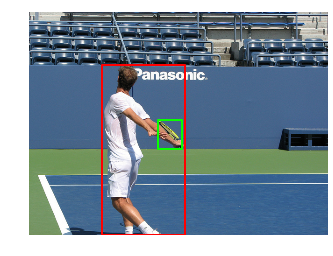

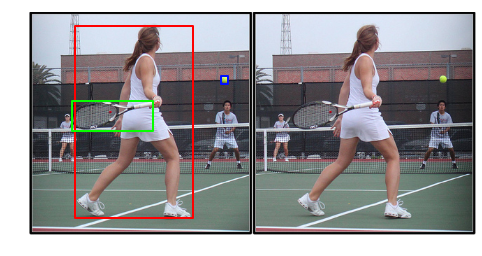

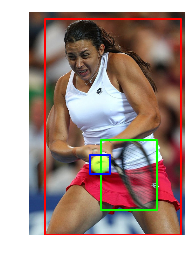

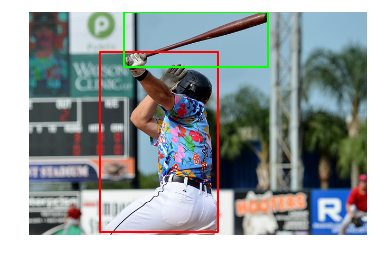

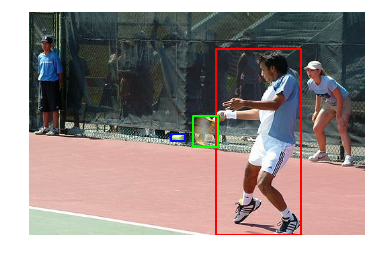

In [6]:
np.random.seed(1)
positive_index = np.where(vcoco['label'] == 1)[0]
positive_index = np.random.permutation(positive_index)

# the demo here laods images from the COCO website, 
# you can alternatively use your own local folder of COCO images.
load_coco_image_from_web = True
if load_coco_image_from_web:
    base_coco_url = 'http://mscoco.org/images/'
    from PIL import Image
    import urllib, cStringIO

cc = plt.get_cmap('hsv', lut=4)

for i in range(5):
    id = positive_index[i]

    # load image
    coco_image = coco.loadImgs(ids=[vcoco['image_id'][id][0]])[0]
    if load_coco_image_from_web:
        coco_url = base_coco_url + str(coco_image['id'])
        file = cStringIO.StringIO(urllib.urlopen(coco_url).read())
        im = np.asarray(Image.open(file))
        
    sy = 4.; sx = float(im.shape[1])/float(im.shape[0])*sy;
    fig, ax = subplot(plt, (1,1), (sy,sx)); ax.set_axis_off(); 
    ax.imshow(im);
    
    # draw bounding box for agent
    draw_bbox(plt, ax, vcoco['bbox'][[id],:], edgecolor=cc(0)[:3])
    role_bbox = vcoco['role_bbox'][id,:]*1.
    role_bbox = role_bbox.reshape((-1,4))
    for j in range(1, len(vcoco['role_name'])):
        if not np.isnan(role_bbox[j,0]):
            draw_bbox(plt, ax, role_bbox[[j],:], edgecolor=cc(j)[:3])